## Active learning-driven object detection in a semi-supervised setting

### Set up environment

In [ ]:
# Need to upgrade Albumentations version in Colab
!pip install -q --upgrade albumentations
!pip install git+https://github.com/PytorchLightning/lightning-bolts.git@master --upgrade -q

import albumentations as A
import datetime
import os
import time
import random
import sys
import numpy as np
import pickle
import math
import pandas as pd
import cv2
from skimage import io
import re
import argparse
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

from functools import partial
from tqdm import tqdm
tqdm = partial(tqdm, position=0, leave=True)

import torch
import torch.utils.data
from torch import nn
import torchvision
import torchvision.models.detection
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

     |████████████████████████████████| 98 kB 4.5 MB/s 
     |████████████████████████████████| 37.1 MB 1.2 MB/s 
     |████████████████████████████████| 234 kB 8.0 MB/s 
     |████████████████████████████████| 915 kB 63.4 MB/s 
     |████████████████████████████████| 118 kB 70.3 MB/s 
     |████████████████████████████████| 829 kB 55.5 MB/s 
     |████████████████████████████████| 10.6 MB 55.7 MB/s 
     |████████████████████████████████| 636 kB 64.3 MB/s 
     |████████████████████████████████| 1.3 MB 41.2 MB/s 
     |████████████████████████████████| 142 kB 71.6 MB/s 
     |████████████████████████████████| 294 kB 62.4 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.5.0 requires tensorboard~=2.5, but you have tensorboard 2.4.1 which is incompatible.


### Random seed

In [ ]:
def setup_seed(seed):
     os.environ['PYTHONHASHSEED'] = str(seed)
     torch.manual_seed(seed)
     torch.cuda.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     random.seed(seed)
     
     torch.backends.cudnn.deterministic = True
     torch.backends.cudnn.benchmark = False
     torch.backends.cudnn.enabled = False   

SEED = 202108
setup_seed(SEED) 

## Dataset

### DeepLesion

In [ ]:
"""
The images are stored in unsigned 16 bit. 
One shouldsubtract 32768 from the pixel intensity to obtain the original Hounsfield unit (HU) values.
"""
#read_hu = lambda x: io.imread(x).astype(np.float32) - 32768
read_hu = lambda x: cv2.imread(x).astype(np.float32) - 32768

class DeepLesionDataset(torch.utils.data.Dataset):
    def __init__ (self, root_dir, csv_path, transforms=None, dataset_type="train", lesion_type="all_types"):
        self.root_dir = root_dir
        self.csv_path = csv_path

        dataset_type_dict = {"train": 1, "val": 2, "test": 3, "non-specified": 0}
        lesion_type_dict = {"bone": 1, "abdomen": 2, "mediastinum": 3, "liver": 4, "lung": 5, "kidney": 6, "soft_tissue": 7, "pelvis": 8, "all_types": 0}

        self.df = pd.read_csv(csv_path)
        self.dataset_type = dataset_type_dict[dataset_type]
        if self.dataset_type != 0:
            self.df = self.df[self.df['Train_Val_Test'] == self.dataset_type]

        self.lesion_type = lesion_type_dict[lesion_type]
        if self.lesion_type != 0:
            self.df = self.df[self.df['Coarse_lesion_type'] == self.lesion_type]
        
        self.df['img_path'] = self.df.apply(lambda c_row: os.path.join(root_dir, 
                                                                  '{Patient_index:06d}_{Study_index:02d}_{Series_ID:02d}'.format(**c_row),
                                                                  '{Key_slice_index:03d}.png'.format(**c_row)), 1)
        self.df = self.df.reset_index()
        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def get_num_classes(self):
        return len(self.df['Coarse_lesion_type'].unique())

    def __getitem__(self, idx):
        # Read image path from the csv annotation file
        img_path = self.df.iloc[idx]['img_path']    
        img = read_hu(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Scale to [0, 1] and normalize
        mean, std = img.mean(), img.std()
        img = (img - mean) / std
        img = np.clip(img, -1.0, 1.0)
        img = (img + 1.0) / 2.0

        # Read bounding box coordinates (1-3 bboxes per image)
        # [x1, y1, x2, y2]
        boxes = []
        new_df = self.df[self.df['File_name']==self.df.iloc[idx]['File_name']]
        num_objs = len(new_df.index)
        for i in range(num_objs):
            coordinates_str = (re.split(',', new_df.iloc[i]['Bounding_boxes']))
            coordinates = [float(x) for x in coordinates_str]
            boxes.append(coordinates)
        boxes = np.asarray(boxes)

        labels = np.ones((num_objs, ), dtype=np.int64)

        if self.transforms is not None:
            transformed = self.transforms(image=img, bboxes=boxes, class_labels=labels)
            img, boxes = transformed['image'], transformed['bboxes']

        # Convert everything into torch.Tensors
        img = np.transpose(img, (2, 0, 1))
        img = torch.as_tensor(img)
        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        image_id = torch.tensor([idx])

        if len(boxes) == 0:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((1, 1), dtype=torch.int64)
            area = torch.tensor([0], dtype=torch.float32)
            iscrowd = torch.zeros((0,), dtype=torch.int64)
        else: 
            labels = torch.tensor(labels)
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
            iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Targets
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        return img, target

### Specify data augmentations

In [ ]:
transforms = A.Compose([
    A.ShiftScaleRotate(p=0.5),
    A.Transpose(p=0.5),
    A.RandomRotate90(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
  ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels'])
)

### Train/Val/Test split

In [ ]:
dataset_root = "/content/drive/MyDrive/data/DeepLesion/Images_png"
annotation_path = "/content/drive/MyDrive/data/DeepLesion/annotations/DL_info.csv"

In [ ]:
dataset = DeepLesionDataset(root_dir = dataset_root, transforms=transforms, csv_path=annotation_path, dataset_type="non-specified", lesion_type='lung')
val_dataset = DeepLesionDataset(root_dir = dataset_root, transforms=None, csv_path=annotation_path, dataset_type="non-specified", lesion_type='lung')
test_dataset = DeepLesionDataset(root_dir = dataset_root, transforms=None, csv_path=annotation_path, dataset_type="non-specified", lesion_type="lung")

num_train = int(0.8 * len(dataset))
num_val = int((len(dataset) - num_train) / 2)

indices = torch.randperm(len(dataset)).tolist()

train_dataset = torch.utils.data.Subset(dataset, indices[:num_train])
val_dataset = torch.utils.data.Subset(val_dataset, indices[num_train:num_train+num_val])
test_dataset = torch.utils.data.Subset(test_dataset, indices[num_train+num_val:])

print("Train: ", len(train_dataset))
print("Val: ", len(val_dataset))
print("Test: ", len(test_dataset))

Train:  1915
Val:  239
Test:  240


### Data visualization

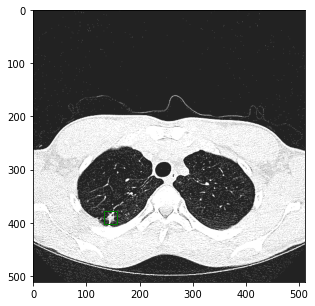

In [ ]:
sample_img = test_dataset[-1]
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(sample_img[0].numpy().transpose((1, 2, 0)), cmap = 'gray')
if len(sample_img[1]['boxes'].numpy()) != 0:
    x1, y1, x2, y2 = sample_img[1]['boxes'].numpy()[0]
    bbox = [Rectangle((x1, y1), np.abs(x2-x1), np.abs(y2-y1))]
    ax.add_collection(PatchCollection(bbox, facecolor = 'none', edgecolor='g'))

## Util functions

### COCO detection

In [ ]:
%%shell
pip install -q cython
# Install pycocotools, the version by default in Colab has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
pip install -q -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

In [ ]:
%%shell
# Download TorchVision repo to use some files from references/detection
git clone -q https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Note: checking out 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at be376084 version check against PyTorch's CUDA version


### Data sampler

In [ ]:
class SubsetSequentialSampler(torch.utils.data.Sampler):
    r"""Samples elements sequentially from a given list of indices, without replacement.

    Arguments:
        indices (sequence): a sequence of indices
    """

    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return (self.indices[i] for i in range(len(self.indices)))
    
    def __len__(self):
        return len(self.indices)

### Logging, configurations

In [ ]:
import logging

def get_logger(filename, verbosity=1, name=None):
    level_dict = {0: logging.DEBUG, 1: logging.INFO, 2: logging.WARNING}
    formatter = logging.Formatter(
        "[%(asctime)s][%(filename)s][line:%(lineno)d][%(levelname)s] %(message)s"
    )
    logger = logging.getLogger(name)
    logger.setLevel(level_dict[verbosity])

    if (logger.hasHandlers()):
        logger.handlers.clear()

    fh = logging.FileHandler(filename, "w")
    fh.setFormatter(formatter)
    logger.addHandler(fh)

    sh = logging.StreamHandler()
    sh.setFormatter(formatter)
    logger.addHandler(sh)

    return logger
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

## AL sample query strategies

### Uncertainty measure

In [ ]:
def calcu_iou(A, B):
    """ 
    calculate iou(s) between a reference box A and a predicted bounding box B
    """
    width = min(A[2], B[2]) - max(A[0], B[0]) + 1
    height = min(A[3], B[3]) - max(A[1], B[1]) + 1
    if width <= 0 or height <= 0:
        return 0
        
    Aarea = (A[2] - A[0] + 1) * (A[3] - A[1] + 1)
    Barea = (B[2] - B[0] + 1) * (B[3] - B[1] + 1)
    iner_area = width * height
    
    iou = iner_area / (Aarea + Barea - iner_area)

    return iou

def GaussianNoise(image, std=1):
    x = image + (torch.randn(image.size()) * std / 255.0).to(device)
    return x

In [ ]:
def get_uncertainty(task_model, dataloader, device, mode="LT/C", augs=None, base_point=1.3):
    task_model.eval()
    uncertainties = []
    with torch.no_grad():
        for images, labels in tqdm(dataloader):
            images = list(img.to(device) for img in images)
            torch.cuda.synchronize()

            if mode == "LT/C": 
                """ Localization Tightness (LT):
                    overlap between a predicted bbox and its intermediate proposal.
                """
                for image in images: 
                    _, output = task_model([image])
                    uncertainty = 1.0
                    for box, prop, prob_max in zip(output[0]['boxes'], output[0]['props'], output[0]['prob_max']):
                        iou = calcu_iou(box, prop)
                        u = torch.abs(iou + prob_max - 1)
                        uncertainty = min(uncertainty, u.item())
                    uncertainties.append(uncertainty)

            elif mode == "LS/C":
                """ Localization Stability (LS):
                    region stability w.r.t. different amount of Gaussian noises.
                """
                for image in images: 
                    _, output = task_model([image])
                    ref_boxes, prob_max, ref_labels = output[0]['boxes'], output[0]['prob_max'], output[0]['labels']
                    
                    if len(ref_boxes)== 0:
                        uncertainties.append(0.0)
                        continue
                    if len(ref_boxes) > 30:
                        inds = torch.topk(prob_max, 30)[1]
                        ref_boxes, prob_max, ref_labels = ref_boxes[inds], prob_max[inds], ref_labels[inds]

                    pred_stability = [0.0] * len(ref_boxes)
                    U = torch.max(1 - prob_max).item()

                    aug_images = [GaussianNoise(image, i * 8).to(device) for i in range(1, 7)]
                    aug_outputs = [task_model([aug_image])[0] for aug_image in aug_images]

                    for output in aug_outputs:
                        boxes = output['boxes']
                        if len(boxes) == 0:
                            continue

                        for i, ab in enumerate(ref_boxes):
                            width = torch.min(ab[2], boxes[:, 2]) - torch.max(ab[0], boxes[:, 0])
                            height = torch.min(ab[3], boxes[:, 3]) - torch.max(ab[1], boxes[:, 1])
                            Aarea = (ab[2] - ab[0]) * (ab[3] - ab[1])
                            Barea = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])
                            iner_area = width * height
                            iou = iner_area / (Aarea + Barea - iner_area)
                            iou[width < 0] = 0.0
                            iou[height < 0] = 0.0
                            pred_stability[i] += torch.max(iou).item()
                            
                    pred_stability = np.array(pred_stability) / len(aug_images)
                    prob_max = prob_max.cpu().numpy()
                    pred_stability = np.sum(prob_max * pred_stability) / np.sum(prob_max)
                    uncertainties.append(pred_stability - U)
            
            elif mode == "CALD":
                """ Consistency-based localization & classification uncertainty.
                """
                for image in images: 
                    _, output = task_model([F.to_tensor(image)])
                    ref_boxes, prob_max, ref_scores_cls, ref_labels, ref_scores = output[0]['boxes'], output[0][
                    'prob_max'], output[0]['scores_cls'], output[0]['labels'], output[0]['scores']

                    if output[0]['boxes'].shape[0] == 0:
                        uncertainties.append(0.0)
                        break
                    if len(ref_scores) > 40:
                        inds = np.round(np.linspace(0, len(ref_scores) - 1, 50)).astype(int)
                        ref_boxes, prob_max, ref_scores_cls, ref_labels, ref_scores = ref_boxes[inds], prob_max[
                            inds], ref_scores_cls[inds], ref_labels[inds], ref_scores[inds]
                    
                    aug_images, aug_boxes = apply_augmentations_for_cald(image, ref_boxes, ref_labels, augs)
                    aug_outputs = [task_model([aug_image])[0] for aug_image in aug_images]

                    aug_consistency = []
                    for aug_output, aug_box in zip(aug_outputs, aug_boxes):
                        consistency_img = 1.0
                        boxes, scores_cls, pm, labels, scores = aug_output['boxes'], aug_output['scores_cls'], aug_output['prob_max'], \
                                                            aug_output['labels'], aug_output['scores']

                        if len(boxes) == 0:
                            aug_consistency.append(0.0)
                            continue

                        for ab, ref_score_cls, ref_pm, ref_score in zip(aug_box, ref_scores_cls, prob_max, ref_scores):
                            iou = calcu_iou(ab, boxes)

                            p = ref_score_cls.cpu().numpy()
                            q = scores_cls[torch.argmax(iou)].cpu().numpy()
                            m = (p + q) / 2
                            js = max(0.5 * entropy(p, m) + 0.5 * entropy(q, m), 0)

                            consistency_img = min(consistency_img, torch.abs(
                                torch.max(iou) + 0.5 * (1 - js) * (ref_pm + pm[torch.argmax(iou)]) - base_point).item())
                    aug_consistency.append(np.mean(consistency_img))
                uncertainties.append(np.mean(aug_consistency))

    return uncertainties

### Representativeness measure

In [ ]:
def cosine_similarity(query, pool, criterion='average'):
    similarities = [F.cosine_similarity(query, key).cpu().numpy() for key in pool]

    if criterion == 'average':
        return (sum(similarities) / len(similarities))[0]
    elif criterion == 'medium':
        return np.medium(similarities)
    else:
        return max(similarities)

def get_pool_features(task_model, dataloader, device, mode='unlabeled'):
    """
    Output: List[Tensor(1, 256)]
    """
    pool = []
    imgs = []
    detections = []
    m = nn.AdaptiveAvgPool2d(1)
    idx = 0
    with torch.no_grad():
        for images, _ in tqdm(dataloader):
            images = list(image.to(device) for image in images)
            torch.cuda.synchronize()

            for image in images: 
                features, output = task_model([image])  
                imgs.append(image.detach().cpu())
                if mode == 'unlabeled':
                    above_thres = output[0]['scores'].detach().cpu().numpy() >= 0.5
                    if np.count_nonzero(above_thres) > 0:
                        # only select one per image
                        boxes = output[0]['boxes'].detach().cpu().numpy()[above_thres][0]
                        labels = output[0]['labels'].detach().cpu()[above_thres][0]
                        area = (boxes[3] - boxes[1]) * (boxes[2] - boxes[0])
                        boxes = torch.as_tensor([boxes], dtype=torch.float32)
                        labels = torch.tensor([labels], dtype=torch.int64)
                        area = torch.tensor([area])
                    else:
                        boxes = np.zeros((0, 4), dtype=np.float32)
                        boxes = torch.as_tensor(boxes, dtype=torch.float32)
                        labels = torch.tensor([0])
                        area = torch.tensor([0])

                    image_id = torch.tensor([idx])
                    iscrowd = torch.zeros((1,), dtype=torch.int64)

                    target = {}
                    target["boxes"] = boxes
                    target["labels"] = labels
                    target["image_id"] = image_id
                    target["area"] = area
                    target["iscrowd"] = iscrowd
                        
                    detections.append(target)

                idx = idx + 1

                # Adaptive pooling last layer feature map
                out = m(features['pool'])
                out = out.view(out.size(0), -1) # shape [1, 256]
                pool.append(out)
    
    return pool, imgs, detections

def get_sample_representativeness(task_model, labeled_dataloader, unlabeled_dataloader, device):
    task_model.eval()
    # Obtain features for both labeled and unlabeled pool
    unlabeled_pool, imgs, detections = get_pool_features(task_model, unlabeled_dataloader, device, mode='unlabeled')
    if len(labeled_dataloader) != 0:
        labeled_pool, _, _ = get_pool_features(task_model, labeled_dataloader, device, mode='labeled')

    # Get representativeness of every sample in the unlabeled pool
    reps = []
    for q in unlabeled_pool:
        if len(labeled_dataloader) != 0:
            training_score = cosine_similarity(q, labeled_pool)
        else:
            training_score = 0
        unlabeled_score = cosine_similarity(q, unlabeled_pool)
                    
        rep = unlabeled_score - training_score
        reps.append(rep)

    return reps, imgs, detections

In [ ]:
def dot_product(query, pool):
    dot_products = [torch.dot(query, key).cpu().numpy() for key in pool]

    return (sum(dot_products) / len(dot_products))[0]

### Combination

In [ ]:
def apply_query_criteria(task_model, dataloader, device, mode='unlabeled'):
    uncertainties = []

    pool = []
    imgs = []
    detections = []
    pseudo_flags = []

    m = nn.AdaptiveAvgPool2d(1)
    idx = 0
    if mode == 'unlabeled': 
        with torch.no_grad():
            for images, _ in tqdm(dataloader):
                images = list(image.to(device) for image in images)
                torch.cuda.synchronize()

                for image in images: 
                    features, output = task_model([image]) 
                    # first compute localization uncertainty
                    uncertainty = 1.0
                    for box, prop, prob_max in zip(output[0]['boxes'], output[0]['props'], output[0]['prob_max']):
                        iou = calcu_iou(box, prop)
                        u = torch.abs(iou + prob_max - 1)
                        uncertainty = min(uncertainty, u.item())
                    uncertainties.append(uncertainty)

                    # then extract pseudolabels and get pool features
                    imgs.append(image.detach().cpu())
                    if mode == 'unlabeled':
                        above_thres = output[0]['scores'].detach().cpu().numpy() >= 0.8
                        if np.count_nonzero(above_thres) > 0:
                            # only select one per image
                            boxes = output[0]['boxes'].detach().cpu().numpy()[above_thres][0]
                            labels = output[0]['labels'].detach().cpu()[above_thres][0]
                            area = (boxes[3] - boxes[1]) * (boxes[2] - boxes[0])
                            boxes = torch.as_tensor([boxes], dtype=torch.float32)
                            labels = torch.tensor([labels], dtype=torch.int64)
                            area = torch.tensor([area])
                            pseudo_flags.append(True)
                        else:
                            boxes = np.zeros((0, 4), dtype=np.float32)
                            boxes = torch.as_tensor(boxes, dtype=torch.float32)
                            labels = torch.tensor([0])
                            area = torch.tensor([0])
                            pseudo_flags.append(False)


                        image_id = torch.tensor([idx])
                        iscrowd = torch.zeros((1,), dtype=torch.int64)

                        target = {}
                        target["boxes"] = boxes
                        target["labels"] = labels
                        target["image_id"] = image_id
                        target["area"] = area
                        target["iscrowd"] = iscrowd
                            
                        detections.append(target)

                    idx = idx + 1

                    # Adaptive pooling last layer feature map
                    out = m(features['pool'])
                    out = out.view(out.size(0), -1) # shape [1, 256]
                    pool.append(out.detach().cpu().numpy()[0])
    else: 
        with torch.no_grad():
            for images, _ in tqdm(dataloader):
                images = list(image.to(device) for image in images)
                torch.cuda.synchronize()

                for image in images: 
                    features, output = task_model([image])
                    # only need pool features
                    # Adaptive pooling last layer feature map
                    out = m(features['pool'])
                    out = out.view(out.size(0), -1) # shape [1, 256]
                    pool.append(out.detach().cpu().numpy())
    return uncertainties, pool, imgs, detections, pseudo_flags

def get_query(task_model, unlabeled_dataloader, device):
    task_model.eval()

    uncertainties, unlabeled_pool, imgs, detections, pseudo_flags = apply_query_criteria(task_model, unlabeled_dataloader, device, mode='unlabeled')

    return uncertainties, unlabeled_pool, imgs, detections, pseudo_flags

## Semi-supervised Learning

In [ ]:
class PseudoDataset(torch.utils.data.Dataset):
    def __init__(self, pseudo_flags, imgs, targets, transforms=None):
        self.images = [img for img, flag in zip(imgs, pseudo_flags) if flag == True]
        self.targets = [target for target, flag in zip(targets, pseudo_flags) if flag == True]
        self.transforms = transforms

    def __getitem__(self, idx):
        img = self.images[idx]
        target = self.targets[idx]

        boxes = target['boxes']

        if self.transforms is not None:
            transformed = self.transforms(image=img, bboxes=boxes, class_labels=target['labels'])
            img, boxes = transformed['image'], transformed['bboxes']
        
        target['boxes'] = boxes

        return img, target

    def __len__(self):
        return len(self.images)

## Model (Faster R-CNN)

### Modules

In [ ]:
from torchvision.models.detection.faster_rcnn import TwoMLPHead, FastRCNNPredictor, FasterRCNN
from torchvision.models.detection.generalized_rcnn import *
from torchvision.models.detection.backbone_utils import *
from torchvision.models.detection.rpn import AnchorGenerator, permute_and_flatten
from torchvision.models.detection.rpn import RPNHead as RPNHead
from torchvision.models.detection.rpn import RegionProposalNetwork as RegionProposalNetwork
from torchvision.models.detection.roi_heads import RoIHeads as _RoIHeads
from torchvision.models.detection.roi_heads import fastrcnn_loss
from torchvision.ops.feature_pyramid_network import FeaturePyramidNetwork, LastLevelMaxPool
from torchvision.ops import misc as misc_nn_ops
from torchvision.ops import MultiScaleRoIAlign
from torchvision.models._utils import IntermediateLayerGetter
from torchvision.models import *
from torchvision.models.detection.transform import GeneralizedRCNNTransform
import torch.nn.functional as F
from torchvision.ops import roi_align
from torchvision.models.detection import _utils as det_utils
from torch.jit.annotations import Optional, List, Dict, Tuple
from torchvision.ops import boxes as box_ops
from torchvision.models.utils import load_state_dict_from_url

model_urls = {
    'fasterrcnn_resnet50_fpn_coco':
        'https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth',
}

class RoIHeads(_RoIHeads):
    def postprocess_detections(self, class_logits, box_regression, proposals, image_shapes):
        device = class_logits.device
        num_classes = class_logits.shape[-1]

        boxes_per_image = [len(boxes_in_image) for boxes_in_image in proposals]
        pred_boxes = self.box_coder.decode(box_regression, proposals)

        pred_scores = F.softmax(class_logits, -1)
        # split boxes and scores per image
        pred_boxes = pred_boxes.split(boxes_per_image, 0)
        pred_scores = pred_scores.split(boxes_per_image, 0)
        all_boxes = []
        all_scores = []
        all_labels = []
        all_props = []
        all_prob_max = []
        all_scores_cls = []

        for boxes, scores, props, image_shape in zip(pred_boxes, pred_scores, proposals, image_shapes):
            boxes = box_ops.clip_boxes_to_image(boxes, image_shape)

            # create labels for each prediction
            labels = torch.arange(num_classes, device=device)
            labels = labels.view(1, -1).expand_as(scores)
            scores_cls = scores.unsqueeze(1).expand(scores.shape[0], scores.shape[1] - 1, scores.shape[1])
            scores_cls = scores_cls.reshape(-1, scores.shape[1])
            # remove predictions with the background label
            boxes = boxes[:, 1:]
            scores = scores[:, 1:]
            labels = labels[:, 1:]
            props = props.unsqueeze(1).expand(props.shape[0], boxes.shape[1], props.shape[1])
            # batch everything, by making every class prediction be a separate instance
            prob_max = torch.max(scores, 1)[0]
            prob_max = prob_max.unsqueeze(1).expand(prob_max.shape[0], scores.shape[1])
            boxes = boxes.reshape(-1, 4)
            scores = scores.flatten()
            prob_max = prob_max.flatten()
            labels = labels.flatten()
            props = props.reshape(-1, 4)
            # remove low scoring boxes
            inds = torch.nonzero(scores > self.score_thresh).squeeze(1)
            boxes, scores, labels, props, prob_max, scores_cls = boxes[inds], scores[inds], labels[inds], props[inds], \
                                                                 prob_max[inds], scores_cls[inds]
            # non-maximum suppression, independently done per class
            keep = box_ops.batched_nms(boxes, scores, labels, self.nms_thresh)
            # keep only top k scoring predictions
            keep = keep[:self.detections_per_img]
            boxes, scores, labels, props, prob_max, scores_cls = \
                boxes[keep], scores[keep], labels[keep], props[keep], prob_max[keep], scores_cls[keep]
            all_boxes.append(boxes)
            all_scores.append(scores)
            all_labels.append(labels)
            all_props.append(props)
            all_prob_max.append(prob_max)
            all_scores_cls.append(scores_cls)
        return all_boxes, all_scores, all_labels, all_props, all_prob_max, all_scores_cls

    def forward(self, features, proposals, image_shapes, targets=None):
        # type: (Dict[str, Tensor], List[Tensor], List[Tuple[int, int]], Optional[List[Dict[str, Tensor]]])
        """
        Arguments:
            features (List[Tensor])
            proposals (List[Tensor[N, 4]])
            image_shapes (List[Tuple[H, W]])
            targets (List[Dict])
        """
        if targets is not None:
            for t in targets:
                floating_point_types = (torch.float, torch.double, torch.half)
                assert t["boxes"].dtype in floating_point_types, 'target boxes must of float type'
                assert t["labels"].dtype == torch.int64, 'target labels must of int64 type'
                if self.has_keypoint():
                    assert t["keypoints"].dtype == torch.float32, 'target keypoints must of float type'
        if self.training:
            proposals, matched_idxs, labels, regression_targets = self.select_training_samples(proposals, targets)
        else:
            labels = None
            regression_targets = None
            matched_idxs = None
        box_features = self.box_roi_pool(features, proposals, image_shapes)
        box_features = self.box_head(box_features)
        class_logits, box_regression = self.box_predictor(box_features)
        result = torch.jit.annotate(List[Dict[str, torch.Tensor]], [])
        losses = {}
        if self.training:
            assert labels is not None and regression_targets is not None
            loss_classifier, loss_box_reg = fastrcnn_loss(
                class_logits, box_regression, labels, regression_targets)
            losses = {
                "loss_classifier": loss_classifier,
                "loss_box_reg": loss_box_reg
            }
        else:
            boxes, scores, labels, props, prob_max, scores_cls = self.postprocess_detections(class_logits,
                                                                                             box_regression,
                                                                                             proposals, image_shapes)
            num_images = len(boxes)
            for i in range(num_images):
                result.append(
                    {
                        "boxes": boxes[i],
                        "labels": labels[i],
                        "scores": scores[i],
                        "props": props[i],
                        "prob_max": prob_max[i],
                        "scores_cls": scores_cls[i],
                    }
                )

        return result, losses


class FRCNN_Feature(FasterRCNN):
    def __init__(self, backbone, num_classes=None,
                 # transform parameters
                 min_size=800, max_size=1333,
                 image_mean=None, image_std=None,
                 # RPN parameters
                 rpn_anchor_generator=None, rpn_head=None,
                 rpn_pre_nms_top_n_train=2000, rpn_pre_nms_top_n_test=1000,
                 rpn_post_nms_top_n_train=2000, rpn_post_nms_top_n_test=1000,
                 rpn_nms_thresh=0.7,
                 rpn_fg_iou_thresh=0.7, rpn_bg_iou_thresh=0.3,
                 rpn_batch_size_per_image=256, rpn_positive_fraction=0.5,
                 # Box parameters
                 box_roi_pool=None, box_head=None, box_predictor=None,
                 box_score_thresh=0.05, box_nms_thresh=0.5, box_detections_per_img=100,
                 box_fg_iou_thresh=0.5, box_bg_iou_thresh=0.5,
                 box_batch_size_per_image=512, box_positive_fraction=0.25,
                 bbox_reg_weights=None):

        if not hasattr(backbone, "out_channels"):
            raise ValueError(
                "backbone should contain an attribute out_channels "
                "specifying the number of output channels (assumed to be the "
                "same for all the levels)")

        assert isinstance(rpn_anchor_generator, (AnchorGenerator, type(None)))
        assert isinstance(box_roi_pool, (MultiScaleRoIAlign, type(None)))

        if num_classes is not None:
            if box_predictor is not None:
                raise ValueError("num_classes should be None when box_predictor is specified")
        else:
            if box_predictor is None:
                raise ValueError("num_classes should not be None when box_predictor "
                                 "is not specified")

        out_channels = backbone.out_channels

        if rpn_anchor_generator is None:
            anchor_sizes = ((32,), (64,), (128,), (256,), (512,))
            #anchor_sizes = ((16,), (32,), (64,), (128,), (256,))
            aspect_ratios = ((0.5, 1.0, 2.0),) * len(anchor_sizes)
            rpn_anchor_generator = AnchorGenerator(
                anchor_sizes, aspect_ratios
            )
        if rpn_head is None:
            rpn_head = RPNHead(
                out_channels, rpn_anchor_generator.num_anchors_per_location()[0]
            )

        rpn_pre_nms_top_n = dict(training=rpn_pre_nms_top_n_train, testing=rpn_pre_nms_top_n_test)
        rpn_post_nms_top_n = dict(training=rpn_post_nms_top_n_train, testing=rpn_post_nms_top_n_test)

        rpn = RegionProposalNetwork(
            rpn_anchor_generator, rpn_head,
            rpn_fg_iou_thresh, rpn_bg_iou_thresh,
            rpn_batch_size_per_image, rpn_positive_fraction,
            rpn_pre_nms_top_n, rpn_post_nms_top_n, rpn_nms_thresh)

        if box_roi_pool is None:
            box_roi_pool = MultiScaleRoIAlign(
                featmap_names=['0', '1', '2', '3'],
                output_size=7,
                sampling_ratio=2)

        if box_head is None:
            resolution = box_roi_pool.output_size[0]
            representation_size = 1024
            box_head = TwoMLPHead(
                out_channels * resolution ** 2,
                representation_size)

        if box_predictor is None:
            representation_size = 1024
            box_predictor = FastRCNNPredictor(
                representation_size,
                num_classes)
        roi_heads = RoIHeads(  # Box
            box_roi_pool, box_head, box_predictor,
            box_fg_iou_thresh, box_bg_iou_thresh,
            box_batch_size_per_image, box_positive_fraction,
            bbox_reg_weights,
            box_score_thresh, box_nms_thresh, box_detections_per_img)

        if image_mean is None:
            image_mean = [0.485, 0.456, 0.406]
        if image_std is None:
            image_std = [0.229, 0.224, 0.225]
        transform = GeneralizedRCNNTransform(min_size, max_size, image_mean, image_std)
        super(FasterRCNN, self).__init__(backbone, rpn, roi_heads, transform)

    def forward(self, images, targets=None):
        """
        Arguments:
            images (list[Tensor]): images to be processed
            targets (list[Dict[Tensor]]): ground-truth boxes present in the image (optional)
        Returns:
            result (list[BoxList] or dict[Tensor]): the output from the model.
                During training, it returns a dict[Tensor] which contains the losses.
                During testing, it returns list[BoxList] contains additional fields
                like `scores`, `labels` and `mask` (for Mask R-CNN models).
        """
        if self.training and targets is None:
            raise ValueError("In training mode, targets should be passed")
        original_image_sizes = torch.jit.annotate(List[Tuple[int, int]], [])
        for img in images:
            val = img.shape[-2:]
            assert len(val) == 2
            original_image_sizes.append((val[0], val[1]))

        images, targets = self.transform(images, targets)
        
        features = self.backbone(images.tensors) # features out of the backbone
        if isinstance(features, torch.Tensor):
            features = OrderedDict([('0', features)])

        proposals, proposal_losses = self.rpn(images, features, targets)
        detections, detector_losses = self.roi_heads(features, proposals, images.image_sizes, targets)
        detections = self.transform.postprocess(detections, images.image_sizes, original_image_sizes)

        losses = {}
        losses.update(detector_losses)
        losses.update(proposal_losses)

        if torch.jit.is_scripting():
            if not self._has_warned:
                warnings.warn("RCNN always returns a (Losses, Detections) tuple in scripting")
                self._has_warned = True
            return (losses, detections)
        else:
            return features, self.eager_outputs(losses, detections)


class GeneralizedRCNNTransform(GeneralizedRCNNTransform):
    def postprocess(self, result, image_shapes, original_image_sizes):
        if self.training:
            return result
        for i, (pred, im_s, o_im_s) in enumerate(zip(result, image_shapes, original_image_sizes)):
            boxes = pred["boxes"]
            boxes = resize_boxes(boxes, im_s, o_im_s)
            result[i]["boxes"] = boxes
            props = pred["props"]
            props = resize_boxes(props, im_s, o_im_s)
            result[i]["props"] = props
        return result


def resize_boxes(boxes, original_size, new_size):
    ratios = tuple(float(s) / float(s_orig) for s, s_orig in zip(new_size, original_size))
    ratio_height, ratio_width = ratios
    xmin, ymin, xmax, ymax = boxes.unbind(1)
    xmin = xmin * ratio_width
    xmax = xmax * ratio_width
    ymin = ymin * ratio_height
    ymax = ymax * ratio_height
    return torch.stack((xmin, ymin, xmax, ymax), dim=1)

### Different backbones

In [ ]:
def fasterrcnn_resnet50_fpn_feature(pretrained=False, progress=True, num_classes=91, pretrained_backbone=True, trainable_layers=3,**kwargs):
    if pretrained: # no need to download the backbone if pretrained is set
        pretrained_backbone = False
    backbone = resnet_fpn_backbone('resnet50', pretrained_backbone)
    model = FRCNN_Feature(backbone, num_classes, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls['fasterrcnn_resnet50_fpn_coco'],
                                              progress=progress, strict=False)
        model.load_state_dict(state_dict)
    return model

## Training prep

### CUDA check

In [ ]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda
Tesla P100-PCIE-16GB
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


### Training hyperparameters

In [ ]:
args = {
    'num_cycles': 1,
    'start_cycle': 1,
    'num_epochs': 60,
    'init_num': int(0.2 * num_train),
    'budget_num': int(0.5 * num_train) - int(0.2 * num_train),
    'pseudolabel_num': 200,
    'ssl_start_cycle': 100,
    
    'num_workers': 2,
    'batch_size': 4,
    'lr': 3e-4,

    'momentum': 0.9,
    'weight_decay': 1e-8,
    'lr_gamma': 0.1,

    'step_size': 20,
    'gamma': 0.1,

    'print_freq': 100
}

configs = dotdict(args)

In [ ]:
configs.init_num

383

### Unlabeled-labeled split

In [ ]:
def seed_worker(worker_id):
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [ ]:
from utils import *

indices = list(range(len(train_dataset)))
labeled_set = indices[:configs.init_num]
unlabeled_set = indices[configs.init_num:]

# Train
train_sampler = SubsetRandomSampler(labeled_set)
# Val
data_loader_val = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=configs.num_workers, collate_fn=collate_fn)
# Test
data_loader_test = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=configs.num_workers, collate_fn=collate_fn)

### Create task model

In [ ]:
model_name = 'fasterrcnn_resnet50_fpn'
task_model = fasterrcnn_resnet50_fpn_feature(num_classes=2, pretrained_backbone=False) # including background (0)

task_model.to(device)

FRCNN_Feature(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (r

### Training utils

In [ ]:
def train_one_epoch(task_model, task_optimizer, data_loader, device, cycle, epoch, print_freq):
    task_model.train()
    metric_logger = MetricLogger(delimiter="  ")
    metric_logger.add_meter('task_lr', SmoothedValue(window_size=1, fmt='{value:.6f}'))
    header = 'Cycle:[{}] Epoch: [{}]'.format(cycle, epoch)

    task_lr_scheduler = None

    if epoch == 0:
        warmup_factor = 1. / 1000
        warmup_iters = min(1000, len(data_loader) - 1)

        task_lr_scheduler = warmup_lr_scheduler(task_optimizer, warmup_iters, warmup_factor)

    for images, targets in metric_logger.log_every(data_loader, print_freq, header):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        _, task_loss_dict = task_model(images, targets)
        
        task_losses = sum(loss for loss in task_loss_dict.values())
        # reduce losses over all GPUs for logging purposes
        task_loss_dict_reduced = reduce_dict(task_loss_dict)
        task_losses_reduced = sum(loss for loss in task_loss_dict_reduced.values())
        task_loss_value = task_losses_reduced.item()
        
        if not math.isfinite(task_loss_value):
            print("Loss is {}, stopping training".format(task_loss_value))
            print(task_loss_dict_reduced)
            sys.exit(1)

        task_optimizer.zero_grad()
        task_losses.backward()
        task_optimizer.step()

        if task_lr_scheduler is not None:
            task_lr_scheduler.step()

        metric_logger.update(task_loss=task_losses_reduced)
        metric_logger.update(task_lr=task_optimizer.param_groups[0]["lr"])
    return metric_logger

from coco_utils import get_coco_api_from_dataset
from coco_eval import CocoEvaluator

def _get_iou_types(model):
    model_without_ddp = model
    if isinstance(model, torch.nn.parallel.DistributedDataParallel):
        model_without_ddp = model.module
    iou_types = ["bbox"]
    if isinstance(model_without_ddp, torchvision.models.detection.MaskRCNN):
        iou_types.append("segm")
    if isinstance(model_without_ddp, torchvision.models.detection.KeypointRCNN):
        iou_types.append("keypoints")
    return iou_types

@torch.no_grad()
def evaluate(model, data_loader, device):
    n_threads = torch.get_num_threads()
    # FIXME remove this and make paste_masks_in_image run on the GPU
    torch.set_num_threads(1)
    cpu_device = torch.device("cpu")
    model.eval()
    metric_logger = MetricLogger(delimiter="  ")
    header = 'Test:'

    coco = get_coco_api_from_dataset(data_loader.dataset)
    iou_types = _get_iou_types(model)
    coco_evaluator = CocoEvaluator(coco, iou_types)

    for image, targets in metric_logger.log_every(data_loader, 100, header):
        image = list(img.to(device) for img in image)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        torch.cuda.synchronize()
        model_time = time.time()
        _, outputs = model(image)

        outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
        model_time = time.time() - model_time

        res = {target["image_id"].item(): output for target, output in zip(targets, outputs)}
        evaluator_time = time.time()
        coco_evaluator.update(res)
        evaluator_time = time.time() - evaluator_time
        metric_logger.update(model_time=model_time, evaluator_time=evaluator_time)

    # gather the stats from all processes
    metric_logger.synchronize_between_processes()
    print("Averaged stats:", metric_logger)
    coco_evaluator.synchronize_between_processes()

    # accumulate predictions from all images
    coco_evaluator.accumulate()
    coco_evaluator.summarize()
    torch.set_num_threads(n_threads)
    return coco_evaluator

## Train the initial model

#### Test: different base models

In [ ]:
# Get logger
exp_name = 'frcnn_baseline_50%' + str(SEED)
logfile_name = datetime.datetime.now().strftime("%m_%d_%H_%M_%Y") + '_' + exp_name
logger = get_logger('drive/MyDrive/exp_results/faster-rcnn-DeepLesion-alssl-pretrained/' + logfile_name + '.log')

logger.info('Training configurations: \n%s' %(args))
logger.info("Current labeled pool size: %d" %(len(labeled_set)))

# Prepare for training
train_batch_sampler = torch.utils.data.BatchSampler(train_sampler, configs.batch_size, drop_last=True)

g_seed = torch.Generator()
g_seed.manual_seed(SEED)
train_data_loader = DataLoader(train_dataset, batch_sampler=train_batch_sampler, 
                               worker_init_fn=seed_worker, generator=g_seed,
                               num_workers=configs.num_workers, collate_fn=collate_fn)

params = [p for p in task_model.parameters() if p.requires_grad]
task_optimizer = torch.optim.Adam(params, lr=configs.lr, weight_decay=configs.weight_decay, amsgrad=True)
task_lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(task_optimizer, T_max=configs.num_epochs)

logger.info("Start training")
start_time = time.time()

best_map = 0
plateau_num = 0
for epoch in range(configs.num_epochs):
  train_one_epoch(task_model, task_optimizer, train_data_loader, device, 0, epoch, configs.print_freq)
  task_lr_scheduler.step()

  # Evaluate performance
  evaluator = evaluate(task_model, data_loader_val, device=device)
  # Save the best model
  eval_stats = evaluator.coco_eval['bbox'].stats
  # Use the COCO mAP as the main criterion
  if eval_stats[0] > best_map:
      best_map = eval_stats[0]
      plateau_num = 0
      # Save checkpoint
      logger.info('Saving best checkpoints for mAP %f' %(best_map))
      save_on_master({'model': task_model.state_dict()}, 
                      'drive/MyDrive/exp_results/faster-rcnn-DeepLesion-alssl-pretrained/'+exp_name+'_best.pth')
  else:
      logger.info('No improvement observed.')
      plateau_num += 1
      if plateau_num == 10:
          logger.info('Training stops at epoch %d due to plateau in performance.' %(epoch+1))
          break

logger.info('COCO Performance on the test set')
evaluator = evaluate(task_model, data_loader_test, device=device)
logger.info(str(evaluator.coco_eval['bbox'].stats))

# Update sampler for training
total_time = time.time() - start_time
total_time_str = str(datetime.timedelta(seconds=int(total_time)))
logger.info('Training time {}'.format(total_time_str))

[2021-08-05 19:37:21,779][<ipython-input-26-eec21089c3ff>][line:6][INFO] Training configurations: 
{'num_cycles': 1, 'start_cycle': 1, 'num_epochs': 60, 'init_num': 957, 'budget_num': 191, 'pseudolabel_num': 200, 'ssl_start_cycle': 100, 'num_workers': 2, 'batch_size': 4, 'lr': 0.0003, 'momentum': 0.9, 'weight_decay': 1e-08, 'lr_gamma': 0.1, 'step_size': 20, 'gamma': 0.1, 'print_freq': 100}
[2021-08-05 19:37:21,781][<ipython-input-26-eec21089c3ff>][line:7][INFO] Current labeled pool size: 957
[2021-08-05 19:37:21,786][<ipython-input-26-eec21089c3ff>][line:22][INFO] Start training
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Cycle:[0] Epoch: [0]  [  0/239]  eta: 0:31:50  task_lr: 0.000002  task_loss: 4.2761 (4.2761)  time: 7.9928  data: 6.8705  max mem: 4219
Cycle:[0] Epoch: [0]  [100/239]  eta: 0:05:42  task_lr: 0.000127  task_loss: 0.1305 (0.2902)  time: 2.4159  data: 1.5098  max mem: 4958
Cycle:[0] Epoch: [0]  [200/239]  eta: 0:01:31  task_lr: 0.000253  task_loss: 0.1345 (0.2168)  time: 1.8110  data: 0.9061  max mem: 4965
Cycle:[0] Epoch: [0]  [238/239]  eta: 0:00:02  task_lr: 0.000300  task_loss: 0.1183 (0.2039)  time: 1.9513  data: 1.0464  max mem: 4965
Cycle:[0] Epoch: [0] Total time: 0:09:03 (2.2735 s / it)
creating index...
index created!
Test:  [  0/239]  eta: 0:00:49  model_time: 0.0972 (0.0972)  evaluator_time: 0.0018 (0.0018)  time: 0.2089  data: 0.1059  max mem: 4965
Test:  [100/239]  eta: 0:00:12  model_time: 0.0827 (0.0829)  evaluator_time: 0.0006 (0.0008)  time: 0.0912  data: 0.0044  max mem: 4965
Test:  [200/239]  eta: 0:00:03  model_time: 0.0826 (0.0828)  evaluator_time: 0.0006 (0.0008)  

[2021-08-05 20:03:45,280][<ipython-input-26-eec21089c3ff>][line:44][INFO] No improvement observed.


Test:  [238/239]  eta: 0:00:00  model_time: 0.0828 (0.0829)  evaluator_time: 0.0006 (0.0008)  time: 0.0903  data: 0.0043  max mem: 4965
Test: Total time: 0:00:21 (0.0915 s / it)
Averaged stats: model_time: 0.0828 (0.0829)  evaluator_time: 0.0006 (0.0008)
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-05 20:08:23,962][<ipython-input-26-eec21089c3ff>][line:40][INFO] Saving best checkpoints for mAP 0.055788


Test:  [238/239]  eta: 0:00:00  model_time: 0.0826 (0.0832)  evaluator_time: 0.0033 (0.0040)  time: 0.0922  data: 0.0039  max mem: 4965
Test: Total time: 0:00:22 (0.0941 s / it)
Averaged stats: model_time: 0.0826 (0.0832)  evaluator_time: 0.0033 (0.0040)
Accumulating evaluation results...
DONE (t=0.12s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.056
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.181
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.020
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.064
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.041
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.115
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.188
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-05 20:13:01,358][<ipython-input-26-eec21089c3ff>][line:40][INFO] Saving best checkpoints for mAP 0.129824


Test:  [238/239]  eta: 0:00:00  model_time: 0.0831 (0.0833)  evaluator_time: 0.0020 (0.0023)  time: 0.0917  data: 0.0042  max mem: 4965
Test: Total time: 0:00:21 (0.0920 s / it)
Averaged stats: model_time: 0.0831 (0.0833)  evaluator_time: 0.0020 (0.0023)
Accumulating evaluation results...
DONE (t=0.06s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.130
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.280
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.082
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.133
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.142
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.191
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.282
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-05 20:17:40,383][<ipython-input-26-eec21089c3ff>][line:44][INFO] No improvement observed.


Test:  [238/239]  eta: 0:00:00  model_time: 0.0826 (0.0832)  evaluator_time: 0.0023 (0.0026)  time: 0.0912  data: 0.0040  max mem: 4965
Test: Total time: 0:00:22 (0.0923 s / it)
Averaged stats: model_time: 0.0826 (0.0832)  evaluator_time: 0.0023 (0.0026)
Accumulating evaluation results...
DONE (t=0.08s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.111
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.290
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.057
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.116
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.119
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.179
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.264
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-05 20:22:21,734][<ipython-input-26-eec21089c3ff>][line:40][INFO] Saving best checkpoints for mAP 0.136091


Test:  [238/239]  eta: 0:00:00  model_time: 0.0835 (0.0838)  evaluator_time: 0.0025 (0.0027)  time: 0.0917  data: 0.0041  max mem: 4965
Test: Total time: 0:00:22 (0.0930 s / it)
Averaged stats: model_time: 0.0835 (0.0838)  evaluator_time: 0.0025 (0.0027)
Accumulating evaluation results...
DONE (t=0.08s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.136
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.369
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.054
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.136
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.155
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.202
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.296
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-05 20:27:02,375][<ipython-input-26-eec21089c3ff>][line:40][INFO] Saving best checkpoints for mAP 0.166587


Test:  [238/239]  eta: 0:00:00  model_time: 0.0832 (0.0836)  evaluator_time: 0.0020 (0.0022)  time: 0.0909  data: 0.0040  max mem: 4965
Test: Total time: 0:00:22 (0.0924 s / it)
Averaged stats: model_time: 0.0832 (0.0836)  evaluator_time: 0.0020 (0.0022)
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.167
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.323
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.145
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.169
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.188
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.236
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.338
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-05 20:31:43,365][<ipython-input-26-eec21089c3ff>][line:40][INFO] Saving best checkpoints for mAP 0.210208


Test:  [238/239]  eta: 0:00:00  model_time: 0.0832 (0.0836)  evaluator_time: 0.0022 (0.0024)  time: 0.0913  data: 0.0043  max mem: 4966
Test: Total time: 0:00:22 (0.0924 s / it)
Averaged stats: model_time: 0.0832 (0.0836)  evaluator_time: 0.0022 (0.0024)
Accumulating evaluation results...
DONE (t=0.06s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.210
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.368
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.210
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.207
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.246
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.296
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.408
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-05 20:36:22,743][<ipython-input-26-eec21089c3ff>][line:44][INFO] No improvement observed.


Test:  [238/239]  eta: 0:00:00  model_time: 0.0831 (0.0835)  evaluator_time: 0.0023 (0.0027)  time: 0.0912  data: 0.0040  max mem: 4966
Test: Total time: 0:00:22 (0.0925 s / it)
Averaged stats: model_time: 0.0831 (0.0835)  evaluator_time: 0.0023 (0.0027)
Accumulating evaluation results...
DONE (t=0.08s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.171
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.362
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.116
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.178
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.182
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.248
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.352
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-05 20:41:00,988][<ipython-input-26-eec21089c3ff>][line:44][INFO] No improvement observed.


Test:  [238/239]  eta: 0:00:00  model_time: 0.0832 (0.0834)  evaluator_time: 0.0029 (0.0030)  time: 0.0918  data: 0.0040  max mem: 4966
Test: Total time: 0:00:22 (0.0928 s / it)
Averaged stats: model_time: 0.0832 (0.0834)  evaluator_time: 0.0029 (0.0030)
Accumulating evaluation results...
DONE (t=0.09s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.181
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.356
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.171
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.192
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.178
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.251
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.387
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-05 20:45:40,512][<ipython-input-26-eec21089c3ff>][line:44][INFO] No improvement observed.


Test:  [238/239]  eta: 0:00:00  model_time: 0.0829 (0.0834)  evaluator_time: 0.0018 (0.0019)  time: 0.0905  data: 0.0040  max mem: 4966
Test: Total time: 0:00:21 (0.0915 s / it)
Averaged stats: model_time: 0.0829 (0.0834)  evaluator_time: 0.0018 (0.0019)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.192
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.375
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.179
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.197
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.213
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.273
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.381
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-05 20:50:19,418][<ipython-input-26-eec21089c3ff>][line:40][INFO] Saving best checkpoints for mAP 0.218400


Test:  [238/239]  eta: 0:00:00  model_time: 0.0829 (0.0833)  evaluator_time: 0.0021 (0.0022)  time: 0.0905  data: 0.0039  max mem: 4967
Test: Total time: 0:00:21 (0.0917 s / it)
Averaged stats: model_time: 0.0829 (0.0833)  evaluator_time: 0.0021 (0.0022)
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.218
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.400
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.222
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.228
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.233
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.300
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.381
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-05 20:54:58,538][<ipython-input-26-eec21089c3ff>][line:44][INFO] No improvement observed.


Test:  [238/239]  eta: 0:00:00  model_time: 0.0832 (0.0836)  evaluator_time: 0.0027 (0.0031)  time: 0.0919  data: 0.0040  max mem: 4967
Test: Total time: 0:00:22 (0.0931 s / it)
Averaged stats: model_time: 0.0832 (0.0836)  evaluator_time: 0.0027 (0.0031)
Accumulating evaluation results...
DONE (t=0.08s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.203
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.388
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.176
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.219
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.185
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.280
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.409
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-05 20:59:37,608][<ipython-input-26-eec21089c3ff>][line:44][INFO] No improvement observed.


Test:  [238/239]  eta: 0:00:00  model_time: 0.0832 (0.0834)  evaluator_time: 0.0023 (0.0023)  time: 0.0929  data: 0.0045  max mem: 4967
Test: Total time: 0:00:22 (0.0933 s / it)
Averaged stats: model_time: 0.0832 (0.0834)  evaluator_time: 0.0023 (0.0023)
Accumulating evaluation results...
DONE (t=0.06s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.191
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.363
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.184
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.202
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.198
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.285
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.423
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-05 21:04:16,487][<ipython-input-26-eec21089c3ff>][line:40][INFO] Saving best checkpoints for mAP 0.224667


Test:  [238/239]  eta: 0:00:00  model_time: 0.0829 (0.0833)  evaluator_time: 0.0020 (0.0020)  time: 0.0913  data: 0.0042  max mem: 4967
Test: Total time: 0:00:21 (0.0918 s / it)
Averaged stats: model_time: 0.0829 (0.0833)  evaluator_time: 0.0020 (0.0020)
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.225
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.432
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.225
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.238
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.205
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.297
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.405
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-05 21:08:55,461][<ipython-input-26-eec21089c3ff>][line:44][INFO] No improvement observed.


Test:  [238/239]  eta: 0:00:00  model_time: 0.0832 (0.0832)  evaluator_time: 0.0024 (0.0024)  time: 0.0913  data: 0.0041  max mem: 4967
Test: Total time: 0:00:21 (0.0918 s / it)
Averaged stats: model_time: 0.0832 (0.0832)  evaluator_time: 0.0024 (0.0024)
Accumulating evaluation results...
DONE (t=0.07s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.218
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.402
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.213
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.234
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.191
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.283
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.414
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-05 21:13:35,036][<ipython-input-26-eec21089c3ff>][line:40][INFO] Saving best checkpoints for mAP 0.233092


Test:  [238/239]  eta: 0:00:00  model_time: 0.0828 (0.0834)  evaluator_time: 0.0021 (0.0023)  time: 0.0916  data: 0.0042  max mem: 4967
Test: Total time: 0:00:22 (0.0933 s / it)
Averaged stats: model_time: 0.0828 (0.0834)  evaluator_time: 0.0021 (0.0023)
Accumulating evaluation results...
DONE (t=0.06s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.233
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.440
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.206
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.252
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.221
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.306
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.428
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-05 21:18:14,435][<ipython-input-26-eec21089c3ff>][line:40][INFO] Saving best checkpoints for mAP 0.236131


Test:  [238/239]  eta: 0:00:00  model_time: 0.0830 (0.0835)  evaluator_time: 0.0020 (0.0023)  time: 0.0917  data: 0.0044  max mem: 4967
Test: Total time: 0:00:22 (0.0926 s / it)
Averaged stats: model_time: 0.0830 (0.0835)  evaluator_time: 0.0020 (0.0023)
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.236
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.435
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.241
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.246
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.238
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.307
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.432
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-05 21:22:53,578][<ipython-input-26-eec21089c3ff>][line:44][INFO] No improvement observed.


Test:  [238/239]  eta: 0:00:00  model_time: 0.0833 (0.0835)  evaluator_time: 0.0027 (0.0029)  time: 0.0944  data: 0.0052  max mem: 4967
Test: Total time: 0:00:22 (0.0936 s / it)
Averaged stats: model_time: 0.0833 (0.0835)  evaluator_time: 0.0027 (0.0029)
Accumulating evaluation results...
DONE (t=0.08s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.220
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.433
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.199
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.242
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.193
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.001
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.298
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.418
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-05 21:27:32,375][<ipython-input-26-eec21089c3ff>][line:44][INFO] No improvement observed.


Test:  [238/239]  eta: 0:00:00  model_time: 0.0829 (0.0832)  evaluator_time: 0.0021 (0.0023)  time: 0.0910  data: 0.0044  max mem: 4967
Test: Total time: 0:00:21 (0.0917 s / it)
Averaged stats: model_time: 0.0829 (0.0832)  evaluator_time: 0.0021 (0.0023)
Accumulating evaluation results...
DONE (t=0.06s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.209
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.426
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.199
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.227
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.186
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.292
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.413
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-05 21:32:11,876][<ipython-input-26-eec21089c3ff>][line:40][INFO] Saving best checkpoints for mAP 0.260553


Test:  [238/239]  eta: 0:00:00  model_time: 0.0828 (0.0833)  evaluator_time: 0.0022 (0.0023)  time: 0.0925  data: 0.0043  max mem: 4967
Test: Total time: 0:00:22 (0.0925 s / it)
Averaged stats: model_time: 0.0828 (0.0833)  evaluator_time: 0.0022 (0.0023)
Accumulating evaluation results...
DONE (t=0.06s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.261
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.468
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.285
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.268
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.269
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.001
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.324
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.428
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-05 21:36:52,067][<ipython-input-26-eec21089c3ff>][line:40][INFO] Saving best checkpoints for mAP 0.265184


Test:  [238/239]  eta: 0:00:00  model_time: 0.0830 (0.0836)  evaluator_time: 0.0020 (0.0021)  time: 0.0916  data: 0.0041  max mem: 4967
Test: Total time: 0:00:22 (0.0924 s / it)
Averaged stats: model_time: 0.0830 (0.0836)  evaluator_time: 0.0020 (0.0021)
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.265
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.466
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.289
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.280
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.261
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.353
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.451
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-05 21:41:31,991][<ipython-input-26-eec21089c3ff>][line:44][INFO] No improvement observed.


Test:  [238/239]  eta: 0:00:00  model_time: 0.0832 (0.0834)  evaluator_time: 0.0022 (0.0023)  time: 0.0911  data: 0.0041  max mem: 4967
Test: Total time: 0:00:22 (0.0922 s / it)
Averaged stats: model_time: 0.0832 (0.0834)  evaluator_time: 0.0022 (0.0023)
Accumulating evaluation results...
DONE (t=0.06s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.236
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.435
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.235
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.246
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.263
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.326
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.439
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-05 21:46:10,629][<ipython-input-26-eec21089c3ff>][line:44][INFO] No improvement observed.


Test:  [238/239]  eta: 0:00:00  model_time: 0.0832 (0.0836)  evaluator_time: 0.0022 (0.0025)  time: 0.0912  data: 0.0041  max mem: 4967
Test: Total time: 0:00:22 (0.0931 s / it)
Averaged stats: model_time: 0.0832 (0.0836)  evaluator_time: 0.0022 (0.0025)
Accumulating evaluation results...
DONE (t=0.06s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.195
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.438
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.121
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.217
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.163
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.274
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.374
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-05 21:50:49,162][<ipython-input-26-eec21089c3ff>][line:44][INFO] No improvement observed.


Test:  [238/239]  eta: 0:00:00  model_time: 0.0835 (0.0833)  evaluator_time: 0.0024 (0.0024)  time: 0.0915  data: 0.0041  max mem: 4967
Test: Total time: 0:00:22 (0.0922 s / it)
Averaged stats: model_time: 0.0835 (0.0833)  evaluator_time: 0.0024 (0.0024)
Accumulating evaluation results...
DONE (t=0.07s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.217
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.479
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.152
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.221
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.249
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.005
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.286
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.410
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-05 21:55:28,379][<ipython-input-26-eec21089c3ff>][line:44][INFO] No improvement observed.


Test:  [238/239]  eta: 0:00:00  model_time: 0.0828 (0.0833)  evaluator_time: 0.0018 (0.0019)  time: 0.0900  data: 0.0038  max mem: 4967
Test: Total time: 0:00:21 (0.0915 s / it)
Averaged stats: model_time: 0.0828 (0.0833)  evaluator_time: 0.0018 (0.0019)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.228
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.432
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.190
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.233
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.263
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.311
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.436
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-05 22:00:06,995][<ipython-input-26-eec21089c3ff>][line:44][INFO] No improvement observed.


Test:  [238/239]  eta: 0:00:00  model_time: 0.0831 (0.0836)  evaluator_time: 0.0018 (0.0021)  time: 0.0921  data: 0.0043  max mem: 4967
Test: Total time: 0:00:22 (0.0927 s / it)
Averaged stats: model_time: 0.0831 (0.0836)  evaluator_time: 0.0018 (0.0021)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.245
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.484
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.211
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.247
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.275
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.314
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.416
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-05 22:04:44,845][<ipython-input-26-eec21089c3ff>][line:44][INFO] No improvement observed.


Test:  [238/239]  eta: 0:00:00  model_time: 0.0833 (0.0835)  evaluator_time: 0.0019 (0.0022)  time: 0.0912  data: 0.0044  max mem: 4967
Test: Total time: 0:00:22 (0.0922 s / it)
Averaged stats: model_time: 0.0833 (0.0835)  evaluator_time: 0.0019 (0.0022)
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.221
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.454
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.181
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.228
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.239
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.001
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.298
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.382
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-05 22:09:22,666][<ipython-input-26-eec21089c3ff>][line:44][INFO] No improvement observed.


Test:  [238/239]  eta: 0:00:00  model_time: 0.0829 (0.0836)  evaluator_time: 0.0020 (0.0022)  time: 0.0903  data: 0.0039  max mem: 4967
Test: Total time: 0:00:22 (0.0924 s / it)
Averaged stats: model_time: 0.0829 (0.0836)  evaluator_time: 0.0020 (0.0022)
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.212
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.434
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.185
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.223
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.216
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.298
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.405
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-05 22:14:00,427][<ipython-input-26-eec21089c3ff>][line:44][INFO] No improvement observed.


Test:  [238/239]  eta: 0:00:00  model_time: 0.0834 (0.0834)  evaluator_time: 0.0019 (0.0020)  time: 0.0914  data: 0.0042  max mem: 4967
Test: Total time: 0:00:21 (0.0918 s / it)
Averaged stats: model_time: 0.0834 (0.0834)  evaluator_time: 0.0019 (0.0020)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.178
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.474
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.085
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.171
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.233
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.243
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.317
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-05 22:18:39,679][<ipython-input-26-eec21089c3ff>][line:40][INFO] Saving best checkpoints for mAP 0.270364


Test:  [238/239]  eta: 0:00:00  model_time: 0.0832 (0.0837)  evaluator_time: 0.0018 (0.0019)  time: 0.0962  data: 0.0039  max mem: 4967
Test: Total time: 0:00:21 (0.0920 s / it)
Averaged stats: model_time: 0.0832 (0.0837)  evaluator_time: 0.0018 (0.0019)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.270
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.491
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.286
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.275
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.289
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.338
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.435
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-05 22:23:18,952][<ipython-input-26-eec21089c3ff>][line:40][INFO] Saving best checkpoints for mAP 0.279390


Test:  [238/239]  eta: 0:00:00  model_time: 0.0833 (0.0834)  evaluator_time: 0.0021 (0.0023)  time: 0.0908  data: 0.0040  max mem: 4967
Test: Total time: 0:00:22 (0.0922 s / it)
Averaged stats: model_time: 0.0833 (0.0834)  evaluator_time: 0.0021 (0.0023)
Accumulating evaluation results...
DONE (t=0.06s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.279
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.499
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.274
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.281
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.308
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.356
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.464
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-05 22:27:54,799][<ipython-input-26-eec21089c3ff>][line:44][INFO] No improvement observed.


Test:  [238/239]  eta: 0:00:00  model_time: 0.0829 (0.0830)  evaluator_time: 0.0017 (0.0018)  time: 0.0899  data: 0.0040  max mem: 4967
Test: Total time: 0:00:21 (0.0907 s / it)
Averaged stats: model_time: 0.0829 (0.0830)  evaluator_time: 0.0017 (0.0018)
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.228
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.447
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.201
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.241
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.231
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.297
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.412
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-05 22:32:30,873][<ipython-input-26-eec21089c3ff>][line:44][INFO] No improvement observed.


Test:  [238/239]  eta: 0:00:00  model_time: 0.0823 (0.0826)  evaluator_time: 0.0017 (0.0019)  time: 0.0892  data: 0.0035  max mem: 4967
Test: Total time: 0:00:21 (0.0902 s / it)
Averaged stats: model_time: 0.0823 (0.0826)  evaluator_time: 0.0017 (0.0019)
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.242
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.480
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.197
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.250
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.248
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.331
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.442
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-05 22:37:07,614][<ipython-input-26-eec21089c3ff>][line:44][INFO] No improvement observed.


Test:  [238/239]  eta: 0:00:00  model_time: 0.0825 (0.0828)  evaluator_time: 0.0016 (0.0018)  time: 0.0903  data: 0.0040  max mem: 4967
Test: Total time: 0:00:21 (0.0909 s / it)
Averaged stats: model_time: 0.0825 (0.0828)  evaluator_time: 0.0016 (0.0018)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.267
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.505
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.264
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.273
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.273
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.347
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.445
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-05 22:41:44,344][<ipython-input-26-eec21089c3ff>][line:40][INFO] Saving best checkpoints for mAP 0.293920


Test:  [238/239]  eta: 0:00:00  model_time: 0.0832 (0.0831)  evaluator_time: 0.0020 (0.0020)  time: 0.0907  data: 0.0040  max mem: 4967
Test: Total time: 0:00:21 (0.0914 s / it)
Averaged stats: model_time: 0.0832 (0.0831)  evaluator_time: 0.0020 (0.0020)
Accumulating evaluation results...
DONE (t=0.06s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.294
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.500
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.319
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.306
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.293
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.363
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.489
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-05 22:46:20,299][<ipython-input-26-eec21089c3ff>][line:44][INFO] No improvement observed.


Test:  [238/239]  eta: 0:00:00  model_time: 0.0823 (0.0828)  evaluator_time: 0.0015 (0.0018)  time: 0.0888  data: 0.0035  max mem: 4967
Test: Total time: 0:00:21 (0.0905 s / it)
Averaged stats: model_time: 0.0823 (0.0828)  evaluator_time: 0.0015 (0.0018)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.266
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.478
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.296
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.275
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.288
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.325
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.449
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-05 22:50:55,461][<ipython-input-26-eec21089c3ff>][line:44][INFO] No improvement observed.


Test:  [238/239]  eta: 0:00:00  model_time: 0.0831 (0.0834)  evaluator_time: 0.0019 (0.0019)  time: 0.0911  data: 0.0041  max mem: 4967
Test: Total time: 0:00:21 (0.0912 s / it)
Averaged stats: model_time: 0.0831 (0.0834)  evaluator_time: 0.0019 (0.0019)
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.265
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.481
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.264
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.278
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.263
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.339
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.455
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-05 22:55:31,821][<ipython-input-26-eec21089c3ff>][line:44][INFO] No improvement observed.


Test:  [238/239]  eta: 0:00:00  model_time: 0.0824 (0.0826)  evaluator_time: 0.0016 (0.0018)  time: 0.0888  data: 0.0034  max mem: 4967
Test: Total time: 0:00:21 (0.0901 s / it)
Averaged stats: model_time: 0.0824 (0.0826)  evaluator_time: 0.0016 (0.0018)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.264
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.482
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.270
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.276
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.265
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.326
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.440
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-05 23:00:07,908][<ipython-input-26-eec21089c3ff>][line:44][INFO] No improvement observed.


Test:  [238/239]  eta: 0:00:00  model_time: 0.0824 (0.0831)  evaluator_time: 0.0017 (0.0019)  time: 0.0903  data: 0.0035  max mem: 4967
Test: Total time: 0:00:21 (0.0916 s / it)
Averaged stats: model_time: 0.0824 (0.0831)  evaluator_time: 0.0017 (0.0019)
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.255
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.487
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.247
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.258
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.276
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.003
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.323
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.433
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-05 23:04:42,949][<ipython-input-26-eec21089c3ff>][line:44][INFO] No improvement observed.


Test:  [238/239]  eta: 0:00:00  model_time: 0.0829 (0.0828)  evaluator_time: 0.0018 (0.0019)  time: 0.0900  data: 0.0038  max mem: 4967
Test: Total time: 0:00:21 (0.0906 s / it)
Averaged stats: model_time: 0.0829 (0.0828)  evaluator_time: 0.0018 (0.0019)
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.254
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.490
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.220
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.263
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.263
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.331
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.430
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-05 23:09:19,619][<ipython-input-26-eec21089c3ff>][line:44][INFO] No improvement observed.


Test:  [238/239]  eta: 0:00:00  model_time: 0.0823 (0.0826)  evaluator_time: 0.0017 (0.0019)  time: 0.0892  data: 0.0038  max mem: 4967
Test: Total time: 0:00:21 (0.0904 s / it)
Averaged stats: model_time: 0.0823 (0.0826)  evaluator_time: 0.0017 (0.0019)
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.260
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.522
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.226
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.260
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.289
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.003
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.343
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.446
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-05 23:13:55,006][<ipython-input-26-eec21089c3ff>][line:44][INFO] No improvement observed.


Test:  [238/239]  eta: 0:00:00  model_time: 0.0827 (0.0828)  evaluator_time: 0.0017 (0.0017)  time: 0.0895  data: 0.0037  max mem: 4967
Test: Total time: 0:00:21 (0.0905 s / it)
Averaged stats: model_time: 0.0827 (0.0828)  evaluator_time: 0.0017 (0.0017)
Accumulating evaluation results...
DONE (t=0.06s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.229
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.508
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.169
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.229
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.257
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.004
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.317
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.391
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-05 23:18:31,762][<ipython-input-26-eec21089c3ff>][line:44][INFO] No improvement observed.


Test:  [238/239]  eta: 0:00:00  model_time: 0.0827 (0.0829)  evaluator_time: 0.0017 (0.0019)  time: 0.0900  data: 0.0038  max mem: 4967
Test: Total time: 0:00:21 (0.0908 s / it)
Averaged stats: model_time: 0.0827 (0.0829)  evaluator_time: 0.0017 (0.0019)
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.262
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.503
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.258
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.269
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.269
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.334
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.442
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-05 23:23:08,191][<ipython-input-26-eec21089c3ff>][line:44][INFO] No improvement observed.


Test:  [238/239]  eta: 0:00:00  model_time: 0.0824 (0.0835)  evaluator_time: 0.0016 (0.0019)  time: 0.0947  data: 0.0036  max mem: 4967
Test: Total time: 0:00:21 (0.0917 s / it)
Averaged stats: model_time: 0.0824 (0.0835)  evaluator_time: 0.0016 (0.0019)
Accumulating evaluation results...
DONE (t=0.06s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.283
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.514
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.281
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.282
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.315
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.001
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.346
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.452
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-05 23:27:43,943][<ipython-input-26-eec21089c3ff>][line:40][INFO] Saving best checkpoints for mAP 0.294653


Test:  [238/239]  eta: 0:00:00  model_time: 0.0831 (0.0829)  evaluator_time: 0.0017 (0.0018)  time: 0.0898  data: 0.0037  max mem: 4967
Test: Total time: 0:00:21 (0.0907 s / it)
Averaged stats: model_time: 0.0831 (0.0829)  evaluator_time: 0.0017 (0.0018)
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.295
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.517
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.282
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.296
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.323
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.370
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.476
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-05 23:32:21,370][<ipython-input-26-eec21089c3ff>][line:44][INFO] No improvement observed.


Test:  [238/239]  eta: 0:00:00  model_time: 0.0824 (0.0827)  evaluator_time: 0.0016 (0.0018)  time: 0.0888  data: 0.0035  max mem: 4967
Test: Total time: 0:00:21 (0.0903 s / it)
Averaged stats: model_time: 0.0824 (0.0827)  evaluator_time: 0.0016 (0.0018)
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.266
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.517
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.254
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.271
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.283
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.327
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.447
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-05 23:36:58,390][<ipython-input-26-eec21089c3ff>][line:44][INFO] No improvement observed.


Test:  [238/239]  eta: 0:00:00  model_time: 0.0825 (0.0831)  evaluator_time: 0.0015 (0.0018)  time: 0.0908  data: 0.0041  max mem: 4967
Test: Total time: 0:00:22 (0.0923 s / it)
Averaged stats: model_time: 0.0825 (0.0831)  evaluator_time: 0.0015 (0.0018)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.265
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.520
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.230
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.272
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.276
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.335
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.434
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-05 23:41:35,233][<ipython-input-26-eec21089c3ff>][line:44][INFO] No improvement observed.


Test:  [238/239]  eta: 0:00:00  model_time: 0.0829 (0.0829)  evaluator_time: 0.0018 (0.0019)  time: 0.0914  data: 0.0041  max mem: 4967
Test: Total time: 0:00:21 (0.0914 s / it)
Averaged stats: model_time: 0.0829 (0.0829)  evaluator_time: 0.0018 (0.0019)
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.260
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.519
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.228
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.265
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.274
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.001
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.322
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.438
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-05 23:46:10,363][<ipython-input-26-eec21089c3ff>][line:44][INFO] No improvement observed.


Test:  [238/239]  eta: 0:00:00  model_time: 0.0828 (0.0833)  evaluator_time: 0.0017 (0.0019)  time: 0.0907  data: 0.0040  max mem: 4967
Test: Total time: 0:00:21 (0.0918 s / it)
Averaged stats: model_time: 0.0828 (0.0833)  evaluator_time: 0.0017 (0.0019)
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.261
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.521
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.238
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.263
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.288
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.335
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.431
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-05 23:50:46,694][<ipython-input-26-eec21089c3ff>][line:44][INFO] No improvement observed.


Test:  [238/239]  eta: 0:00:00  model_time: 0.0828 (0.0827)  evaluator_time: 0.0018 (0.0018)  time: 0.0900  data: 0.0038  max mem: 4967
Test: Total time: 0:00:21 (0.0903 s / it)
Averaged stats: model_time: 0.0828 (0.0827)  evaluator_time: 0.0018 (0.0018)
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.276
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.526
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.271
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.280
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.291
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.004
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.342
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.447
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-05 23:55:23,179][<ipython-input-26-eec21089c3ff>][line:44][INFO] No improvement observed.


Test:  [238/239]  eta: 0:00:00  model_time: 0.0824 (0.0828)  evaluator_time: 0.0016 (0.0018)  time: 0.0889  data: 0.0034  max mem: 4967
Test: Total time: 0:00:21 (0.0904 s / it)
Averaged stats: model_time: 0.0824 (0.0828)  evaluator_time: 0.0016 (0.0018)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.260
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.514
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.215
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.264
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.275
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.335
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.432
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-05 23:59:58,903][<ipython-input-26-eec21089c3ff>][line:44][INFO] No improvement observed.


Test:  [238/239]  eta: 0:00:00  model_time: 0.0823 (0.0831)  evaluator_time: 0.0015 (0.0018)  time: 0.0892  data: 0.0036  max mem: 4967
Test: Total time: 0:00:21 (0.0915 s / it)
Averaged stats: model_time: 0.0823 (0.0831)  evaluator_time: 0.0015 (0.0018)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.270
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.524
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.265
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.277
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.283
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.344
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.440
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-06 00:04:34,247][<ipython-input-26-eec21089c3ff>][line:44][INFO] No improvement observed.


Test:  [238/239]  eta: 0:00:00  model_time: 0.0827 (0.0827)  evaluator_time: 0.0017 (0.0018)  time: 0.0899  data: 0.0038  max mem: 4967
Test: Total time: 0:00:21 (0.0903 s / it)
Averaged stats: model_time: 0.0827 (0.0827)  evaluator_time: 0.0017 (0.0018)
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.249
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.510
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.219
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.254
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.263
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.328
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.428
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-06 00:09:10,538][<ipython-input-26-eec21089c3ff>][line:44][INFO] No improvement observed.


Test:  [238/239]  eta: 0:00:00  model_time: 0.0822 (0.0826)  evaluator_time: 0.0015 (0.0017)  time: 0.0888  data: 0.0035  max mem: 4967
Test: Total time: 0:00:21 (0.0901 s / it)
Averaged stats: model_time: 0.0822 (0.0826)  evaluator_time: 0.0015 (0.0017)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.281
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.528
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.279
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.289
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.287
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.347
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.458
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-06 00:13:47,395][<ipython-input-26-eec21089c3ff>][line:44][INFO] No improvement observed.
[2021-08-06 00:13:47,397][<ipython-input-26-eec21089c3ff>][line:47][INFO] Training stops at epoch 55 due to plateau in performance.
[2021-08-06 00:13:47,404][<ipython-input-26-eec21089c3ff>][line:50][INFO] COCO Performance on the test set


Test:  [238/239]  eta: 0:00:00  model_time: 0.0825 (0.0827)  evaluator_time: 0.0015 (0.0017)  time: 0.0899  data: 0.0038  max mem: 4967
Test: Total time: 0:00:21 (0.0904 s / it)
Averaged stats: model_time: 0.0825 (0.0827)  evaluator_time: 0.0015 (0.0017)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.288
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.522
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.296
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.299
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.292
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.368
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.466
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-06 00:14:44,264][<ipython-input-26-eec21089c3ff>][line:52][INFO] [0.25065955 0.45984435 0.25993482 0.27478144 0.20970187 0.00763791
 0.3291498  0.46315789 0.46315789 0.47885714 0.43478261 0.2       ]
[2021-08-06 00:14:44,267][<ipython-input-26-eec21089c3ff>][line:57][INFO] Training time 4:37:22


Test:  [239/240]  eta: 0:00:00  model_time: 0.0828 (0.0830)  evaluator_time: 0.0017 (0.0018)  time: 0.0899  data: 0.0037  max mem: 4967
Test: Total time: 0:00:21 (0.0910 s / it)
Averaged stats: model_time: 0.0828 (0.0830)  evaluator_time: 0.0017 (0.0018)
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.251
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.460
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.260
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.275
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.210
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.008
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.329
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.463
 Average Recall     (AR) @[ IoU=0.50:

In [ ]:
path = 'drive/MyDrive/exp_results/faster-rcnn-DeepLesion-alssl-pretrained/'+exp_name+'_best.pth'
task_model.load_state_dict(torch.load(path)['model'])
evaluator = evaluate(task_model, data_loader_test, device=device)

creating index...
index created!
Test:  [  0/240]  eta: 0:00:57  model_time: 0.1007 (0.1007)  evaluator_time: 0.0041 (0.0041)  time: 0.2377  data: 0.1309  max mem: 4967
Test:  [100/240]  eta: 0:00:12  model_time: 0.0827 (0.0833)  evaluator_time: 0.0017 (0.0018)  time: 0.0897  data: 0.0038  max mem: 4967
Test:  [200/240]  eta: 0:00:03  model_time: 0.0829 (0.0833)  evaluator_time: 0.0017 (0.0018)  time: 0.0907  data: 0.0042  max mem: 4967
Test:  [239/240]  eta: 0:00:00  model_time: 0.0828 (0.0833)  evaluator_time: 0.0017 (0.0018)  time: 0.0902  data: 0.0040  max mem: 4967
Test: Total time: 0:00:21 (0.0914 s / it)
Averaged stats: model_time: 0.0828 (0.0833)  evaluator_time: 0.0017 (0.0018)
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.241
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.444
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.

####one-step AL + pseudolabels

In [ ]:
import sklearn
from sklearn.cluster import KMeans

In [ ]:
# Get logger
exp_name = 'frcnn_onestepAL_20to50_lr3e-4_CA_'+str(SEED)
root = 'drive/MyDrive/exp_results/faster-rcnn-DeepLesion-alssl'
pretrained_root = 'drive/MyDrive/exp_results/faster-rcnn-DeepLesion-alssl-pretrained'
exp_dir = os.path.join(root, exp_name)

# Make exp folder
if not os.path.isdir(exp_dir):
    os.mkdir(exp_dir)

logger = get_logger(os.path.join(exp_dir, 'training_info.log'))
logger.info('Training configurations: \n%s' %(args))

# Load pretrained checkpoints
if configs.start_cycle == 1:
    # Load initial checkpoints
    checkpoint_path = os.path.join(pretrained_root, 'frcnn_initial_20%_lr1e-3_CA_'+str(SEED)+'_best.pth')
else:
    checkpoint_path = os.path.join(exp_dir, exp_name+'_cycle%d.pth' %(configs.start_cycle-1))
    # Load previous labeled/unlabeled indices
    labeled_set = list(np.loadtxt(os.path.join(exp_dir, exp_name+'_labeled_set_cycle%d.txt'%(configs.start_cycle-1)), dtype=int))
    unlabeled_set = list(np.loadtxt(os.path.join(exp_dir, exp_name+'_unlabeled_set_cycle%d.txt'%(configs.start_cycle-1)), dtype=int))

logger.info('Loading pretrained from %s' %(checkpoint_path))
task_model.load_state_dict(torch.load(checkpoint_path)['model'])
logger.info('\nCurrent performance on test set:')
evaluator = evaluate(task_model, data_loader_test, device=device)
logger.info(str(evaluator.coco_eval['bbox'].stats))

# SSL status flag 
INCLUDE_PSEUDOLABEL = False

for cycle in range(configs.start_cycle, configs.num_cycles + 1):
    if cycle >= configs.ssl_start_cycle:
        INCLUDE_PSEUDOLABEL = True
        logger.info("\nWill include pseudolabels.")
    else:
        logger.info('\nNo pseudolabel training for this cycle ...')

    logger.info("\nActive Learning Cycle %d" %(cycle))

    labeled_loader = DataLoader(train_dataset, batch_size=1, sampler=SubsetSequentialSampler(labeled_set), 
                                num_workers=configs.num_workers, pin_memory=True, collate_fn=collate_fn)
    logger.info("\nCurrent labeled pool size: %d" %(len(labeled_set)))

    # Compute uncertainties for the unlabeled pool
    unlabeled_loader = DataLoader(train_dataset, batch_size=1, sampler=SubsetSequentialSampler(unlabeled_set),
                                  num_workers=configs.num_workers, pin_memory=True, collate_fn=collate_fn)

    # Get needed info by inference over the entire unlabeled set
    uncertainties, unlabeled_pool, imgs, detections, pseudo_flags = get_query(task_model, unlabeled_loader, device)

    # first rank by uncertainty, choose the top 2*N ones
    arg1 = np.argsort(uncertainties)

    # cluster by k-means, set k = 10
    kmeans_pool = np.array(unlabeled_pool)[arg1][:configs.budget_num * 2]
    kmeans = KMeans(n_clusters=10)
    clusters = kmeans.fit(kmeans_pool)
    cluster_labels = clusters.labels_
    cluster_indices = arg1[:configs.budget_num * 2]
    cluster_dict = {}
    
    # group unlabeled indices by cluster
    for label, index in zip(cluster_labels, cluster_indices):
        if label not in cluster_dict:
            cluster_dict[label] = []
        cluster_dict[label].append(index)
    
    # iterate over clusters, choose one sample each iteration until meet the budget number
    to_be_added = []
    count = 0
    while count < configs.budget_num:
        for c in range(10):
            if len(cluster_dict[c]) > 0:
                selected = random.choice(cluster_dict[c])
                to_be_added.append(selected)
                cluster_dict[c].remove(selected)
                count += 1
                if count == configs.budget_num:
                    break
            else:
                continue

    to_be_added = np.array(to_be_added)
    labeled_set += list(torch.tensor(unlabeled_set)[to_be_added].numpy())
    unlabeled_set = list(set(indices) - set(labeled_set)) 

    # Save labeled & unlabeled indices
    np.savetxt(os.path.join(exp_dir, exp_name+'_labeled_set_cycle%d.txt'%(cycle)), labeled_set, fmt='%d')
    np.savetxt(os.path.join(exp_dir, exp_name+'_unlabeled_set_cycle%d.txt'%(cycle)), unlabeled_set, fmt='%d')

    # Assign pseudolabels to the most confident predictions, and add them to labeled dataset
    if INCLUDE_PSEUDOLABEL:
        logger.info('\nGetting pseudolabels ...')
        # Choose the most CONFIDENT predictions for pseudolabeling
        pseudo_set = list(set(arg1) - set(to_be_added))
        ordered_imgs = [imgs[i] for i in pseudo_set] 
        ordered_detections = [detections[i] for i in pseudo_set]
        pseudo_flags = [pseudo_flags[i] for i in pseudo_set]

        #pseudolabel_num_updated = min(configs.pseudolabel_num, len(unlabeled_set))
        pseudo_train_dataset = PseudoDataset(pseudo_flags, ordered_imgs, ordered_detections, transforms=None)
        logger.info('%d pseudo-labels are added to the training set' %(len(pseudo_train_dataset)))
        logger.info('Saving pseudolabels for reference')
        torch.save(pseudo_train_dataset, os.path.join(exp_dir, 'pseudolabels_cycle%d.pt' %(cycle)))

        # Create new train dataset
        concat_train_dataset = torch.utils.data.ConcatDataset([train_dataset, pseudo_train_dataset])
        logger.info('Current training dataset size: %d' %(len(pseudo_train_dataset) + len(labeled_set)))

        # Update sampler for this cycle
        train_sampler = SubsetRandomSampler(list(set(range(len(train_dataset), len(concat_train_dataset))) | set(labeled_set)))
    else: 
        logger.info('\nNo pseudolabel training for this cycle ...')
        train_sampler = SubsetRandomSampler(labeled_set)

    # Train prep
    train_batch_sampler = torch.utils.data.BatchSampler(train_sampler, configs.batch_size, drop_last=True)

    g_seed = torch.Generator()
    g_seed.manual_seed(SEED)
    if INCLUDE_PSEUDOLABEL:
        train_data_loader = torch.utils.data.DataLoader(concat_train_dataset, batch_sampler=train_batch_sampler, 
                                                        worker_init_fn=seed_worker, generator=g_seed,
                                                        num_workers=configs.num_workers, collate_fn=collate_fn)
    else:
        train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_sampler=train_batch_sampler, 
                                                        worker_init_fn=seed_worker, generator=g_seed,
                                                        num_workers=configs.num_workers, collate_fn=collate_fn)

    # Optimization    
    params = [p for p in task_model.parameters() if p.requires_grad]
    task_optimizer = torch.optim.Adam(params, lr=configs.lr, weight_decay=configs.weight_decay, amsgrad=True)
    task_lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(task_optimizer, T_max=configs.num_epochs)

    # Start active learning cycle training
    logger.info("Start training")
    start_time = time.time()

    best_map = 0
    plateau_num = 0
    for epoch in range(configs.num_epochs):
        train_one_epoch(task_model, task_optimizer, train_data_loader, device, cycle, epoch, configs.print_freq)
        task_lr_scheduler.step()
    
        # Evaluate performance
        evaluator = evaluate(task_model, data_loader_val, device=device)
        # Save the best model
        eval_stats = evaluator.coco_eval['bbox'].stats
        logger.info(str(eval_stats))
        # Use the COCO mAP as the main criterion
        if eval_stats[0] > best_map:
            best_map = eval_stats[0]
            plateau_num = 0
            # Save checkpoint
            logger.info('Saving best checkpoints for mAP %f' %(best_map))
            save_on_master({'model': task_model.state_dict()}, 
                            os.path.join(exp_dir, exp_name+'_cycle%d_best.pth' %(cycle)))
        else:
            logger.info('No improvement. ')
            plateau_num += 1
            if plateau_num == 20:
                logger.info('Training stops at epoch %d due to plateau in performance.' %(epoch+1))
                break
    
    logger.info('COCO Performance on the test set')
    task_model.load_state_dict(torch.load(os.path.join(exp_dir, exp_name+'_cycle%d_best.pth' %(cycle)))['model'])
    evaluator = evaluate(task_model, data_loader_test, device=device)
    logger.info(str(evaluator.coco_eval['bbox'].stats))

    # Update sampler for training
    total_time = time.time() - start_time
    total_time_str = str(datetime.timedelta(seconds=int(total_time)))

    logger.info('Training time {}'.format(total_time_str))

[2021-08-06 14:04:00,854][<ipython-input-28-977f21560589>][line:12][INFO] Training configurations: 
{'num_cycles': 1, 'start_cycle': 1, 'num_epochs': 60, 'init_num': 383, 'budget_num': 574, 'pseudolabel_num': 200, 'ssl_start_cycle': 100, 'num_workers': 2, 'batch_size': 4, 'lr': 0.0005, 'momentum': 0.9, 'weight_decay': 1e-08, 'lr_gamma': 0.1, 'step_size': 20, 'gamma': 0.1, 'print_freq': 100}
[2021-08-06 14:04:00,858][<ipython-input-28-977f21560589>][line:24][INFO] Loading pretrained from drive/MyDrive/exp_results/faster-rcnn-DeepLesion-alssl-pretrained/frcnn_initial_20%_lr1e-3_CA_202108_best.pth
[2021-08-06 14:04:04,194][<ipython-input-28-977f21560589>][line:26][INFO] 
Current performance on test set:


creating index...
index created!


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Test:  [  0/240]  eta: 0:01:32  model_time: 0.2458 (0.2458)  evaluator_time: 0.0039 (0.0039)  time: 0.3853  data: 0.1320  max mem: 769
Test:  [100/240]  eta: 0:00:13  model_time: 0.0828 (0.0845)  evaluator_time: 0.0020 (0.0020)  time: 0.0904  data: 0.0042  max mem: 821
Test:  [200/240]  eta: 0:00:03  model_time: 0.0827 (0.0840)  evaluator_time: 0.0020 (0.0020)  time: 0.0906  data: 0.0039  max mem: 821


[2021-08-06 14:36:59,611][<ipython-input-28-977f21560589>][line:28][INFO] [0.1503431  0.2803077  0.14606968 0.1737053  0.11315969 0.
 0.21336032 0.3340081  0.37449393 0.40285714 0.31884058 0.        ]
[2021-08-06 14:36:59,615][<ipython-input-28-977f21560589>][line:38][INFO] 
No pseudolabel training for this cycle ...
[2021-08-06 14:36:59,621][<ipython-input-28-977f21560589>][line:40][INFO] 
Active Learning Cycle 1
[2021-08-06 14:36:59,622][<ipython-input-28-977f21560589>][line:44][INFO] 
Current labeled pool size: 383
  0%|          | 0/1532 [00:00<?, ?it/s]

Test:  [239/240]  eta: 0:00:00  model_time: 0.0828 (0.0838)  evaluator_time: 0.0019 (0.0020)  time: 0.0898  data: 0.0037  max mem: 821
Test: Total time: 0:00:22 (0.0920 s / it)
Averaged stats: model_time: 0.0828 (0.0838)  evaluator_time: 0.0019 (0.0020)
Accumulating evaluation results...
DONE (t=0.06s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.150
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.280
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.146
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.174
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.113
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.213
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.334
 Average Recall     (AR) @[ IoU=0.50:0

100%|██████████| 1532/1532 [02:21<00:00, 10.79it/s]
[2021-08-06 14:39:22,060][<ipython-input-28-977f21560589>][line:115][INFO] 
No pseudolabel training for this cycle ...
[2021-08-06 14:39:22,062][<ipython-input-28-977f21560589>][line:138][INFO] Start training


Cycle:[1] Epoch: [0]  [  0/239]  eta: 0:05:16  task_lr: 0.000003  task_loss: 0.1577 (0.1577)  time: 1.3247  data: 0.3589  max mem: 4236
Cycle:[1] Epoch: [0]  [100/239]  eta: 0:02:08  task_lr: 0.000212  task_loss: 0.1552 (0.1581)  time: 0.9164  data: 0.0143  max mem: 4961
Cycle:[1] Epoch: [0]  [200/239]  eta: 0:00:35  task_lr: 0.000422  task_loss: 0.1655 (0.1644)  time: 0.9190  data: 0.0150  max mem: 4961
Cycle:[1] Epoch: [0]  [238/239]  eta: 0:00:00  task_lr: 0.000500  task_loss: 0.1354 (0.1621)  time: 0.9154  data: 0.0139  max mem: 4961
Cycle:[1] Epoch: [0] Total time: 0:03:39 (0.9204 s / it)
creating index...
index created!
Test:  [  0/239]  eta: 0:01:08  model_time: 0.0941 (0.0941)  evaluator_time: 0.0035 (0.0035)  time: 0.2881  data: 0.1885  max mem: 4961
Test:  [100/239]  eta: 0:00:12  model_time: 0.0830 (0.0833)  evaluator_time: 0.0018 (0.0017)  time: 0.0901  data: 0.0038  max mem: 4961
Test:  [200/239]  eta: 0:00:03  model_time: 0.0829 (0.0832)  evaluator_time: 0.0017 (0.0017)  

[2021-08-06 14:43:58,752][<ipython-input-28-977f21560589>][line:151][INFO] [0.15944562 0.35950615 0.11677027 0.17152388 0.14323925 0.
 0.22479339 0.3161157  0.31652893 0.32191011 0.31639344 0.        ]
[2021-08-06 14:43:58,754][<ipython-input-28-977f21560589>][line:157][INFO] Saving best checkpoints for mAP 0.159446


Test:  [238/239]  eta: 0:00:00  model_time: 0.0831 (0.0831)  evaluator_time: 0.0016 (0.0017)  time: 0.0897  data: 0.0037  max mem: 4961
Test: Total time: 0:00:21 (0.0914 s / it)
Averaged stats: model_time: 0.0831 (0.0831)  evaluator_time: 0.0016 (0.0017)
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.159
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.360
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.117
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.172
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.143
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.225
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.316
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-06 14:48:37,427][<ipython-input-28-977f21560589>][line:151][INFO] [0.16328345 0.33293922 0.1196778  0.16927337 0.18580007 0.
 0.20950413 0.32768595 0.38512397 0.38033708 0.41803279 0.        ]
[2021-08-06 14:48:37,429][<ipython-input-28-977f21560589>][line:157][INFO] Saving best checkpoints for mAP 0.163283


DONE (t=0.11s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.163
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.333
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.120
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.169
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.186
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.210
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.328
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.385
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.380
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.418
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
Cycle:[

[2021-08-06 14:53:16,695][<ipython-input-28-977f21560589>][line:151][INFO] [0.19927407 0.37937444 0.1973151  0.20439948 0.21566321 0.
 0.26363636 0.38347107 0.43016529 0.43764045 0.4295082  0.        ]
[2021-08-06 14:53:16,697][<ipython-input-28-977f21560589>][line:157][INFO] Saving best checkpoints for mAP 0.199274


DONE (t=0.10s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.199
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.379
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.197
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.204
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.216
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.264
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.383
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.430
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.438
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.430
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
Cycle:[

[2021-08-06 14:57:57,136][<ipython-input-28-977f21560589>][line:151][INFO] [0.14823894 0.34807064 0.06017849 0.15792007 0.15204363 0.
 0.20619835 0.35619835 0.37190083 0.37359551 0.3852459  0.        ]
[2021-08-06 14:57:57,142][<ipython-input-28-977f21560589>][line:161][INFO] No improvement. 


Cycle:[1] Epoch: [4]  [  0/239]  eta: 0:05:07  task_lr: 0.000495  task_loss: 0.1330 (0.1330)  time: 1.2871  data: 0.3651  max mem: 4966
Cycle:[1] Epoch: [4]  [100/239]  eta: 0:02:08  task_lr: 0.000495  task_loss: 0.1424 (0.1450)  time: 0.9187  data: 0.0148  max mem: 4966
Cycle:[1] Epoch: [4]  [200/239]  eta: 0:00:35  task_lr: 0.000495  task_loss: 0.1399 (0.1505)  time: 0.9191  data: 0.0153  max mem: 4966
Cycle:[1] Epoch: [4]  [238/239]  eta: 0:00:00  task_lr: 0.000495  task_loss: 0.1493 (0.1513)  time: 0.9156  data: 0.0138  max mem: 4966
Cycle:[1] Epoch: [4] Total time: 0:03:39 (0.9199 s / it)
creating index...
index created!
Test:  [  0/239]  eta: 0:01:15  model_time: 0.0945 (0.0945)  evaluator_time: 0.0051 (0.0051)  time: 0.3154  data: 0.2136  max mem: 4966
Test:  [100/239]  eta: 0:00:12  model_time: 0.0826 (0.0830)  evaluator_time: 0.0019 (0.0020)  time: 0.0898  data: 0.0036  max mem: 4966
Test:  [200/239]  eta: 0:00:03  model_time: 0.0827 (0.0829)  evaluator_time: 0.0019 (0.0019)  

[2021-08-06 15:02:34,948][<ipython-input-28-977f21560589>][line:151][INFO] [0.14754584 0.30086088 0.10204231 0.1627205  0.12486855 0.
 0.22479339 0.3392562  0.34545455 0.3488764  0.35245902 0.        ]
[2021-08-06 15:02:34,949][<ipython-input-28-977f21560589>][line:161][INFO] No improvement. 


Test:  [238/239]  eta: 0:00:00  model_time: 0.0825 (0.0828)  evaluator_time: 0.0018 (0.0019)  time: 0.0895  data: 0.0037  max mem: 4966
Test: Total time: 0:00:21 (0.0914 s / it)
Averaged stats: model_time: 0.0825 (0.0828)  evaluator_time: 0.0018 (0.0019)
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.148
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.301
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.102
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.163
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.125
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.225
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.339
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-06 15:07:13,103][<ipython-input-28-977f21560589>][line:151][INFO] [0.18219522 0.37752449 0.14236794 0.18803196 0.19181264 0.
 0.26198347 0.37107438 0.37272727 0.38314607 0.36065574 0.        ]
[2021-08-06 15:07:13,104][<ipython-input-28-977f21560589>][line:161][INFO] No improvement. 


Test:  [238/239]  eta: 0:00:00  model_time: 0.0827 (0.0832)  evaluator_time: 0.0016 (0.0019)  time: 0.0894  data: 0.0036  max mem: 4966
Test: Total time: 0:00:21 (0.0919 s / it)
Averaged stats: model_time: 0.0827 (0.0832)  evaluator_time: 0.0016 (0.0019)
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.182
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.378
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.142
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.188
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.192
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.262
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.371
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-06 15:11:51,883][<ipython-input-28-977f21560589>][line:151][INFO] [0.17886843 0.37886881 0.11549222 0.19452321 0.16252428 0.
 0.25165289 0.38760331 0.39710744 0.40730337 0.38688525 0.        ]
[2021-08-06 15:11:51,884][<ipython-input-28-977f21560589>][line:161][INFO] No improvement. 


 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.179
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.379
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.115
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.195
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.163
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.252
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.388
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.397
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.407
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.387
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
Cycle:[1] Epoch: [7]  [  0/239]  eta: 0:

[2021-08-06 15:16:30,478][<ipython-input-28-977f21560589>][line:151][INFO] [0.1995721  0.37855084 0.17136073 0.21176415 0.20486057 0.
 0.2661157  0.41652893 0.43264463 0.45168539 0.39836066 0.        ]
[2021-08-06 15:16:30,483][<ipython-input-28-977f21560589>][line:157][INFO] Saving best checkpoints for mAP 0.199572


 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.200
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.379
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.171
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.212
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.205
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.266
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.417
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.433
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.452
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.398
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
Cycle:[1] Epoch: [8]  [  0/239]  eta: 0:

[2021-08-06 15:21:10,246][<ipython-input-28-977f21560589>][line:151][INFO] [0.22172842 0.39110774 0.25543695 0.22394237 0.23180262 0.
 0.29545455 0.42190083 0.43966942 0.4488764  0.43442623 0.        ]
[2021-08-06 15:21:10,248][<ipython-input-28-977f21560589>][line:157][INFO] Saving best checkpoints for mAP 0.221728


 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.222
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.391
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.255
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.224
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.232
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.295
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.422
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.440
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.449
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.434
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
Cycle:[1] Epoch: [9]  [  0/239]  eta: 0:

[2021-08-06 15:25:48,995][<ipython-input-28-977f21560589>][line:151][INFO] [0.16998064 0.38435514 0.10052315 0.17854461 0.16243651 0.
 0.24008264 0.33016529 0.35619835 0.36685393 0.34262295 0.        ]
[2021-08-06 15:25:48,997][<ipython-input-28-977f21560589>][line:161][INFO] No improvement. 


 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.170
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.384
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.101
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.179
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.162
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.240
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.330
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.356
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.367
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.343
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
Cycle:[1] Epoch: [10]  [  0/239]  eta: 0

[2021-08-06 15:30:26,942][<ipython-input-28-977f21560589>][line:151][INFO] [0.18744478 0.38176099 0.14018427 0.18694025 0.23599852 0.
 0.27644628 0.39256198 0.43471074 0.44494382 0.42622951 0.        ]
[2021-08-06 15:30:26,944][<ipython-input-28-977f21560589>][line:161][INFO] No improvement. 


DONE (t=0.10s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.187
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.382
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.140
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.187
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.236
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.276
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.393
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.435
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.445
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.426
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
Cycle:[

[2021-08-06 15:35:03,746][<ipython-input-28-977f21560589>][line:151][INFO] [0.16881613 0.37300441 0.11209406 0.18300008 0.16769094 0.
 0.24917355 0.35702479 0.37809917 0.37865169 0.39508197 0.        ]
[2021-08-06 15:35:03,750][<ipython-input-28-977f21560589>][line:161][INFO] No improvement. 


DONE (t=0.08s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.169
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.373
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.112
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.183
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.168
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.249
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.357
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.378
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.379
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.395
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
Cycle:[

[2021-08-06 15:39:42,048][<ipython-input-28-977f21560589>][line:151][INFO] [0.1963175  0.41813199 0.15375106 0.21656029 0.16830691 0.
 0.27727273 0.40247934 0.41900826 0.42865169 0.41147541 0.        ]
[2021-08-06 15:39:42,049][<ipython-input-28-977f21560589>][line:161][INFO] No improvement. 


Test:  [238/239]  eta: 0:00:00  model_time: 0.0826 (0.0828)  evaluator_time: 0.0019 (0.0020)  time: 0.0897  data: 0.0035  max mem: 4966
Test: Total time: 0:00:21 (0.0912 s / it)
Averaged stats: model_time: 0.0826 (0.0828)  evaluator_time: 0.0019 (0.0020)
Accumulating evaluation results...
DONE (t=0.06s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.196
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.418
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.154
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.217
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.168
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.277
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.402
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-06 15:44:21,774][<ipython-input-28-977f21560589>][line:151][INFO] [0.21292708 0.42929496 0.15599451 0.22407116 0.20853206 0.
 0.28264463 0.40454545 0.40950413 0.41123596 0.42459016 0.        ]


Test:  [238/239]  eta: 0:00:00  model_time: 0.0826 (0.0829)  evaluator_time: 0.0019 (0.0022)  time: 0.0897  data: 0.0038  max mem: 4966
Test: Total time: 0:00:21 (0.0916 s / it)
Averaged stats: model_time: 0.0826 (0.0829)  evaluator_time: 0.0019 (0.0022)
Accumulating evaluation results...
DONE (t=0.06s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.213
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.429
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.156
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.224
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.209
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.283
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.405
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-06 15:44:21,776][<ipython-input-28-977f21560589>][line:161][INFO] No improvement. 


Cycle:[1] Epoch: [14]  [  0/239]  eta: 0:05:33  task_lr: 0.000436  task_loss: 0.1436 (0.1436)  time: 1.3968  data: 0.4803  max mem: 4966
Cycle:[1] Epoch: [14]  [100/239]  eta: 0:02:09  task_lr: 0.000436  task_loss: 0.1332 (0.1460)  time: 0.9251  data: 0.0144  max mem: 4966
Cycle:[1] Epoch: [14]  [200/239]  eta: 0:00:36  task_lr: 0.000436  task_loss: 0.1547 (0.1461)  time: 0.9255  data: 0.0147  max mem: 4966
Cycle:[1] Epoch: [14]  [238/239]  eta: 0:00:00  task_lr: 0.000436  task_loss: 0.1537 (0.1472)  time: 0.9229  data: 0.0134  max mem: 4966
Cycle:[1] Epoch: [14] Total time: 0:03:41 (0.9275 s / it)
creating index...
index created!
Test:  [  0/239]  eta: 0:01:15  model_time: 0.0948 (0.0948)  evaluator_time: 0.0052 (0.0052)  time: 0.3176  data: 0.2151  max mem: 4966
Test:  [100/239]  eta: 0:00:12  model_time: 0.0831 (0.0833)  evaluator_time: 0.0023 (0.0023)  time: 0.0910  data: 0.0039  max mem: 4966
Test:  [200/239]  eta: 0:00:03  model_time: 0.0830 (0.0832)  evaluator_time: 0.0022 (0.00

[2021-08-06 15:49:02,011][<ipython-input-28-977f21560589>][line:151][INFO] [0.17594433 0.4035378  0.11066428 0.18101521 0.19910442 0.
 0.27066116 0.37644628 0.38760331 0.37752809 0.43606557 0.        ]
[2021-08-06 15:49:02,014][<ipython-input-28-977f21560589>][line:161][INFO] No improvement. 


Cycle:[1] Epoch: [15]  [  0/239]  eta: 0:05:11  task_lr: 0.000427  task_loss: 0.1233 (0.1233)  time: 1.3041  data: 0.3833  max mem: 4966
Cycle:[1] Epoch: [15]  [100/239]  eta: 0:02:08  task_lr: 0.000427  task_loss: 0.1272 (0.1365)  time: 0.9217  data: 0.0137  max mem: 4966
Cycle:[1] Epoch: [15]  [200/239]  eta: 0:00:36  task_lr: 0.000427  task_loss: 0.1394 (0.1397)  time: 0.9249  data: 0.0148  max mem: 4966
Cycle:[1] Epoch: [15]  [238/239]  eta: 0:00:00  task_lr: 0.000427  task_loss: 0.1539 (0.1428)  time: 0.9217  data: 0.0133  max mem: 4966
Cycle:[1] Epoch: [15] Total time: 0:03:41 (0.9259 s / it)
creating index...
index created!
Test:  [  0/239]  eta: 0:01:18  model_time: 0.0970 (0.0970)  evaluator_time: 0.0060 (0.0060)  time: 0.3272  data: 0.2220  max mem: 4966
Test:  [100/239]  eta: 0:00:12  model_time: 0.0826 (0.0832)  evaluator_time: 0.0019 (0.0020)  time: 0.0896  data: 0.0037  max mem: 4966
Test:  [200/239]  eta: 0:00:03  model_time: 0.0826 (0.0829)  evaluator_time: 0.0018 (0.00

[2021-08-06 15:53:40,939][<ipython-input-28-977f21560589>][line:151][INFO] [0.23749953 0.43272058 0.21639201 0.2426753  0.25270839 0.
 0.31363636 0.43595041 0.44752066 0.45561798 0.44590164 0.        ]
[2021-08-06 15:53:40,940][<ipython-input-28-977f21560589>][line:157][INFO] Saving best checkpoints for mAP 0.237500


Test:  [238/239]  eta: 0:00:00  model_time: 0.0828 (0.0829)  evaluator_time: 0.0018 (0.0019)  time: 0.0902  data: 0.0037  max mem: 4966
Test: Total time: 0:00:21 (0.0916 s / it)
Averaged stats: model_time: 0.0828 (0.0829)  evaluator_time: 0.0018 (0.0019)
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.237
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.433
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.216
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.243
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.253
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.314
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.436
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-06 15:58:20,302][<ipython-input-28-977f21560589>][line:151][INFO] [0.21585705 0.42269489 0.18545695 0.21906827 0.24706259 0.
 0.30330579 0.42809917 0.45165289 0.45224719 0.47213115 0.        ]
[2021-08-06 15:58:20,303][<ipython-input-28-977f21560589>][line:161][INFO] No improvement. 


DONE (t=0.09s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.216
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.423
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.185
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.219
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.247
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.303
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.428
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.452
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.452
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.472
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
Cycle:[

[2021-08-06 16:02:59,978][<ipython-input-28-977f21560589>][line:151][INFO] [0.20050284 0.45470444 0.151986   0.20014533 0.24373671 0.
 0.27479339 0.36322314 0.36735537 0.3505618  0.43442623 0.        ]
[2021-08-06 16:02:59,980][<ipython-input-28-977f21560589>][line:161][INFO] No improvement. 


Test:  [238/239]  eta: 0:00:00  model_time: 0.0833 (0.0831)  evaluator_time: 0.0020 (0.0020)  time: 0.0906  data: 0.0040  max mem: 4966
Test: Total time: 0:00:21 (0.0918 s / it)
Averaged stats: model_time: 0.0833 (0.0831)  evaluator_time: 0.0020 (0.0020)
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.201
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.455
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.152
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.200
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.244
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.275
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.363
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-06 16:07:40,572][<ipython-input-28-977f21560589>][line:151][INFO] [0.21706197 0.43690312 0.18355486 0.21715074 0.2666191  0.
 0.31322314 0.43636364 0.45165289 0.45449438 0.46557377 0.        ]
[2021-08-06 16:07:40,578][<ipython-input-28-977f21560589>][line:161][INFO] No improvement. 


Cycle:[1] Epoch: [19]  [  0/239]  eta: 0:05:09  task_lr: 0.000386  task_loss: 0.0886 (0.0886)  time: 1.2950  data: 0.3688  max mem: 4966
Cycle:[1] Epoch: [19]  [100/239]  eta: 0:02:09  task_lr: 0.000386  task_loss: 0.1224 (0.1399)  time: 0.9275  data: 0.0148  max mem: 4966
Cycle:[1] Epoch: [19]  [200/239]  eta: 0:00:36  task_lr: 0.000386  task_loss: 0.1269 (0.1407)  time: 0.9283  data: 0.0157  max mem: 4966
Cycle:[1] Epoch: [19]  [238/239]  eta: 0:00:00  task_lr: 0.000386  task_loss: 0.1292 (0.1397)  time: 0.9254  data: 0.0140  max mem: 4966
Cycle:[1] Epoch: [19] Total time: 0:03:41 (0.9288 s / it)
creating index...
index created!
Test:  [  0/239]  eta: 0:01:17  model_time: 0.0942 (0.0942)  evaluator_time: 0.0054 (0.0054)  time: 0.3237  data: 0.2151  max mem: 4966
Test:  [100/239]  eta: 0:00:13  model_time: 0.0835 (0.0837)  evaluator_time: 0.0027 (0.0026)  time: 0.0919  data: 0.0040  max mem: 4966
Test:  [200/239]  eta: 0:00:03  model_time: 0.0832 (0.0835)  evaluator_time: 0.0026 (0.00

[2021-08-06 16:12:21,805][<ipython-input-28-977f21560589>][line:151][INFO] [0.24082155 0.46370583 0.21224311 0.2418467  0.26860669 0.
 0.32809917 0.44752066 0.47727273 0.48764045 0.4704918  0.        ]
[2021-08-06 16:12:21,806][<ipython-input-28-977f21560589>][line:157][INFO] Saving best checkpoints for mAP 0.240822


DONE (t=0.09s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.241
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.464
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.212
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.242
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.269
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.328
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.448
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.477
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.488
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.470
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
Cycle:[

[2021-08-06 16:17:01,713][<ipython-input-28-977f21560589>][line:151][INFO] [0.24823341 0.47616519 0.21655126 0.25270284 0.27016386 0.
 0.3285124  0.45909091 0.47975207 0.48258427 0.49508197 0.        ]
[2021-08-06 16:17:01,717][<ipython-input-28-977f21560589>][line:157][INFO] Saving best checkpoints for mAP 0.248233


 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.248
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.476
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.217
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.253
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.270
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.329
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.459
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.480
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.483
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.495
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
Cycle:[1] Epoch: [21]  [  0/239]  eta: 0

[2021-08-06 16:21:42,336][<ipython-input-28-977f21560589>][line:151][INFO] [0.16674496 0.4589295  0.06862002 0.16340847 0.19722229 0.
 0.24338843 0.3714876  0.40661157 0.39494382 0.46065574 0.        ]
[2021-08-06 16:21:42,337][<ipython-input-28-977f21560589>][line:161][INFO] No improvement. 


DONE (t=0.09s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.167
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.459
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.069
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.163
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.197
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.243
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.371
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.407
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.395
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.461
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
Cycle:[

[2021-08-06 16:26:21,338][<ipython-input-28-977f21560589>][line:151][INFO] [0.2234871  0.46555418 0.17453809 0.22896341 0.24174601 0.
 0.29380165 0.43429752 0.44545455 0.44550562 0.46721311 0.        ]
[2021-08-06 16:26:21,339][<ipython-input-28-977f21560589>][line:161][INFO] No improvement. 


DONE (t=0.09s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.223
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.466
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.175
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.229
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.242
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.294
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.434
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.445
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.446
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.467
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
Cycle:[

[2021-08-06 16:31:01,391][<ipython-input-28-977f21560589>][line:151][INFO] [0.24655543 0.43743025 0.24840787 0.25022428 0.27187993 0.
 0.32355372 0.4607438  0.47066116 0.49269663 0.4295082  0.        ]
[2021-08-06 16:31:01,397][<ipython-input-28-977f21560589>][line:161][INFO] No improvement. 


Cycle:[1] Epoch: [24]  [  0/239]  eta: 0:05:11  task_lr: 0.000327  task_loss: 0.0921 (0.0921)  time: 1.3018  data: 0.3697  max mem: 4966
Cycle:[1] Epoch: [24]  [100/239]  eta: 0:02:08  task_lr: 0.000327  task_loss: 0.1369 (0.1393)  time: 0.9206  data: 0.0153  max mem: 4966
Cycle:[1] Epoch: [24]  [200/239]  eta: 0:00:35  task_lr: 0.000327  task_loss: 0.1379 (0.1408)  time: 0.9201  data: 0.0151  max mem: 4966
Cycle:[1] Epoch: [24]  [238/239]  eta: 0:00:00  task_lr: 0.000327  task_loss: 0.1309 (0.1406)  time: 0.9183  data: 0.0146  max mem: 4966
Cycle:[1] Epoch: [24] Total time: 0:03:40 (0.9217 s / it)
creating index...
index created!
Test:  [  0/239]  eta: 0:01:09  model_time: 0.0960 (0.0960)  evaluator_time: 0.0047 (0.0047)  time: 0.2910  data: 0.1882  max mem: 4966
Test:  [100/239]  eta: 0:00:12  model_time: 0.0828 (0.0832)  evaluator_time: 0.0020 (0.0020)  time: 0.0900  data: 0.0038  max mem: 4966
Test:  [200/239]  eta: 0:00:03  model_time: 0.0828 (0.0831)  evaluator_time: 0.0018 (0.00

[2021-08-06 16:35:40,198][<ipython-input-28-977f21560589>][line:151][INFO] [0.23273158 0.47185048 0.19038922 0.23622237 0.25878772 0.
 0.31322314 0.4177686  0.4177686  0.41966292 0.43278689 0.        ]
[2021-08-06 16:35:40,199][<ipython-input-28-977f21560589>][line:161][INFO] No improvement. 


Test:  [238/239]  eta: 0:00:00  model_time: 0.0828 (0.0830)  evaluator_time: 0.0018 (0.0019)  time: 0.0899  data: 0.0038  max mem: 4966
Test: Total time: 0:00:21 (0.0915 s / it)
Averaged stats: model_time: 0.0828 (0.0830)  evaluator_time: 0.0018 (0.0019)
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.233
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.472
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.190
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.236
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.259
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.313
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.418
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-06 16:40:19,747][<ipython-input-28-977f21560589>][line:151][INFO] [0.22014536 0.46053549 0.17298599 0.21733793 0.27167784 0.
 0.29669421 0.43305785 0.4446281  0.43764045 0.48688525 0.        ]
[2021-08-06 16:40:19,748][<ipython-input-28-977f21560589>][line:161][INFO] No improvement. 


Test:  [238/239]  eta: 0:00:00  model_time: 0.0828 (0.0834)  evaluator_time: 0.0021 (0.0022)  time: 0.0908  data: 0.0039  max mem: 4966
Test: Total time: 0:00:22 (0.0938 s / it)
Averaged stats: model_time: 0.0828 (0.0834)  evaluator_time: 0.0021 (0.0022)
Accumulating evaluation results...
DONE (t=0.06s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.220
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.461
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.173
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.217
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.272
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.297
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.433
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-06 16:44:58,760][<ipython-input-28-977f21560589>][line:151][INFO] [0.22211643 0.4712882  0.16793877 0.22452858 0.24564663 0.
 0.31528926 0.41033058 0.41570248 0.41348315 0.44262295 0.        ]
[2021-08-06 16:44:58,761][<ipython-input-28-977f21560589>][line:161][INFO] No improvement. 


Test:  [238/239]  eta: 0:00:00  model_time: 0.0831 (0.0833)  evaluator_time: 0.0020 (0.0021)  time: 0.0907  data: 0.0040  max mem: 4966
Test: Total time: 0:00:22 (0.0923 s / it)
Averaged stats: model_time: 0.0831 (0.0833)  evaluator_time: 0.0020 (0.0021)
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.222
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.471
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.168
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.225
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.246
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.315
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.410
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-06 16:49:38,787][<ipython-input-28-977f21560589>][line:151][INFO] [0.25248911 0.47288904 0.23493662 0.25987534 0.26597587 0.
 0.32933884 0.44834711 0.47190083 0.48539326 0.4557377  0.        ]


Test:  [238/239]  eta: 0:00:00  model_time: 0.0827 (0.0830)  evaluator_time: 0.0021 (0.0023)  time: 0.0897  data: 0.0036  max mem: 4966
Test: Total time: 0:00:22 (0.0921 s / it)
Averaged stats: model_time: 0.0827 (0.0830)  evaluator_time: 0.0021 (0.0023)
Accumulating evaluation results...
DONE (t=0.07s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.252
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.473
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.235
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.260
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.266
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.329
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.448
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-06 16:49:38,788][<ipython-input-28-977f21560589>][line:157][INFO] Saving best checkpoints for mAP 0.252489


Cycle:[1] Epoch: [28]  [  0/239]  eta: 0:05:24  task_lr: 0.000276  task_loss: 0.1459 (0.1459)  time: 1.3571  data: 0.4364  max mem: 4966
Cycle:[1] Epoch: [28]  [100/239]  eta: 0:02:09  task_lr: 0.000276  task_loss: 0.1226 (0.1373)  time: 0.9283  data: 0.0160  max mem: 4966
Cycle:[1] Epoch: [28]  [200/239]  eta: 0:00:36  task_lr: 0.000276  task_loss: 0.1322 (0.1387)  time: 0.9234  data: 0.0141  max mem: 4966
Cycle:[1] Epoch: [28]  [238/239]  eta: 0:00:00  task_lr: 0.000276  task_loss: 0.1426 (0.1387)  time: 0.9265  data: 0.0149  max mem: 4966
Cycle:[1] Epoch: [28] Total time: 0:03:41 (0.9273 s / it)
creating index...
index created!
Test:  [  0/239]  eta: 0:01:13  model_time: 0.0968 (0.0968)  evaluator_time: 0.0043 (0.0043)  time: 0.3057  data: 0.2025  max mem: 4966
Test:  [100/239]  eta: 0:00:12  model_time: 0.0829 (0.0833)  evaluator_time: 0.0020 (0.0019)  time: 0.0919  data: 0.0042  max mem: 4966
Test:  [200/239]  eta: 0:00:03  model_time: 0.0832 (0.0833)  evaluator_time: 0.0019 (0.00

[2021-08-06 16:54:18,706][<ipython-input-28-977f21560589>][line:151][INFO] [0.20267594 0.47623104 0.12188707 0.19253349 0.25902271 0.
 0.27809917 0.36818182 0.36859504 0.34438202 0.45737705 0.        ]
[2021-08-06 16:54:18,708][<ipython-input-28-977f21560589>][line:161][INFO] No improvement. 


Test:  [238/239]  eta: 0:00:00  model_time: 0.0831 (0.0833)  evaluator_time: 0.0018 (0.0019)  time: 0.0915  data: 0.0044  max mem: 4966
Test: Total time: 0:00:22 (0.0932 s / it)
Averaged stats: model_time: 0.0831 (0.0833)  evaluator_time: 0.0018 (0.0019)
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.203
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.476
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.122
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.193
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.259
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.278
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.368
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-06 16:58:59,125][<ipython-input-28-977f21560589>][line:151][INFO] [0.26001908 0.49055117 0.23034604 0.27050149 0.26491562 0.
 0.33677686 0.45454545 0.4714876  0.48146067 0.46557377 0.        ]
[2021-08-06 16:58:59,128][<ipython-input-28-977f21560589>][line:157][INFO] Saving best checkpoints for mAP 0.260019


Test:  [238/239]  eta: 0:00:00  model_time: 0.0827 (0.0831)  evaluator_time: 0.0020 (0.0022)  time: 0.0907  data: 0.0039  max mem: 4966
Test: Total time: 0:00:22 (0.0922 s / it)
Averaged stats: model_time: 0.0827 (0.0831)  evaluator_time: 0.0020 (0.0022)
Accumulating evaluation results...
DONE (t=0.06s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.260
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.491
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.230
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.271
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.265
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.337
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.455
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-06 17:03:40,213][<ipython-input-28-977f21560589>][line:151][INFO] [0.27878272 0.49392622 0.28458876 0.28153861 0.30099413 0.
 0.35578512 0.47272727 0.48719008 0.49438202 0.49016393 0.        ]
[2021-08-06 17:03:40,214][<ipython-input-28-977f21560589>][line:157][INFO] Saving best checkpoints for mAP 0.278783


Test:  [238/239]  eta: 0:00:00  model_time: 0.0828 (0.0831)  evaluator_time: 0.0020 (0.0022)  time: 0.0899  data: 0.0037  max mem: 4966
Test: Total time: 0:00:21 (0.0919 s / it)
Averaged stats: model_time: 0.0828 (0.0831)  evaluator_time: 0.0020 (0.0022)
Accumulating evaluation results...
DONE (t=0.06s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.279
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.494
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.285
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.282
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.301
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.356
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.473
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-06 17:08:19,879][<ipython-input-28-977f21560589>][line:151][INFO] [0.2822089  0.48793864 0.30565437 0.29026064 0.29729616 0.
 0.36115702 0.49214876 0.49917355 0.51573034 0.47540984 0.        ]
[2021-08-06 17:08:19,881][<ipython-input-28-977f21560589>][line:157][INFO] Saving best checkpoints for mAP 0.282209


Test:  [238/239]  eta: 0:00:00  model_time: 0.0829 (0.0834)  evaluator_time: 0.0019 (0.0021)  time: 0.0908  data: 0.0040  max mem: 4966
Test: Total time: 0:00:22 (0.0928 s / it)
Averaged stats: model_time: 0.0829 (0.0834)  evaluator_time: 0.0019 (0.0021)
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.282
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.488
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.306
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.290
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.297
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.361
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.492
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-06 17:12:58,986][<ipython-input-28-977f21560589>][line:151][INFO] [0.21818123 0.4631005  0.17940802 0.22457719 0.23635694 0.
 0.31157025 0.42809917 0.44090909 0.44213483 0.45901639 0.        ]
[2021-08-06 17:12:59,000][<ipython-input-28-977f21560589>][line:161][INFO] No improvement. 


Cycle:[1] Epoch: [33]  [  0/239]  eta: 0:05:13  task_lr: 0.000211  task_loss: 0.0982 (0.0982)  time: 1.3102  data: 0.3871  max mem: 4966
Cycle:[1] Epoch: [33]  [100/239]  eta: 0:02:09  task_lr: 0.000211  task_loss: 0.1193 (0.1302)  time: 0.9253  data: 0.0145  max mem: 4966
Cycle:[1] Epoch: [33]  [200/239]  eta: 0:00:36  task_lr: 0.000211  task_loss: 0.0966 (0.1290)  time: 0.9262  data: 0.0151  max mem: 4966
Cycle:[1] Epoch: [33]  [238/239]  eta: 0:00:00  task_lr: 0.000211  task_loss: 0.1070 (0.1273)  time: 0.9229  data: 0.0136  max mem: 4966
Cycle:[1] Epoch: [33] Total time: 0:03:41 (0.9269 s / it)
creating index...
index created!
Test:  [  0/239]  eta: 0:01:12  model_time: 0.1003 (0.1003)  evaluator_time: 0.0044 (0.0044)  time: 0.3043  data: 0.1977  max mem: 4966
Test:  [100/239]  eta: 0:00:12  model_time: 0.0828 (0.0832)  evaluator_time: 0.0018 (0.0020)  time: 0.0901  data: 0.0038  max mem: 4966
Test:  [200/239]  eta: 0:00:03  model_time: 0.0828 (0.0830)  evaluator_time: 0.0018 (0.00

[2021-08-06 17:17:38,534][<ipython-input-28-977f21560589>][line:151][INFO] [0.27179331 0.48814081 0.28218714 0.27384498 0.3012439  0.
 0.35247934 0.47975207 0.48347107 0.48988764 0.48852459 0.        ]
[2021-08-06 17:17:38,535][<ipython-input-28-977f21560589>][line:161][INFO] No improvement. 


Test:  [238/239]  eta: 0:00:00  model_time: 0.0827 (0.0830)  evaluator_time: 0.0017 (0.0019)  time: 0.0910  data: 0.0040  max mem: 4966
Test: Total time: 0:00:22 (0.0921 s / it)
Averaged stats: model_time: 0.0827 (0.0830)  evaluator_time: 0.0017 (0.0019)
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.272
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.488
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.282
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.274
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.301
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.352
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.480
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-06 17:22:17,260][<ipython-input-28-977f21560589>][line:151][INFO] [0.27227999 0.48652081 0.28335188 0.27076683 0.32090359 0.
 0.35909091 0.4661157  0.48595041 0.50224719 0.46229508 0.        ]


Test:  [238/239]  eta: 0:00:00  model_time: 0.0828 (0.0832)  evaluator_time: 0.0020 (0.0021)  time: 0.0913  data: 0.0042  max mem: 4966
Test: Total time: 0:00:22 (0.0929 s / it)
Averaged stats: model_time: 0.0828 (0.0832)  evaluator_time: 0.0020 (0.0021)
Accumulating evaluation results...
DONE (t=0.06s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.272
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.487
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.283
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.271
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.321
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.359
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.466
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-06 17:22:17,262][<ipython-input-28-977f21560589>][line:161][INFO] No improvement. 


Cycle:[1] Epoch: [35]  [  0/239]  eta: 0:05:08  task_lr: 0.000185  task_loss: 0.1157 (0.1157)  time: 1.2915  data: 0.3565  max mem: 4966
Cycle:[1] Epoch: [35]  [100/239]  eta: 0:02:09  task_lr: 0.000185  task_loss: 0.1232 (0.1241)  time: 0.9242  data: 0.0147  max mem: 4966
Cycle:[1] Epoch: [35]  [200/239]  eta: 0:00:36  task_lr: 0.000185  task_loss: 0.1118 (0.1244)  time: 0.9262  data: 0.0151  max mem: 4966
Cycle:[1] Epoch: [35]  [238/239]  eta: 0:00:00  task_lr: 0.000185  task_loss: 0.1218 (0.1266)  time: 0.9228  data: 0.0136  max mem: 4966
Cycle:[1] Epoch: [35] Total time: 0:03:41 (0.9266 s / it)
creating index...
index created!
Test:  [  0/239]  eta: 0:01:10  model_time: 0.0954 (0.0954)  evaluator_time: 0.0046 (0.0046)  time: 0.2971  data: 0.1949  max mem: 4966
Test:  [100/239]  eta: 0:00:12  model_time: 0.0831 (0.0834)  evaluator_time: 0.0022 (0.0022)  time: 0.0909  data: 0.0041  max mem: 4966
Test:  [200/239]  eta: 0:00:03  model_time: 0.0832 (0.0833)  evaluator_time: 0.0021 (0.00

[2021-08-06 17:26:56,686][<ipython-input-28-977f21560589>][line:151][INFO] [0.24280567 0.47922645 0.21091849 0.24608177 0.26746298 0.
 0.33099174 0.45371901 0.45950413 0.45617978 0.49180328 0.        ]
[2021-08-06 17:26:56,687][<ipython-input-28-977f21560589>][line:161][INFO] No improvement. 


Test:  [238/239]  eta: 0:00:00  model_time: 0.0830 (0.0833)  evaluator_time: 0.0020 (0.0022)  time: 0.0903  data: 0.0038  max mem: 4966
Test: Total time: 0:00:22 (0.0923 s / it)
Averaged stats: model_time: 0.0830 (0.0833)  evaluator_time: 0.0020 (0.0022)
Accumulating evaluation results...
DONE (t=0.06s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.243
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.479
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.211
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.246
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.267
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.331
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.454
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-06 17:31:35,090][<ipython-input-28-977f21560589>][line:151][INFO] [0.28098859 0.50532785 0.27953213 0.29086072 0.277801   0.
 0.35578512 0.48842975 0.49752066 0.51910112 0.45901639 0.        ]
[2021-08-06 17:31:35,092][<ipython-input-28-977f21560589>][line:161][INFO] No improvement. 


Test:  [238/239]  eta: 0:00:00  model_time: 0.0826 (0.0832)  evaluator_time: 0.0017 (0.0020)  time: 0.0912  data: 0.0041  max mem: 4966
Test: Total time: 0:00:22 (0.0934 s / it)
Averaged stats: model_time: 0.0826 (0.0832)  evaluator_time: 0.0017 (0.0020)
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.281
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.505
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.280
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.291
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.278
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.356
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.488
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-06 17:36:12,659][<ipython-input-28-977f21560589>][line:151][INFO] [0.25156863 0.48599993 0.24408448 0.25447272 0.27675892 0.
 0.31942149 0.44834711 0.45950413 0.45393258 0.49836066 0.        ]
[2021-08-06 17:36:12,660][<ipython-input-28-977f21560589>][line:161][INFO] No improvement. 


Test:  [238/239]  eta: 0:00:00  model_time: 0.0830 (0.0833)  evaluator_time: 0.0019 (0.0021)  time: 0.0904  data: 0.0038  max mem: 4966
Test: Total time: 0:00:22 (0.0921 s / it)
Averaged stats: model_time: 0.0830 (0.0833)  evaluator_time: 0.0019 (0.0021)
Accumulating evaluation results...
DONE (t=0.06s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.252
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.486
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.244
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.254
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.277
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.319
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.448
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-06 17:40:51,695][<ipython-input-28-977f21560589>][line:151][INFO] [0.25304345 0.48933589 0.20573124 0.24719707 0.30057823 0.
 0.3231405  0.45991736 0.47520661 0.4758427  0.49672131 0.        ]
[2021-08-06 17:40:51,697][<ipython-input-28-977f21560589>][line:161][INFO] No improvement. 


Test:  [238/239]  eta: 0:00:00  model_time: 0.0828 (0.0830)  evaluator_time: 0.0019 (0.0020)  time: 0.0911  data: 0.0039  max mem: 4966
Test: Total time: 0:00:21 (0.0917 s / it)
Averaged stats: model_time: 0.0828 (0.0830)  evaluator_time: 0.0019 (0.0020)
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.253
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.489
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.206
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.247
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.301
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.323
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.460
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-06 17:45:29,363][<ipython-input-28-977f21560589>][line:151][INFO] [0.26350285 0.48853247 0.23440522 0.2659405  0.29087271 0.
 0.34049587 0.47809917 0.48595041 0.5005618  0.46721311 0.        ]
[2021-08-06 17:45:29,366][<ipython-input-28-977f21560589>][line:161][INFO] No improvement. 


Test:  [238/239]  eta: 0:00:00  model_time: 0.0827 (0.0831)  evaluator_time: 0.0018 (0.0020)  time: 0.0896  data: 0.0037  max mem: 4966
Test: Total time: 0:00:21 (0.0919 s / it)
Averaged stats: model_time: 0.0827 (0.0831)  evaluator_time: 0.0018 (0.0020)
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.264
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.489
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.234
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.266
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.291
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.340
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.478
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-06 17:50:06,177][<ipython-input-28-977f21560589>][line:151][INFO] [0.26903178 0.49999984 0.26672527 0.26953029 0.30151497 0.
 0.35082645 0.46983471 0.47231405 0.48089888 0.4704918  0.        ]
[2021-08-06 17:50:06,179][<ipython-input-28-977f21560589>][line:161][INFO] No improvement. 


Test:  [238/239]  eta: 0:00:00  model_time: 0.0829 (0.0834)  evaluator_time: 0.0019 (0.0021)  time: 0.0908  data: 0.0041  max mem: 4966
Test: Total time: 0:00:22 (0.0925 s / it)
Averaged stats: model_time: 0.0829 (0.0834)  evaluator_time: 0.0019 (0.0021)
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.269
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.500
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.267
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.270
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.302
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.351
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.470
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-06 17:54:43,664][<ipython-input-28-977f21560589>][line:151][INFO] [0.24825027 0.50164529 0.21824309 0.23927015 0.30143637 0.
 0.32768595 0.43305785 0.44214876 0.43483146 0.4852459  0.        ]
[2021-08-06 17:54:43,672][<ipython-input-28-977f21560589>][line:161][INFO] No improvement. 
[2021-08-06 17:54:43,675][<ipython-input-28-977f21560589>][line:164][INFO] Training stops at epoch 42 due to plateau in performance.
[2021-08-06 17:54:43,678][<ipython-input-28-977f21560589>][line:167][INFO] COCO Performance on the test set


creating index...
index created!
Test:  [  0/240]  eta: 0:01:16  model_time: 0.0998 (0.0998)  evaluator_time: 0.0066 (0.0066)  time: 0.3195  data: 0.2110  max mem: 4966
Test:  [100/240]  eta: 0:00:12  model_time: 0.0829 (0.0833)  evaluator_time: 0.0019 (0.0021)  time: 0.0899  data: 0.0036  max mem: 4966
Test:  [200/240]  eta: 0:00:03  model_time: 0.0828 (0.0831)  evaluator_time: 0.0019 (0.0020)  time: 0.0899  data: 0.0037  max mem: 4966


[2021-08-06 17:55:42,144][<ipython-input-28-977f21560589>][line:170][INFO] [0.2315148  0.40575358 0.25264906 0.25118336 0.20393361 0.
 0.30364372 0.46356275 0.46923077 0.496      0.42173913 0.        ]
[2021-08-06 17:55:42,145][<ipython-input-28-977f21560589>][line:176][INFO] Training time 3:16:20


Test:  [239/240]  eta: 0:00:00  model_time: 0.0828 (0.0830)  evaluator_time: 0.0019 (0.0020)  time: 0.0897  data: 0.0036  max mem: 4966
Test: Total time: 0:00:22 (0.0918 s / it)
Averaged stats: model_time: 0.0828 (0.0830)  evaluator_time: 0.0019 (0.0020)
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.232
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.406
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.253
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.251
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.204
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.304
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.464
 Average Recall     (AR) @[ IoU=0.50:

### one-step AL, no pseudo labels

In [ ]:
# Get logger
exp_name = 'frcnn_onestepAL_20to50_lr3e-4_CA_'+str(SEED)
root = 'drive/MyDrive/exp_results/faster-rcnn-DeepLesion-alssl'
pretrained_root = 'drive/MyDrive/exp_results/faster-rcnn-DeepLesion-alssl-pretrained'
exp_dir = os.path.join(root, exp_name)

# Make exp folder
if not os.path.isdir(exp_dir):
    os.mkdir(exp_dir)

logger = get_logger(os.path.join(exp_dir, 'training_info.log'))
logger.info('Training configurations: \n%s' %(args))

# Load pretrained checkpoints
if configs.start_cycle == 1:
    # Load initial checkpoints
    checkpoint_path = os.path.join(pretrained_root, 'frcnn_initial_20%_lr1e-3_CA_'+str(SEED)+'_best.pth')
    labeled_set = list(np.loadtxt(os.path.join(root+'/frcnn_onestepAL_20to50_lr5e-4_CA_'+str(SEED), 'frcnn_onestepAL_20to50_lr5e-4_CA_'+str(SEED)+'_labeled_set_cycle%d.txt'%(configs.start_cycle)), dtype=int))
    unlabeled_set = list(np.loadtxt(os.path.join(root+'/frcnn_onestepAL_20to50_lr5e-4_CA_'+str(SEED), 'frcnn_onestepAL_20to50_lr5e-4_CA_'+str(SEED)+'_unlabeled_set_cycle%d.txt'%(configs.start_cycle)), dtype=int))
else:
    checkpoint_path = os.path.join(exp_dir, exp_name+'_cycle%d.pth' %(configs.start_cycle-1))
    # Load previous labeled/unlabeled indices
    labeled_set = list(np.loadtxt(os.path.join(exp_dir, exp_name+'_labeled_set_cycle%d.txt'%(configs.start_cycle-1)), dtype=int))
    unlabeled_set = list(np.loadtxt(os.path.join(exp_dir, exp_name+'_unlabeled_set_cycle%d.txt'%(configs.start_cycle-1)), dtype=int))

logger.info('Loading pretrained from %s' %(checkpoint_path))
task_model.load_state_dict(torch.load(checkpoint_path)['model'])
logger.info('\nCurrent performance on test set:')
evaluator = evaluate(task_model, data_loader_test, device=device)
logger.info(str(evaluator.coco_eval['bbox'].stats))

# SSL status flag 
INCLUDE_PSEUDOLABEL = False

for cycle in range(configs.start_cycle, configs.num_cycles + 1):
    if cycle >= configs.ssl_start_cycle:
        INCLUDE_PSEUDOLABEL = True
        logger.info("\nWill include pseudolabels.")
    else:
        logger.info('\nNo pseudolabel training for this cycle ...')

    logger.info("\nActive Learning Cycle %d" %(cycle))

    # labeled_loader = DataLoader(train_dataset, batch_size=1, sampler=SubsetSequentialSampler(labeled_set), 
    #                             num_workers=configs.num_workers, pin_memory=True, collate_fn=collate_fn)
    # logger.info("\nCurrent labeled pool size: %d" %(len(labeled_set)))

    # # Compute uncertainties for the unlabeled pool
    # unlabeled_loader = DataLoader(train_dataset, batch_size=1, sampler=SubsetSequentialSampler(unlabeled_set),
    #                               num_workers=configs.num_workers, pin_memory=True, collate_fn=collate_fn)

    # # Get needed info by inference over the entire unlabeled set
    # uncertainties, unlabeled_pool, imgs, detections, pseudo_flags = get_query(task_model, unlabeled_loader, device)

    # # first rank by uncertainty, choose the top 2*N ones
    # arg1 = np.argsort(uncertainties)

    # # cluster by k-means, set k = 10
    # kmeans_pool = np.array(unlabeled_pool)[arg1][:configs.budget_num * 2]
    # kmeans = KMeans(n_clusters=10)
    # clusters = kmeans.fit(kmeans_pool)
    # cluster_labels = clusters.labels_
    # cluster_indices = arg1[:configs.budget_num * 2]
    # cluster_dict = {}
    
    # # group unlabeled indices by cluster
    # for label, index in zip(cluster_labels, cluster_indices):
    #     if label not in cluster_dict:
    #         cluster_dict[label] = []
    #     cluster_dict[label].append(index)
    
    # # iterate over clusters, choose one sample each iteration until meet the budget number
    # to_be_added = []
    # count = 0
    # while count < configs.budget_num:
    #     for c in range(10):
    #         if len(cluster_dict[c]) > 0:
    #             selected = random.choice(cluster_dict[c])
    #             to_be_added.append(selected)
    #             cluster_dict[c].remove(selected)
    #             count += 1
    #             if count == configs.budget_num:
    #                 break
    #         else:
    #             continue

    # to_be_added = np.array(to_be_added)
    # labeled_set += list(torch.tensor(unlabeled_set)[to_be_added].numpy())
    # unlabeled_set = list(set(indices) - set(labeled_set)) 

    # Save labeled & unlabeled indices
    # np.savetxt(os.path.join(exp_dir, exp_name+'_labeled_set_cycle%d.txt'%(cycle)), labeled_set, fmt='%d')
    # np.savetxt(os.path.join(exp_dir, exp_name+'_unlabeled_set_cycle%d.txt'%(cycle)), unlabeled_set, fmt='%d')

    # Assign pseudolabels to the most confident predictions, and add them to labeled dataset
    if INCLUDE_PSEUDOLABEL:
        logger.info('\nGetting pseudolabels ...')
        # Choose the most CONFIDENT predictions for pseudolabeling
        pseudo_set = list(set(arg1) - set(to_be_added))
        ordered_imgs = [imgs[i] for i in pseudo_set] 
        ordered_detections = [detections[i] for i in pseudo_set]
        pseudo_flags = [pseudo_flags[i] for i in pseudo_set]

        #pseudolabel_num_updated = min(configs.pseudolabel_num, len(unlabeled_set))
        pseudo_train_dataset = PseudoDataset(pseudo_flags, ordered_imgs, ordered_detections, transforms=None)
        logger.info('%d pseudo-labels are added to the training set' %(len(pseudo_train_dataset)))
        logger.info('Saving pseudolabels for reference')
        torch.save(pseudo_train_dataset, os.path.join(exp_dir, 'pseudolabels_cycle%d.pt' %(cycle)))

        # Create new train dataset
        concat_train_dataset = torch.utils.data.ConcatDataset([train_dataset, pseudo_train_dataset])
        logger.info('Current training dataset size: %d' %(len(pseudo_train_dataset) + len(labeled_set)))

        # Update sampler for this cycle
        train_sampler = SubsetRandomSampler(list(set(range(len(train_dataset), len(concat_train_dataset))) | set(labeled_set)))
    else: 
        logger.info('\nNo pseudolabel training for this cycle ...')
        train_sampler = SubsetRandomSampler(labeled_set)

    # Train prep
    train_batch_sampler = torch.utils.data.BatchSampler(train_sampler, configs.batch_size, drop_last=True)

    g_seed = torch.Generator()
    g_seed.manual_seed(SEED)
    if INCLUDE_PSEUDOLABEL:
        train_data_loader = torch.utils.data.DataLoader(concat_train_dataset, batch_sampler=train_batch_sampler, 
                                                        worker_init_fn=seed_worker, generator=g_seed,
                                                        num_workers=configs.num_workers, collate_fn=collate_fn)
    else:
        train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_sampler=train_batch_sampler, 
                                                        worker_init_fn=seed_worker, generator=g_seed,
                                                        num_workers=configs.num_workers, collate_fn=collate_fn)

    # Optimization    
    params = [p for p in task_model.parameters() if p.requires_grad]
    task_optimizer = torch.optim.Adam(params, lr=configs.lr, weight_decay=configs.weight_decay, amsgrad=True)
    task_lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(task_optimizer, T_max=configs.num_epochs)

    # Start active learning cycle training
    logger.info("Start training")
    start_time = time.time()

    best_map = 0
    plateau_num = 0
    for epoch in range(configs.num_epochs):
        train_one_epoch(task_model, task_optimizer, train_data_loader, device, cycle, epoch, configs.print_freq)
        task_lr_scheduler.step()
    
        # Evaluate performance
        evaluator = evaluate(task_model, data_loader_val, device=device)
        # Save the best model
        eval_stats = evaluator.coco_eval['bbox'].stats
        logger.info(str(eval_stats))
        # Use the COCO mAP as the main criterion
        if eval_stats[0] > best_map:
            best_map = eval_stats[0]
            plateau_num = 0
            # Save checkpoint
            logger.info('Saving best checkpoints for mAP %f' %(best_map))
            save_on_master({'model': task_model.state_dict()}, 
                            os.path.join(exp_dir, exp_name+'_cycle%d_best.pth' %(cycle)))
        else:
            logger.info('No improvement. ')
            plateau_num += 1
            if plateau_num == 20:
                logger.info('Training stops at epoch %d due to plateau in performance.' %(epoch+1))
                break
    
    logger.info('COCO Performance on the test set')
    task_model.load_state_dict(torch.load(os.path.join(exp_dir, exp_name+'_cycle%d_best.pth' %(cycle)))['model'])
    evaluator = evaluate(task_model, data_loader_test, device=device)
    logger.info(str(evaluator.coco_eval['bbox'].stats))

    # Update sampler for training
    total_time = time.time() - start_time
    total_time_str = str(datetime.timedelta(seconds=int(total_time)))

    logger.info('Training time {}'.format(total_time_str))

[2021-08-06 20:50:16,689][<ipython-input-49-0825c7523d1d>][line:12][INFO] Training configurations: 
{'num_cycles': 1, 'start_cycle': 1, 'num_epochs': 60, 'init_num': 383, 'budget_num': 574, 'pseudolabel_num': 200, 'ssl_start_cycle': 100, 'num_workers': 2, 'batch_size': 4, 'lr': 0.0003, 'momentum': 0.9, 'weight_decay': 1e-08, 'lr_gamma': 0.1, 'step_size': 20, 'gamma': 0.1, 'print_freq': 100}
[2021-08-06 20:50:16,701][<ipython-input-49-0825c7523d1d>][line:26][INFO] Loading pretrained from drive/MyDrive/exp_results/faster-rcnn-DeepLesion-alssl-pretrained/frcnn_initial_20%_lr1e-3_CA_202108_best.pth
[2021-08-06 20:50:17,029][<ipython-input-49-0825c7523d1d>][line:28][INFO] 
Current performance on test set:


creating index...
index created!
Test:  [  0/240]  eta: 0:01:15  model_time: 0.0949 (0.0949)  evaluator_time: 0.0046 (0.0046)  time: 0.3141  data: 0.2124  max mem: 5003
Test:  [100/240]  eta: 0:00:13  model_time: 0.0831 (0.0836)  evaluator_time: 0.0020 (0.0022)  time: 0.0907  data: 0.0039  max mem: 5003
Test:  [200/240]  eta: 0:00:03  model_time: 0.0831 (0.0835)  evaluator_time: 0.0021 (0.0022)  time: 0.0909  data: 0.0038  max mem: 5003
Test:  [239/240]  eta: 0:00:00  model_time: 0.0830 (0.0834)  evaluator_time: 0.0019 (0.0022)  time: 0.0902  data: 0.0038  max mem: 5003
Test: Total time: 0:00:22 (0.0925 s / it)
Averaged stats: model_time: 0.0830 (0.0834)  evaluator_time: 0.0019 (0.0022)
Accumulating evaluation results...
DONE (t=0.06s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.150
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.280
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.

[2021-08-06 20:51:15,524][<ipython-input-49-0825c7523d1d>][line:30][INFO] [0.1503431  0.2803077  0.14606968 0.1737053  0.11315969 0.
 0.21336032 0.3340081  0.37449393 0.40285714 0.31884058 0.        ]
[2021-08-06 20:51:15,528][<ipython-input-49-0825c7523d1d>][line:40][INFO] 
No pseudolabel training for this cycle ...
[2021-08-06 20:51:15,530][<ipython-input-49-0825c7523d1d>][line:42][INFO] 
Active Learning Cycle 1
[2021-08-06 20:51:15,533][<ipython-input-49-0825c7523d1d>][line:117][INFO] 
No pseudolabel training for this cycle ...
[2021-08-06 20:51:15,538][<ipython-input-49-0825c7523d1d>][line:140][INFO] Start training


 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.403
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.319
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
Cycle:[1] Epoch: [0]  [  0/239]  eta: 0:05:12  task_lr: 0.000002  task_loss: 0.1329 (0.1329)  time: 1.3086  data: 0.3750  max mem: 5003
Cycle:[1] Epoch: [0]  [100/239]  eta: 0:02:08  task_lr: 0.000127  task_loss: 0.1431 (0.1584)  time: 0.9192  data: 0.0145  max mem: 5003
Cycle:[1] Epoch: [0]  [200/239]  eta: 0:00:35  task_lr: 0.000253  task_loss: 0.1434 (0.1594)  time: 0.9200  data: 0.0150  max mem: 5003
Cycle:[1] Epoch: [0]  [238/239]  eta: 0:00:00  task_lr: 0.000300  task_loss: 0.1766 (0.1604)  time: 0.9212  data: 0.0158  max mem: 5003
Cycle:[1] Epoch: [0] Total time: 0:03:40 (0.9232 s / it)
creating index...
index created!
Test:  [  0/239]  eta: 0:01:12  model_time: 0.0956 (0.0956)  evaluator_time: 0.0046 (0.0046)  time: 0.3020  data: 0.1995  max 

[2021-08-06 20:55:54,251][<ipython-input-49-0825c7523d1d>][line:153][INFO] [0.18996774 0.35615212 0.15492781 0.2043082  0.19829454 0.
 0.25454545 0.36652893 0.37438017 0.40898876 0.29180328 0.        ]
[2021-08-06 20:55:54,253][<ipython-input-49-0825c7523d1d>][line:159][INFO] Saving best checkpoints for mAP 0.189968


Test:  [238/239]  eta: 0:00:00  model_time: 0.0831 (0.0831)  evaluator_time: 0.0017 (0.0018)  time: 0.0906  data: 0.0039  max mem: 5003
Test: Total time: 0:00:21 (0.0917 s / it)
Averaged stats: model_time: 0.0831 (0.0831)  evaluator_time: 0.0017 (0.0018)
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.190
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.356
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.155
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.204
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.198
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.255
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.367
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-06 21:00:35,142][<ipython-input-49-0825c7523d1d>][line:153][INFO] [0.08595243 0.30652017 0.02914021 0.08786223 0.09211022 0.
 0.14049587 0.23760331 0.23760331 0.2247191  0.28688525 0.        ]
[2021-08-06 21:00:35,143][<ipython-input-49-0825c7523d1d>][line:163][INFO] No improvement. 


Test:  [238/239]  eta: 0:00:00  model_time: 0.0828 (0.0832)  evaluator_time: 0.0016 (0.0016)  time: 0.0899  data: 0.0038  max mem: 5003
Test: Total time: 0:00:22 (0.0928 s / it)
Averaged stats: model_time: 0.0828 (0.0832)  evaluator_time: 0.0016 (0.0016)
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.086
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.307
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.029
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.088
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.092
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.140
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.238
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-06 21:05:15,994][<ipython-input-49-0825c7523d1d>][line:153][INFO] [0.22673107 0.41517486 0.21782632 0.2433083  0.20914738 0.
 0.30578512 0.43181818 0.45826446 0.47359551 0.43606557 0.        ]
[2021-08-06 21:05:15,999][<ipython-input-49-0825c7523d1d>][line:159][INFO] Saving best checkpoints for mAP 0.226731


Cycle:[1] Epoch: [3]  [  0/239]  eta: 0:05:03  task_lr: 0.000298  task_loss: 0.0870 (0.0870)  time: 1.2718  data: 0.3506  max mem: 5003
Cycle:[1] Epoch: [3]  [100/239]  eta: 0:02:08  task_lr: 0.000298  task_loss: 0.1206 (0.1562)  time: 0.9198  data: 0.0152  max mem: 5003
Cycle:[1] Epoch: [3]  [200/239]  eta: 0:00:35  task_lr: 0.000298  task_loss: 0.1452 (0.1533)  time: 0.9216  data: 0.0166  max mem: 5003
Cycle:[1] Epoch: [3]  [238/239]  eta: 0:00:00  task_lr: 0.000298  task_loss: 0.1356 (0.1526)  time: 0.9169  data: 0.0141  max mem: 5003
Cycle:[1] Epoch: [3] Total time: 0:03:40 (0.9218 s / it)
creating index...
index created!
Test:  [  0/239]  eta: 0:01:15  model_time: 0.0963 (0.0963)  evaluator_time: 0.0054 (0.0054)  time: 0.3147  data: 0.2109  max mem: 5003
Test:  [100/239]  eta: 0:00:13  model_time: 0.0830 (0.0836)  evaluator_time: 0.0021 (0.0022)  time: 0.0932  data: 0.0043  max mem: 5003
Test:  [200/239]  eta: 0:00:03  model_time: 0.0832 (0.0834)  evaluator_time: 0.0023 (0.0022)  

[2021-08-06 21:09:56,490][<ipython-input-49-0825c7523d1d>][line:153][INFO] [0.21060588 0.39004261 0.19642749 0.21565936 0.23075854 0.
 0.28016529 0.40330579 0.40991736 0.42078652 0.39836066 0.        ]
[2021-08-06 21:09:56,497][<ipython-input-49-0825c7523d1d>][line:163][INFO] No improvement. 


Cycle:[1] Epoch: [4]  [  0/239]  eta: 0:05:14  task_lr: 0.000297  task_loss: 0.1329 (0.1329)  time: 1.3144  data: 0.3923  max mem: 5003
Cycle:[1] Epoch: [4]  [100/239]  eta: 0:02:08  task_lr: 0.000297  task_loss: 0.1488 (0.1482)  time: 0.9181  data: 0.0140  max mem: 5003
Cycle:[1] Epoch: [4]  [200/239]  eta: 0:00:35  task_lr: 0.000297  task_loss: 0.1301 (0.1490)  time: 0.9211  data: 0.0153  max mem: 5003
Cycle:[1] Epoch: [4]  [238/239]  eta: 0:00:00  task_lr: 0.000297  task_loss: 0.1494 (0.1483)  time: 0.9182  data: 0.0147  max mem: 5003
Cycle:[1] Epoch: [4] Total time: 0:03:40 (0.9216 s / it)
creating index...
index created!
Test:  [  0/239]  eta: 0:01:18  model_time: 0.0998 (0.0998)  evaluator_time: 0.0078 (0.0078)  time: 0.3273  data: 0.2175  max mem: 5003
Test:  [100/239]  eta: 0:00:13  model_time: 0.0832 (0.0836)  evaluator_time: 0.0022 (0.0024)  time: 0.0914  data: 0.0040  max mem: 5003
Test:  [200/239]  eta: 0:00:03  model_time: 0.0827 (0.0833)  evaluator_time: 0.0022 (0.0023)  

[2021-08-06 21:14:34,995][<ipython-input-49-0825c7523d1d>][line:153][INFO] [0.16985866 0.39365402 0.10380916 0.18344115 0.15640923 0.
 0.24214876 0.3392562  0.35867769 0.35       0.40163934 0.        ]
[2021-08-06 21:14:35,001][<ipython-input-49-0825c7523d1d>][line:163][INFO] No improvement. 


Cycle:[1] Epoch: [5]  [  0/239]  eta: 0:05:14  task_lr: 0.000295  task_loss: 0.2767 (0.2767)  time: 1.3157  data: 0.3982  max mem: 5003
Cycle:[1] Epoch: [5]  [100/239]  eta: 0:02:08  task_lr: 0.000295  task_loss: 0.1379 (0.1572)  time: 0.9201  data: 0.0148  max mem: 5003
Cycle:[1] Epoch: [5]  [200/239]  eta: 0:00:35  task_lr: 0.000295  task_loss: 0.1461 (0.1550)  time: 0.9190  data: 0.0140  max mem: 5003
Cycle:[1] Epoch: [5]  [238/239]  eta: 0:00:00  task_lr: 0.000295  task_loss: 0.1602 (0.1559)  time: 0.9196  data: 0.0140  max mem: 5003
Cycle:[1] Epoch: [5] Total time: 0:03:40 (0.9218 s / it)
creating index...
index created!
Test:  [  0/239]  eta: 0:01:15  model_time: 0.0966 (0.0966)  evaluator_time: 0.0061 (0.0061)  time: 0.3169  data: 0.2119  max mem: 5003
Test:  [100/239]  eta: 0:00:12  model_time: 0.0830 (0.0833)  evaluator_time: 0.0028 (0.0027)  time: 0.0916  data: 0.0038  max mem: 5003
Test:  [200/239]  eta: 0:00:03  model_time: 0.0832 (0.0832)  evaluator_time: 0.0028 (0.0028)  

[2021-08-06 21:19:13,371][<ipython-input-49-0825c7523d1d>][line:153][INFO] [0.21335708 0.3845934  0.24117264 0.23027639 0.20643511 0.
 0.27892562 0.42438017 0.45371901 0.46797753 0.43442623 0.        ]
[2021-08-06 21:19:13,373][<ipython-input-49-0825c7523d1d>][line:163][INFO] No improvement. 


DONE (t=0.08s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.213
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.385
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.241
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.230
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.206
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.279
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.424
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.454
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.468
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.434
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
Cycle:[

[2021-08-06 21:23:52,112][<ipython-input-49-0825c7523d1d>][line:153][INFO] [0.23193717 0.40698083 0.25017504 0.23555125 0.28560775 0.
 0.32561983 0.42396694 0.42396694 0.43651685 0.40819672 0.        ]
[2021-08-06 21:23:52,114][<ipython-input-49-0825c7523d1d>][line:159][INFO] Saving best checkpoints for mAP 0.231937


Test:  [238/239]  eta: 0:00:00  model_time: 0.0825 (0.0828)  evaluator_time: 0.0016 (0.0017)  time: 0.0891  data: 0.0035  max mem: 5003
Test: Total time: 0:00:21 (0.0910 s / it)
Averaged stats: model_time: 0.0825 (0.0828)  evaluator_time: 0.0016 (0.0017)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.232
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.407
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.250
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.236
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.286
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.326
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.424
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-06 21:28:31,813][<ipython-input-49-0825c7523d1d>][line:153][INFO] [0.22621365 0.41678946 0.22360067 0.22762482 0.25127276 0.
 0.29090909 0.40785124 0.40785124 0.40842697 0.42622951 0.        ]
[2021-08-06 21:28:31,814][<ipython-input-49-0825c7523d1d>][line:163][INFO] No improvement. 


Test:  [238/239]  eta: 0:00:00  model_time: 0.0826 (0.0829)  evaluator_time: 0.0016 (0.0018)  time: 0.0890  data: 0.0035  max mem: 5003
Test: Total time: 0:00:21 (0.0914 s / it)
Averaged stats: model_time: 0.0826 (0.0829)  evaluator_time: 0.0016 (0.0018)
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.226
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.417
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.224
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.228
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.251
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.291
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.408
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-06 21:33:10,202][<ipython-input-49-0825c7523d1d>][line:153][INFO] [0.25199593 0.41959353 0.28515943 0.26574372 0.26903962 0.
 0.34421488 0.45495868 0.46694215 0.48483146 0.43770492 0.        ]
[2021-08-06 21:33:10,203][<ipython-input-49-0825c7523d1d>][line:159][INFO] Saving best checkpoints for mAP 0.251996


DONE (t=0.06s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.252
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.420
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.285
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.266
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.269
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.344
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.455
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.467
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.485
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.438
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
Cycle:[

[2021-08-06 21:37:50,608][<ipython-input-49-0825c7523d1d>][line:153][INFO] [0.16849391 0.42031094 0.08160757 0.1671828  0.1994822  0.
 0.24008264 0.35041322 0.37975207 0.36235955 0.44918033 0.        ]
[2021-08-06 21:37:50,609][<ipython-input-49-0825c7523d1d>][line:163][INFO] No improvement. 


DONE (t=0.08s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.168
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.420
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.082
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.167
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.199
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.240
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.350
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.380
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.362
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.449
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
Cycle:[

[2021-08-06 21:42:28,928][<ipython-input-49-0825c7523d1d>][line:153][INFO] [0.23001632 0.42784067 0.19691576 0.23867021 0.25040863 0.
 0.3177686  0.43305785 0.45330579 0.45955056 0.45737705 0.        ]
[2021-08-06 21:42:28,930][<ipython-input-49-0825c7523d1d>][line:163][INFO] No improvement. 


DONE (t=0.07s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.230
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.428
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.197
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.239
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.250
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.318
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.433
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.453
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.460
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.457
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
Cycle:[

[2021-08-06 21:47:07,976][<ipython-input-49-0825c7523d1d>][line:153][INFO] [0.21170777 0.45501859 0.14795205 0.21576308 0.22875829 0.
 0.29338843 0.39504132 0.40082645 0.39775281 0.4295082  0.        ]
[2021-08-06 21:47:07,977][<ipython-input-49-0825c7523d1d>][line:163][INFO] No improvement. 


 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.293
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.395
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.401
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.398
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.430
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
Cycle:[1] Epoch: [12]  [  0/239]  eta: 0:05:11  task_lr: 0.000271  task_loss: 0.1060 (0.1060)  time: 1.3025  data: 0.3907  max mem: 5003
Cycle:[1] Epoch: [12]  [100/239]  eta: 0:02:08  task_lr: 0.000271  task_loss: 0.1265 (0.1428)  time: 0.9213  data: 0.0159  max mem: 5003
Cycle:[1] Epoch: [12]  [200/239]  eta: 0:00:35  task_lr: 0.000271  task_loss: 0.1280 (0.1390)  time: 0.9218  data: 0.0164  max mem: 5003
Cycle:[1] Epoch: [12]  [238/2

[2021-08-06 21:51:47,657][<ipython-input-49-0825c7523d1d>][line:153][INFO] [0.23556661 0.45035422 0.19984901 0.22953232 0.28374967 0.
 0.30991736 0.42355372 0.44090909 0.42921348 0.49672131 0.        ]
[2021-08-06 21:51:47,663][<ipython-input-49-0825c7523d1d>][line:163][INFO] No improvement. 


Cycle:[1] Epoch: [13]  [  0/239]  eta: 0:05:07  task_lr: 0.000267  task_loss: 0.0943 (0.0943)  time: 1.2887  data: 0.3646  max mem: 5003
Cycle:[1] Epoch: [13]  [100/239]  eta: 0:02:08  task_lr: 0.000267  task_loss: 0.1159 (0.1389)  time: 0.9217  data: 0.0159  max mem: 5003
Cycle:[1] Epoch: [13]  [200/239]  eta: 0:00:35  task_lr: 0.000267  task_loss: 0.1426 (0.1369)  time: 0.9214  data: 0.0155  max mem: 5003
Cycle:[1] Epoch: [13]  [238/239]  eta: 0:00:00  task_lr: 0.000267  task_loss: 0.1259 (0.1366)  time: 0.9183  data: 0.0140  max mem: 5003
Cycle:[1] Epoch: [13] Total time: 0:03:40 (0.9224 s / it)
creating index...
index created!
Test:  [  0/239]  eta: 0:01:17  model_time: 0.1002 (0.1002)  evaluator_time: 0.0063 (0.0063)  time: 0.3250  data: 0.2162  max mem: 5003
Test:  [100/239]  eta: 0:00:13  model_time: 0.0832 (0.0836)  evaluator_time: 0.0023 (0.0023)  time: 0.0921  data: 0.0043  max mem: 5003
Test:  [200/239]  eta: 0:00:03  model_time: 0.0828 (0.0833)  evaluator_time: 0.0021 (0.00

[2021-08-06 21:56:26,745][<ipython-input-49-0825c7523d1d>][line:153][INFO] [0.2074109  0.45723774 0.16355717 0.21236997 0.21813423 0.00160302
 0.28719008 0.38140496 0.38595041 0.38764045 0.39836066 0.03333333]
[2021-08-06 21:56:26,747][<ipython-input-49-0825c7523d1d>][line:163][INFO] No improvement. 


Test:  [238/239]  eta: 0:00:00  model_time: 0.0829 (0.0833)  evaluator_time: 0.0020 (0.0022)  time: 0.0903  data: 0.0038  max mem: 5003
Test: Total time: 0:00:22 (0.0925 s / it)
Averaged stats: model_time: 0.0829 (0.0833)  evaluator_time: 0.0020 (0.0022)
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.207
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.457
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.164
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.212
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.218
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.287
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.381
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-06 22:01:05,486][<ipython-input-49-0825c7523d1d>][line:153][INFO] [0.18249307 0.43590665 0.11218037 0.18687792 0.1908581  0.
 0.25867769 0.34710744 0.35330579 0.33033708 0.43770492 0.        ]
[2021-08-06 22:01:05,489][<ipython-input-49-0825c7523d1d>][line:163][INFO] No improvement. 


DONE (t=0.08s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.182
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.436
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.112
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.187
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.191
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.259
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.347
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.353
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.330
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.438
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
Cycle:[

[2021-08-06 22:05:44,560][<ipython-input-49-0825c7523d1d>][line:153][INFO] [0.24327017 0.4404643  0.26910211 0.25050062 0.28318505 0.
 0.31157025 0.44008264 0.45247934 0.46011236 0.45245902 0.        ]
[2021-08-06 22:05:44,567][<ipython-input-49-0825c7523d1d>][line:163][INFO] No improvement. 


Cycle:[1] Epoch: [16]  [  0/239]  eta: 0:05:19  task_lr: 0.000250  task_loss: 0.1069 (0.1069)  time: 1.3381  data: 0.4085  max mem: 5003
Cycle:[1] Epoch: [16]  [100/239]  eta: 0:02:08  task_lr: 0.000250  task_loss: 0.1387 (0.1380)  time: 0.9214  data: 0.0156  max mem: 5003
Cycle:[1] Epoch: [16]  [200/239]  eta: 0:00:35  task_lr: 0.000250  task_loss: 0.1357 (0.1432)  time: 0.9191  data: 0.0147  max mem: 5003
Cycle:[1] Epoch: [16]  [238/239]  eta: 0:00:00  task_lr: 0.000250  task_loss: 0.1256 (0.1422)  time: 0.9189  data: 0.0142  max mem: 5003
Cycle:[1] Epoch: [16] Total time: 0:03:40 (0.9221 s / it)
creating index...
index created!
Test:  [  0/239]  eta: 0:01:16  model_time: 0.0999 (0.0999)  evaluator_time: 0.0048 (0.0048)  time: 0.3198  data: 0.2130  max mem: 5003
Test:  [100/239]  eta: 0:00:12  model_time: 0.0828 (0.0831)  evaluator_time: 0.0019 (0.0019)  time: 0.0900  data: 0.0038  max mem: 5003
Test:  [200/239]  eta: 0:00:03  model_time: 0.0828 (0.0837)  evaluator_time: 0.0017 (0.00

[2021-08-06 22:10:24,004][<ipython-input-49-0825c7523d1d>][line:153][INFO] [0.23756309 0.44344571 0.23555926 0.24321147 0.2657668  0.
 0.33264463 0.4322314  0.43429752 0.43258427 0.46065574 0.        ]
[2021-08-06 22:10:24,006][<ipython-input-49-0825c7523d1d>][line:163][INFO] No improvement. 


Test:  [238/239]  eta: 0:00:00  model_time: 0.0825 (0.0835)  evaluator_time: 0.0017 (0.0018)  time: 0.0893  data: 0.0036  max mem: 5003
Test: Total time: 0:00:22 (0.0922 s / it)
Averaged stats: model_time: 0.0825 (0.0835)  evaluator_time: 0.0017 (0.0018)
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.238
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.443
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.236
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.243
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.266
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.333
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.432
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-06 22:15:02,943][<ipython-input-49-0825c7523d1d>][line:153][INFO] [0.2312834  0.46356833 0.20353607 0.23397929 0.25431283 0.
 0.32479339 0.42727273 0.42933884 0.41741573 0.4852459  0.        ]
[2021-08-06 22:15:02,944][<ipython-input-49-0825c7523d1d>][line:163][INFO] No improvement. 


Test:  [238/239]  eta: 0:00:00  model_time: 0.0826 (0.0829)  evaluator_time: 0.0019 (0.0021)  time: 0.0895  data: 0.0036  max mem: 5003
Test: Total time: 0:00:21 (0.0916 s / it)
Averaged stats: model_time: 0.0826 (0.0829)  evaluator_time: 0.0019 (0.0021)
Accumulating evaluation results...
DONE (t=0.06s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.231
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.464
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.204
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.234
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.254
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.325
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.427
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-06 22:19:42,873][<ipython-input-49-0825c7523d1d>][line:153][INFO] [0.24704477 0.45616179 0.24178132 0.24596654 0.31030678 0.
 0.32190083 0.43512397 0.44586777 0.43707865 0.49344262 0.        ]
[2021-08-06 22:19:42,879][<ipython-input-49-0825c7523d1d>][line:163][INFO] No improvement. 


Cycle:[1] Epoch: [19]  [  0/239]  eta: 0:05:07  task_lr: 0.000232  task_loss: 0.1057 (0.1057)  time: 1.2857  data: 0.3747  max mem: 5003
Cycle:[1] Epoch: [19]  [100/239]  eta: 0:02:08  task_lr: 0.000232  task_loss: 0.1414 (0.1386)  time: 0.9193  data: 0.0151  max mem: 5003
Cycle:[1] Epoch: [19]  [200/239]  eta: 0:00:35  task_lr: 0.000232  task_loss: 0.1200 (0.1364)  time: 0.9175  data: 0.0137  max mem: 5003
Cycle:[1] Epoch: [19]  [238/239]  eta: 0:00:00  task_lr: 0.000232  task_loss: 0.1294 (0.1358)  time: 0.9213  data: 0.0166  max mem: 5003
Cycle:[1] Epoch: [19] Total time: 0:03:40 (0.9222 s / it)
creating index...
index created!
Test:  [  0/239]  eta: 0:01:12  model_time: 0.0960 (0.0960)  evaluator_time: 0.0048 (0.0048)  time: 0.3044  data: 0.2014  max mem: 5003
Test:  [100/239]  eta: 0:00:12  model_time: 0.0833 (0.0835)  evaluator_time: 0.0020 (0.0020)  time: 0.0912  data: 0.0042  max mem: 5003
Test:  [200/239]  eta: 0:00:03  model_time: 0.0832 (0.0834)  evaluator_time: 0.0018 (0.00

[2021-08-06 22:24:21,222][<ipython-input-49-0825c7523d1d>][line:153][INFO] [0.2650972  0.46749847 0.28140472 0.27094179 0.28694316 0.
 0.34380165 0.4392562  0.44008264 0.44662921 0.44262295 0.        ]
[2021-08-06 22:24:21,225][<ipython-input-49-0825c7523d1d>][line:159][INFO] Saving best checkpoints for mAP 0.265097


Test:  [238/239]  eta: 0:00:00  model_time: 0.0828 (0.0834)  evaluator_time: 0.0017 (0.0020)  time: 0.0902  data: 0.0038  max mem: 5003
Test: Total time: 0:00:22 (0.0923 s / it)
Averaged stats: model_time: 0.0828 (0.0834)  evaluator_time: 0.0017 (0.0020)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.265
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.467
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.281
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.271
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.287
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.344
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.439
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-06 22:29:00,017][<ipython-input-49-0825c7523d1d>][line:153][INFO] [0.23173764 0.45420661 0.20027491 0.23392633 0.27073325 0.
 0.32975207 0.42809917 0.43884298 0.43876404 0.46065574 0.        ]
[2021-08-06 22:29:00,025][<ipython-input-49-0825c7523d1d>][line:163][INFO] No improvement. 


Cycle:[1] Epoch: [21]  [  0/239]  eta: 0:05:09  task_lr: 0.000218  task_loss: 0.0971 (0.0971)  time: 1.2953  data: 0.3755  max mem: 5003
Cycle:[1] Epoch: [21]  [100/239]  eta: 0:02:08  task_lr: 0.000218  task_loss: 0.1219 (0.1329)  time: 0.9189  data: 0.0143  max mem: 5003
Cycle:[1] Epoch: [21]  [200/239]  eta: 0:00:35  task_lr: 0.000218  task_loss: 0.1232 (0.1350)  time: 0.9210  data: 0.0157  max mem: 5003
Cycle:[1] Epoch: [21]  [238/239]  eta: 0:00:00  task_lr: 0.000218  task_loss: 0.1281 (0.1348)  time: 0.9183  data: 0.0145  max mem: 5003
Cycle:[1] Epoch: [21] Total time: 0:03:40 (0.9213 s / it)
creating index...
index created!
Test:  [  0/239]  eta: 0:01:11  model_time: 0.0952 (0.0952)  evaluator_time: 0.0052 (0.0052)  time: 0.2973  data: 0.1950  max mem: 5003
Test:  [100/239]  eta: 0:00:12  model_time: 0.0827 (0.0832)  evaluator_time: 0.0020 (0.0022)  time: 0.0900  data: 0.0036  max mem: 5003
Test:  [200/239]  eta: 0:00:03  model_time: 0.0826 (0.0830)  evaluator_time: 0.0019 (0.00

[2021-08-06 22:33:40,113][<ipython-input-49-0825c7523d1d>][line:153][INFO] [0.2638432  0.47761688 0.28086202 0.27037849 0.27815005 0.00109772
 0.35826446 0.4731405  0.48595041 0.49494382 0.47868852 0.1       ]
[2021-08-06 22:33:40,115][<ipython-input-49-0825c7523d1d>][line:163][INFO] No improvement. 


Test:  [238/239]  eta: 0:00:00  model_time: 0.0826 (0.0830)  evaluator_time: 0.0019 (0.0021)  time: 0.0898  data: 0.0038  max mem: 5003
Test: Total time: 0:00:21 (0.0916 s / it)
Averaged stats: model_time: 0.0826 (0.0830)  evaluator_time: 0.0019 (0.0021)
Accumulating evaluation results...
DONE (t=0.06s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.264
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.478
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.281
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.270
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.278
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.001
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.358
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.473
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-06 22:38:21,246][<ipython-input-49-0825c7523d1d>][line:153][INFO] [0.23971173 0.49804183 0.1835518  0.23834075 0.27855168 0.
 0.32603306 0.41033058 0.4107438  0.39775281 0.46885246 0.        ]
[2021-08-06 22:38:21,248][<ipython-input-49-0825c7523d1d>][line:163][INFO] No improvement. 


Test:  [238/239]  eta: 0:00:00  model_time: 0.0827 (0.0833)  evaluator_time: 0.0018 (0.0020)  time: 0.0904  data: 0.0039  max mem: 5003
Test: Total time: 0:00:22 (0.0925 s / it)
Averaged stats: model_time: 0.0827 (0.0833)  evaluator_time: 0.0018 (0.0020)
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.240
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.498
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.184
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.238
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.279
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.326
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.410
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-06 22:43:01,223][<ipython-input-49-0825c7523d1d>][line:153][INFO] [0.2475713  0.47840878 0.2323903  0.24704755 0.28180041 0.
 0.34752066 0.44380165 0.45785124 0.46123596 0.4704918  0.        ]
[2021-08-06 22:43:01,224][<ipython-input-49-0825c7523d1d>][line:163][INFO] No improvement. 


 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.282
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.348
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.444
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.458
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.461
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.470
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
Cycle:[1] Epoch: [24]  [  0/239]  eta: 0:05:18  task_lr: 0.000196  task_loss: 0.0821 (0.0821)  time: 1.3313  data: 0.3990  max mem: 5003
Cycle:[1] Epoch: [24]  [100/239]  eta: 0:02:08  task_lr: 0.000196  task_loss: 0.1221 (0.1299)  time: 0.9208  data: 0.0158  max mem: 5003
Cycle:[1] Epoch: [24]  [200/239]  eta: 0:00:35  task_lr: 0.000196  task_loss: 0.1284 (

[2021-08-06 22:47:42,915][<ipython-input-49-0825c7523d1d>][line:153][INFO] [0.24914151 0.45700179 0.24631039 0.25164741 0.27605253 0.
 0.33966942 0.44710744 0.45165289 0.45280899 0.4704918  0.        ]


Test:  [238/239]  eta: 0:00:00  model_time: 0.0836 (0.0843)  evaluator_time: 0.0020 (0.0021)  time: 0.1002  data: 0.0044  max mem: 5003
Test: Total time: 0:00:22 (0.0936 s / it)
Averaged stats: model_time: 0.0836 (0.0843)  evaluator_time: 0.0020 (0.0021)
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.249
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.457
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.246
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.252
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.276
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.340
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.447
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-06 22:47:42,922][<ipython-input-49-0825c7523d1d>][line:163][INFO] No improvement. 


Cycle:[1] Epoch: [25]  [  0/239]  eta: 0:05:00  task_lr: 0.000189  task_loss: 0.0769 (0.0769)  time: 1.2578  data: 0.3320  max mem: 5003
Cycle:[1] Epoch: [25]  [100/239]  eta: 0:02:08  task_lr: 0.000189  task_loss: 0.1200 (0.1207)  time: 0.9212  data: 0.0146  max mem: 5003
Cycle:[1] Epoch: [25]  [200/239]  eta: 0:00:35  task_lr: 0.000189  task_loss: 0.1158 (0.1282)  time: 0.9198  data: 0.0146  max mem: 5003
Cycle:[1] Epoch: [25]  [238/239]  eta: 0:00:00  task_lr: 0.000189  task_loss: 0.1099 (0.1260)  time: 0.9202  data: 0.0149  max mem: 5003
Cycle:[1] Epoch: [25] Total time: 0:03:40 (0.9229 s / it)
creating index...
index created!
Test:  [  0/239]  eta: 0:01:16  model_time: 0.0946 (0.0946)  evaluator_time: 0.0052 (0.0052)  time: 0.3220  data: 0.2200  max mem: 5003
Test:  [100/239]  eta: 0:00:13  model_time: 0.0836 (0.0840)  evaluator_time: 0.0024 (0.0024)  time: 0.0924  data: 0.0044  max mem: 5003
Test:  [200/239]  eta: 0:00:03  model_time: 0.0840 (0.0840)  evaluator_time: 0.0023 (0.00

[2021-08-06 22:52:23,334][<ipython-input-49-0825c7523d1d>][line:153][INFO] [0.24669367 0.47118889 0.22532936 0.25138256 0.25844688 0.00092228
 0.32066116 0.44090909 0.44256198 0.44157303 0.46393443 0.06666667]
[2021-08-06 22:52:23,344][<ipython-input-49-0825c7523d1d>][line:163][INFO] No improvement. 


Cycle:[1] Epoch: [26]  [  0/239]  eta: 0:05:17  task_lr: 0.000181  task_loss: 0.0738 (0.0738)  time: 1.3295  data: 0.4136  max mem: 5003
Cycle:[1] Epoch: [26]  [100/239]  eta: 0:02:08  task_lr: 0.000181  task_loss: 0.1236 (0.1194)  time: 0.9231  data: 0.0163  max mem: 5003
Cycle:[1] Epoch: [26]  [200/239]  eta: 0:00:35  task_lr: 0.000181  task_loss: 0.1196 (0.1233)  time: 0.9194  data: 0.0147  max mem: 5003
Cycle:[1] Epoch: [26]  [238/239]  eta: 0:00:00  task_lr: 0.000181  task_loss: 0.1151 (0.1243)  time: 0.9214  data: 0.0150  max mem: 5003
Cycle:[1] Epoch: [26] Total time: 0:03:40 (0.9231 s / it)
creating index...
index created!
Test:  [  0/239]  eta: 0:01:16  model_time: 0.0956 (0.0956)  evaluator_time: 0.0050 (0.0050)  time: 0.3217  data: 0.2176  max mem: 5003
Test:  [100/239]  eta: 0:00:13  model_time: 0.0831 (0.0836)  evaluator_time: 0.0022 (0.0022)  time: 0.0919  data: 0.0042  max mem: 5003
Test:  [200/239]  eta: 0:00:03  model_time: 0.0838 (0.0836)  evaluator_time: 0.0023 (0.00

[2021-08-06 22:57:04,328][<ipython-input-49-0825c7523d1d>][line:153][INFO] [0.24401736 0.46950377 0.21694836 0.24859894 0.26785733 0.
 0.33140496 0.44008264 0.44504132 0.44382022 0.4704918  0.        ]
[2021-08-06 22:57:04,336][<ipython-input-49-0825c7523d1d>][line:163][INFO] No improvement. 


Cycle:[1] Epoch: [27]  [  0/239]  eta: 0:05:21  task_lr: 0.000173  task_loss: 0.0842 (0.0842)  time: 1.3462  data: 0.4273  max mem: 5003
Cycle:[1] Epoch: [27]  [100/239]  eta: 0:02:08  task_lr: 0.000173  task_loss: 0.1227 (0.1290)  time: 0.9208  data: 0.0150  max mem: 5003
Cycle:[1] Epoch: [27]  [200/239]  eta: 0:00:35  task_lr: 0.000173  task_loss: 0.1250 (0.1255)  time: 0.9217  data: 0.0160  max mem: 5003
Cycle:[1] Epoch: [27]  [238/239]  eta: 0:00:00  task_lr: 0.000173  task_loss: 0.1218 (0.1257)  time: 0.9172  data: 0.0138  max mem: 5003
Cycle:[1] Epoch: [27] Total time: 0:03:40 (0.9223 s / it)
creating index...
index created!
Test:  [  0/239]  eta: 0:01:14  model_time: 0.0944 (0.0944)  evaluator_time: 0.0047 (0.0047)  time: 0.3117  data: 0.2105  max mem: 5003
Test:  [100/239]  eta: 0:00:12  model_time: 0.0828 (0.0832)  evaluator_time: 0.0022 (0.0021)  time: 0.0905  data: 0.0037  max mem: 5003
Test:  [200/239]  eta: 0:00:03  model_time: 0.0828 (0.0831)  evaluator_time: 0.0020 (0.00

[2021-08-06 23:01:43,822][<ipython-input-49-0825c7523d1d>][line:153][INFO] [0.17413889 0.45100087 0.10128692 0.17718033 0.20167691 0.
 0.26942149 0.37107438 0.3731405  0.36067416 0.42786885 0.        ]
[2021-08-06 23:01:43,824][<ipython-input-49-0825c7523d1d>][line:163][INFO] No improvement. 


Test:  [238/239]  eta: 0:00:00  model_time: 0.0828 (0.0830)  evaluator_time: 0.0019 (0.0021)  time: 0.0913  data: 0.0041  max mem: 5003
Test: Total time: 0:00:22 (0.0921 s / it)
Averaged stats: model_time: 0.0828 (0.0830)  evaluator_time: 0.0019 (0.0021)
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.174
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.451
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.101
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.177
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.202
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.269
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.371
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-06 23:06:21,633][<ipython-input-49-0825c7523d1d>][line:153][INFO] [0.26594287 0.50907693 0.25390259 0.26895925 0.28428202 0.
 0.37231405 0.45619835 0.45950413 0.46404494 0.46885246 0.        ]
[2021-08-06 23:06:21,634][<ipython-input-49-0825c7523d1d>][line:159][INFO] Saving best checkpoints for mAP 0.265943


Test:  [238/239]  eta: 0:00:00  model_time: 0.0825 (0.0836)  evaluator_time: 0.0017 (0.0019)  time: 0.0892  data: 0.0036  max mem: 5003
Test: Total time: 0:00:22 (0.0922 s / it)
Averaged stats: model_time: 0.0825 (0.0836)  evaluator_time: 0.0017 (0.0019)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.266
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.509
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.254
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.269
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.284
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.372
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.456
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-06 23:10:59,962][<ipython-input-49-0825c7523d1d>][line:153][INFO] [0.25923251 0.48055807 0.25875828 0.26404851 0.26895845 0.
 0.33057851 0.43140496 0.43429752 0.43764045 0.44590164 0.        ]
[2021-08-06 23:10:59,964][<ipython-input-49-0825c7523d1d>][line:163][INFO] No improvement. 


Test:  [238/239]  eta: 0:00:00  model_time: 0.0829 (0.0831)  evaluator_time: 0.0019 (0.0020)  time: 0.0905  data: 0.0040  max mem: 5003
Test: Total time: 0:00:21 (0.0920 s / it)
Averaged stats: model_time: 0.0829 (0.0831)  evaluator_time: 0.0019 (0.0020)
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.259
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.481
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.259
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.264
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.269
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.331
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.431
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-06 23:15:38,291][<ipython-input-49-0825c7523d1d>][line:153][INFO] [0.26707802 0.47158323 0.28029243 0.28263799 0.26268331 0.0010201
 0.34876033 0.46983471 0.47727273 0.49325843 0.45245902 0.03333333]
[2021-08-06 23:15:38,292][<ipython-input-49-0825c7523d1d>][line:159][INFO] Saving best checkpoints for mAP 0.267078


Test:  [238/239]  eta: 0:00:00  model_time: 0.0825 (0.0832)  evaluator_time: 0.0018 (0.0021)  time: 0.0893  data: 0.0035  max mem: 5003
Test: Total time: 0:00:22 (0.0922 s / it)
Averaged stats: model_time: 0.0825 (0.0832)  evaluator_time: 0.0018 (0.0021)
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.267
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.472
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.280
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.283
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.263
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.001
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.349
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.470
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-06 23:20:17,020][<ipython-input-49-0825c7523d1d>][line:153][INFO] [0.26350423 0.49269515 0.27340798 0.26714262 0.28335884 0.
 0.3553719  0.44669421 0.44710744 0.45449438 0.44754098 0.        ]
[2021-08-06 23:20:17,021][<ipython-input-49-0825c7523d1d>][line:163][INFO] No improvement. 


Test:  [238/239]  eta: 0:00:00  model_time: 0.0832 (0.0832)  evaluator_time: 0.0018 (0.0020)  time: 0.0905  data: 0.0038  max mem: 5003
Test: Total time: 0:00:21 (0.0920 s / it)
Averaged stats: model_time: 0.0832 (0.0832)  evaluator_time: 0.0018 (0.0020)
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.264
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.493
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.273
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.267
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.283
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.355
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.447
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-06 23:24:56,131][<ipython-input-49-0825c7523d1d>][line:153][INFO] [0.2303181  0.5017559  0.1672773  0.22718676 0.28279798 0.00120226
 0.32190083 0.40123967 0.40330579 0.38370787 0.47704918 0.06666667]
[2021-08-06 23:24:56,132][<ipython-input-49-0825c7523d1d>][line:163][INFO] No improvement. 


Test:  [238/239]  eta: 0:00:00  model_time: 0.0828 (0.0829)  evaluator_time: 0.0018 (0.0020)  time: 0.0915  data: 0.0041  max mem: 5003
Test: Total time: 0:00:22 (0.0924 s / it)
Averaged stats: model_time: 0.0828 (0.0829)  evaluator_time: 0.0018 (0.0020)
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.230
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.502
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.167
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.227
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.283
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.001
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.322
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.401
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-06 23:29:34,954][<ipython-input-49-0825c7523d1d>][line:153][INFO] [0.26151797 0.47982603 0.25757304 0.26512086 0.27762322 0.
 0.34793388 0.47355372 0.47355372 0.47977528 0.47868852 0.        ]
[2021-08-06 23:29:34,956][<ipython-input-49-0825c7523d1d>][line:163][INFO] No improvement. 


Test:  [238/239]  eta: 0:00:00  model_time: 0.0828 (0.0831)  evaluator_time: 0.0016 (0.0019)  time: 0.0905  data: 0.0040  max mem: 5003
Test: Total time: 0:00:21 (0.0919 s / it)
Averaged stats: model_time: 0.0828 (0.0831)  evaluator_time: 0.0016 (0.0019)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.262
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.480
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.258
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.265
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.278
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.348
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.474
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-06 23:34:12,999][<ipython-input-49-0825c7523d1d>][line:153][INFO] [0.27624459 0.4972496  0.279451   0.27705975 0.30911242 0.
 0.37024793 0.5        0.50578512 0.52078652 0.48688525 0.        ]
[2021-08-06 23:34:13,006][<ipython-input-49-0825c7523d1d>][line:159][INFO] Saving best checkpoints for mAP 0.276245


Cycle:[1] Epoch: [35]  [  0/239]  eta: 0:05:19  task_lr: 0.000111  task_loss: 0.0946 (0.0946)  time: 1.3366  data: 0.4149  max mem: 5003
Cycle:[1] Epoch: [35]  [100/239]  eta: 0:02:08  task_lr: 0.000111  task_loss: 0.1041 (0.1169)  time: 0.9180  data: 0.0144  max mem: 5003
Cycle:[1] Epoch: [35]  [200/239]  eta: 0:00:35  task_lr: 0.000111  task_loss: 0.1129 (0.1160)  time: 0.9193  data: 0.0143  max mem: 5003
Cycle:[1] Epoch: [35]  [238/239]  eta: 0:00:00  task_lr: 0.000111  task_loss: 0.0848 (0.1155)  time: 0.9189  data: 0.0146  max mem: 5003
Cycle:[1] Epoch: [35] Total time: 0:03:40 (0.9216 s / it)
creating index...
index created!
Test:  [  0/239]  eta: 0:01:12  model_time: 0.0935 (0.0935)  evaluator_time: 0.0050 (0.0050)  time: 0.3016  data: 0.2010  max mem: 5003
Test:  [100/239]  eta: 0:00:12  model_time: 0.0827 (0.0831)  evaluator_time: 0.0022 (0.0022)  time: 0.0902  data: 0.0037  max mem: 5003
Test:  [200/239]  eta: 0:00:03  model_time: 0.0830 (0.0830)  evaluator_time: 0.0023 (0.00

[2021-08-06 23:38:52,098][<ipython-input-49-0825c7523d1d>][line:153][INFO] [0.26269623 0.5181262  0.2186714  0.26697111 0.28264974 0.
 0.35826446 0.46322314 0.48181818 0.48539326 0.49508197 0.        ]
[2021-08-06 23:38:52,106][<ipython-input-49-0825c7523d1d>][line:163][INFO] No improvement. 


Cycle:[1] Epoch: [36]  [  0/239]  eta: 0:05:20  task_lr: 0.000104  task_loss: 0.1996 (0.1996)  time: 1.3414  data: 0.4144  max mem: 5003
Cycle:[1] Epoch: [36]  [100/239]  eta: 0:02:08  task_lr: 0.000104  task_loss: 0.1033 (0.1103)  time: 0.9204  data: 0.0149  max mem: 5003
Cycle:[1] Epoch: [36]  [200/239]  eta: 0:00:35  task_lr: 0.000104  task_loss: 0.0990 (0.1106)  time: 0.9198  data: 0.0149  max mem: 5003
Cycle:[1] Epoch: [36]  [238/239]  eta: 0:00:00  task_lr: 0.000104  task_loss: 0.1292 (0.1126)  time: 0.9207  data: 0.0154  max mem: 5003
Cycle:[1] Epoch: [36] Total time: 0:03:40 (0.9222 s / it)
creating index...
index created!
Test:  [  0/239]  eta: 0:01:17  model_time: 0.0939 (0.0939)  evaluator_time: 0.0047 (0.0047)  time: 0.3248  data: 0.2237  max mem: 5003
Test:  [100/239]  eta: 0:00:12  model_time: 0.0833 (0.0833)  evaluator_time: 0.0019 (0.0019)  time: 0.0911  data: 0.0041  max mem: 5003
Test:  [200/239]  eta: 0:00:03  model_time: 0.0827 (0.0831)  evaluator_time: 0.0018 (0.00

[2021-08-06 23:43:30,917][<ipython-input-49-0825c7523d1d>][line:153][INFO] [0.27461004 0.49873859 0.26312347 0.26812683 0.31438666 0.
 0.35123967 0.45206612 0.45454545 0.45168539 0.4852459  0.        ]
[2021-08-06 23:43:30,921][<ipython-input-49-0825c7523d1d>][line:163][INFO] No improvement. 


Test:  [238/239]  eta: 0:00:00  model_time: 0.0827 (0.0830)  evaluator_time: 0.0017 (0.0019)  time: 0.0896  data: 0.0036  max mem: 5003
Test: Total time: 0:00:21 (0.0917 s / it)
Averaged stats: model_time: 0.0827 (0.0830)  evaluator_time: 0.0017 (0.0019)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.275
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.499
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.263
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.268
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.314
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.351
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.452
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-06 23:48:09,843][<ipython-input-49-0825c7523d1d>][line:153][INFO] [0.2730784  0.49713799 0.25695157 0.28282906 0.27391597 0.
 0.36322314 0.47024793 0.47933884 0.49662921 0.45245902 0.        ]
[2021-08-06 23:48:09,844][<ipython-input-49-0825c7523d1d>][line:163][INFO] No improvement. 


Test:  [238/239]  eta: 0:00:00  model_time: 0.0828 (0.0833)  evaluator_time: 0.0017 (0.0019)  time: 0.0896  data: 0.0036  max mem: 5003
Test: Total time: 0:00:22 (0.0922 s / it)
Averaged stats: model_time: 0.0828 (0.0833)  evaluator_time: 0.0017 (0.0019)
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.273
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.497
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.257
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.283
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.274
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.363
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.470
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-06 23:52:48,525][<ipython-input-49-0825c7523d1d>][line:153][INFO] [0.25931089 0.50093641 0.2398294  0.27111771 0.2581863  0.
 0.34793388 0.45454545 0.45578512 0.46685393 0.44590164 0.        ]
[2021-08-06 23:52:48,527][<ipython-input-49-0825c7523d1d>][line:163][INFO] No improvement. 


Test:  [238/239]  eta: 0:00:00  model_time: 0.0827 (0.0830)  evaluator_time: 0.0017 (0.0019)  time: 0.0895  data: 0.0036  max mem: 5003
Test: Total time: 0:00:21 (0.0916 s / it)
Averaged stats: model_time: 0.0827 (0.0830)  evaluator_time: 0.0017 (0.0019)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.259
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.501
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.240
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.271
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.258
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.348
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.455
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-06 23:57:27,058][<ipython-input-49-0825c7523d1d>][line:153][INFO] [0.27699576 0.5216653  0.2737974  0.28027873 0.29424776 0.
 0.35909091 0.45909091 0.46033058 0.46460674 0.4704918  0.        ]
[2021-08-06 23:57:27,060][<ipython-input-49-0825c7523d1d>][line:159][INFO] Saving best checkpoints for mAP 0.276996


Test:  [238/239]  eta: 0:00:00  model_time: 0.0827 (0.0833)  evaluator_time: 0.0017 (0.0019)  time: 0.0896  data: 0.0037  max mem: 5003
Test: Total time: 0:00:21 (0.0920 s / it)
Averaged stats: model_time: 0.0827 (0.0833)  evaluator_time: 0.0017 (0.0019)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.277
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.522
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.274
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.280
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.294
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.359
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.459
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-07 00:02:06,398][<ipython-input-49-0825c7523d1d>][line:153][INFO] [0.22528444 0.49151781 0.1343368  0.22407789 0.25521514 0.0019802
 0.30867769 0.39917355 0.40247934 0.39213483 0.44754098 0.1       ]
[2021-08-07 00:02:06,400][<ipython-input-49-0825c7523d1d>][line:163][INFO] No improvement. 


Test:  [238/239]  eta: 0:00:00  model_time: 0.0832 (0.0833)  evaluator_time: 0.0019 (0.0019)  time: 0.0906  data: 0.0039  max mem: 5003
Test: Total time: 0:00:21 (0.0920 s / it)
Averaged stats: model_time: 0.0832 (0.0833)  evaluator_time: 0.0019 (0.0019)
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.225
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.492
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.134
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.224
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.255
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.309
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.399
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-07 00:06:45,314][<ipython-input-49-0825c7523d1d>][line:153][INFO] [0.24061889 0.51367716 0.1513917  0.23606148 0.27500603 0.
 0.31818182 0.40123967 0.40247934 0.38932584 0.46065574 0.        ]
[2021-08-07 00:06:45,315][<ipython-input-49-0825c7523d1d>][line:163][INFO] No improvement. 


Test:  [238/239]  eta: 0:00:00  model_time: 0.0831 (0.0832)  evaluator_time: 0.0017 (0.0019)  time: 0.0904  data: 0.0041  max mem: 5003
Test: Total time: 0:00:21 (0.0919 s / it)
Averaged stats: model_time: 0.0831 (0.0832)  evaluator_time: 0.0017 (0.0019)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.241
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.514
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.151
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.236
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.275
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.318
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.401
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-07 00:11:23,466][<ipython-input-49-0825c7523d1d>][line:153][INFO] [0.26761649 0.51912623 0.23905295 0.2787206  0.26496127 0.00106868
 0.34297521 0.44297521 0.44628099 0.45449438 0.44098361 0.06666667]
[2021-08-07 00:11:23,468][<ipython-input-49-0825c7523d1d>][line:163][INFO] No improvement. 


Test:  [238/239]  eta: 0:00:00  model_time: 0.0834 (0.0836)  evaluator_time: 0.0019 (0.0019)  time: 0.0908  data: 0.0040  max mem: 5003
Test: Total time: 0:00:22 (0.0925 s / it)
Averaged stats: model_time: 0.0834 (0.0836)  evaluator_time: 0.0019 (0.0019)
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.268
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.519
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.239
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.279
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.265
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.001
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.343
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.443
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-07 00:16:02,211][<ipython-input-49-0825c7523d1d>][line:153][INFO] [0.26035499 0.50551314 0.22593688 0.25973762 0.29029915 0.00531527
 0.34421488 0.45330579 0.46363636 0.46910112 0.46065574 0.2       ]
[2021-08-07 00:16:02,214][<ipython-input-49-0825c7523d1d>][line:163][INFO] No improvement. 


Test:  [238/239]  eta: 0:00:00  model_time: 0.0829 (0.0832)  evaluator_time: 0.0018 (0.0020)  time: 0.0900  data: 0.0037  max mem: 5003
Test: Total time: 0:00:22 (0.0921 s / it)
Averaged stats: model_time: 0.0829 (0.0832)  evaluator_time: 0.0018 (0.0020)
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.260
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.506
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.226
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.260
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.290
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.005
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.344
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.453
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-07 00:20:40,505][<ipython-input-49-0825c7523d1d>][line:153][INFO] [0.26012914 0.51239799 0.2295077  0.26072605 0.28811393 0.00254154
 0.33099174 0.44504132 0.44834711 0.44325843 0.48196721 0.06666667]
[2021-08-07 00:20:40,507][<ipython-input-49-0825c7523d1d>][line:163][INFO] No improvement. 


Test:  [238/239]  eta: 0:00:00  model_time: 0.0828 (0.0832)  evaluator_time: 0.0017 (0.0019)  time: 0.0898  data: 0.0037  max mem: 5003
Test: Total time: 0:00:22 (0.0924 s / it)
Averaged stats: model_time: 0.0828 (0.0832)  evaluator_time: 0.0017 (0.0019)
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.260
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.512
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.230
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.261
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.288
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.003
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.331
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.445
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-07 00:25:17,901][<ipython-input-49-0825c7523d1d>][line:153][INFO] [0.26963199 0.52105895 0.24827718 0.27781689 0.26967134 0.00210396
 0.34090909 0.45743802 0.46198347 0.46853933 0.46229508 0.06666667]
[2021-08-07 00:25:17,904][<ipython-input-49-0825c7523d1d>][line:163][INFO] No improvement. 


Test:  [238/239]  eta: 0:00:00  model_time: 0.0829 (0.0833)  evaluator_time: 0.0018 (0.0020)  time: 0.0901  data: 0.0038  max mem: 5003
Test: Total time: 0:00:21 (0.0920 s / it)
Averaged stats: model_time: 0.0829 (0.0833)  evaluator_time: 0.0018 (0.0020)
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.270
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.521
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.248
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.278
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.270
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.341
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.457
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-07 00:29:56,636][<ipython-input-49-0825c7523d1d>][line:153][INFO] [0.25520339 0.52164792 0.18190602 0.2579514  0.27585493 0.
 0.33884298 0.44793388 0.45247934 0.45168539 0.47704918 0.        ]
[2021-08-07 00:29:56,637][<ipython-input-49-0825c7523d1d>][line:163][INFO] No improvement. 


Test:  [238/239]  eta: 0:00:00  model_time: 0.0829 (0.0830)  evaluator_time: 0.0017 (0.0018)  time: 0.0908  data: 0.0039  max mem: 5003
Test: Total time: 0:00:21 (0.0915 s / it)
Averaged stats: model_time: 0.0829 (0.0830)  evaluator_time: 0.0017 (0.0018)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.255
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.522
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.182
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.258
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.276
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.339
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.448
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-07 00:34:35,682][<ipython-input-49-0825c7523d1d>][line:153][INFO] [0.23920481 0.51012047 0.1821628  0.24305342 0.26262204 0.01501469
 0.31528926 0.41033058 0.41694215 0.40842697 0.44590164 0.33333333]
[2021-08-07 00:34:35,683][<ipython-input-49-0825c7523d1d>][line:163][INFO] No improvement. 


Test:  [238/239]  eta: 0:00:00  model_time: 0.0826 (0.0831)  evaluator_time: 0.0016 (0.0018)  time: 0.0894  data: 0.0036  max mem: 5003
Test: Total time: 0:00:21 (0.0917 s / it)
Averaged stats: model_time: 0.0826 (0.0831)  evaluator_time: 0.0016 (0.0018)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.239
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.510
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.182
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.243
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.263
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.015
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.315
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.410
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-07 00:39:13,636][<ipython-input-49-0825c7523d1d>][line:153][INFO] [0.26349236 0.50349936 0.22455924 0.26875223 0.27628447 0.
 0.33553719 0.45454545 0.45702479 0.45898876 0.47377049 0.        ]
[2021-08-07 00:39:13,638][<ipython-input-49-0825c7523d1d>][line:163][INFO] No improvement. 


Test:  [238/239]  eta: 0:00:00  model_time: 0.0831 (0.0834)  evaluator_time: 0.0017 (0.0019)  time: 0.0903  data: 0.0039  max mem: 5003
Test: Total time: 0:00:22 (0.0922 s / it)
Averaged stats: model_time: 0.0831 (0.0834)  evaluator_time: 0.0017 (0.0019)
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.263
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.503
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.225
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.269
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.276
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.336
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.455
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-07 00:43:51,673][<ipython-input-49-0825c7523d1d>][line:153][INFO] [0.26545356 0.52082542 0.23812134 0.27340222 0.2759541  0.00156574
 0.34256198 0.44586777 0.45041322 0.45280899 0.46229508 0.06666667]
[2021-08-07 00:43:51,674][<ipython-input-49-0825c7523d1d>][line:163][INFO] No improvement. 


Test:  [238/239]  eta: 0:00:00  model_time: 0.0831 (0.0831)  evaluator_time: 0.0018 (0.0019)  time: 0.0904  data: 0.0038  max mem: 5003
Test: Total time: 0:00:21 (0.0917 s / it)
Averaged stats: model_time: 0.0831 (0.0831)  evaluator_time: 0.0018 (0.0019)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.265
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.521
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.238
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.273
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.276
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.343
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.446
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-07 00:48:30,461][<ipython-input-49-0825c7523d1d>][line:153][INFO] [0.26044129 0.51562576 0.22267346 0.27222103 0.25746427 0.002768
 0.34504132 0.45247934 0.45867769 0.46516854 0.45737705 0.1       ]
[2021-08-07 00:48:30,463][<ipython-input-49-0825c7523d1d>][line:163][INFO] No improvement. 


Test:  [238/239]  eta: 0:00:00  model_time: 0.0827 (0.0830)  evaluator_time: 0.0017 (0.0018)  time: 0.0894  data: 0.0036  max mem: 5003
Test: Total time: 0:00:21 (0.0914 s / it)
Averaged stats: model_time: 0.0827 (0.0830)  evaluator_time: 0.0017 (0.0018)
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.260
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.516
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.223
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.272
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.257
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.003
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.345
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.452
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-07 00:53:08,991][<ipython-input-49-0825c7523d1d>][line:153][INFO] [0.27328814 0.52278509 0.26138169 0.27833682 0.28099183 0.00807921
 0.34256198 0.46942149 0.4785124  0.48483146 0.47377049 0.2       ]
[2021-08-07 00:53:08,995][<ipython-input-49-0825c7523d1d>][line:163][INFO] No improvement. 


Test:  [238/239]  eta: 0:00:00  model_time: 0.0832 (0.0830)  evaluator_time: 0.0018 (0.0019)  time: 0.0907  data: 0.0039  max mem: 5003
Test: Total time: 0:00:21 (0.0917 s / it)
Averaged stats: model_time: 0.0832 (0.0830)  evaluator_time: 0.0018 (0.0019)
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.273
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.523
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.261
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.278
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.281
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.008
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.343
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.469
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-07 00:57:48,014][<ipython-input-49-0825c7523d1d>][line:153][INFO] [0.26223652 0.52261543 0.21410632 0.27175744 0.26547048 0.00134653
 0.34132231 0.44793388 0.45330579 0.45617978 0.46557377 0.03333333]
[2021-08-07 00:57:48,016][<ipython-input-49-0825c7523d1d>][line:163][INFO] No improvement. 


Test:  [238/239]  eta: 0:00:00  model_time: 0.0826 (0.0831)  evaluator_time: 0.0016 (0.0018)  time: 0.0892  data: 0.0035  max mem: 5003
Test: Total time: 0:00:21 (0.0914 s / it)
Averaged stats: model_time: 0.0826 (0.0831)  evaluator_time: 0.0016 (0.0018)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.262
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.523
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.214
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.272
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.265
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.001
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.341
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.448
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-07 01:02:26,294][<ipython-input-49-0825c7523d1d>][line:153][INFO] [0.27702575 0.5370645  0.26314942 0.27987673 0.28874662 0.00411026
 0.35123967 0.46487603 0.46942149 0.47921348 0.45737705 0.13333333]
[2021-08-07 01:02:26,296][<ipython-input-49-0825c7523d1d>][line:159][INFO] Saving best checkpoints for mAP 0.277026


Test:  [238/239]  eta: 0:00:00  model_time: 0.0827 (0.0833)  evaluator_time: 0.0016 (0.0019)  time: 0.0897  data: 0.0038  max mem: 5003
Test: Total time: 0:00:22 (0.0921 s / it)
Averaged stats: model_time: 0.0827 (0.0833)  evaluator_time: 0.0016 (0.0019)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.277
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.537
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.263
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.280
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.289
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.004
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.351
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.465
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-07 01:07:04,739][<ipython-input-49-0825c7523d1d>][line:153][INFO] [0.26303038 0.53194669 0.22203388 0.2729648  0.26149744 0.00153015
 0.34380165 0.45289256 0.45702479 0.46292135 0.46065574 0.03333333]
[2021-08-07 01:07:04,741][<ipython-input-49-0825c7523d1d>][line:163][INFO] No improvement. 


Test:  [238/239]  eta: 0:00:00  model_time: 0.0832 (0.0832)  evaluator_time: 0.0018 (0.0019)  time: 0.0901  data: 0.0038  max mem: 5003
Test: Total time: 0:00:21 (0.0919 s / it)
Averaged stats: model_time: 0.0832 (0.0832)  evaluator_time: 0.0018 (0.0019)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.263
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.532
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.222
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.273
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.261
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.344
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.453
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-07 01:11:43,618][<ipython-input-49-0825c7523d1d>][line:153][INFO] [0.2682001  0.52126837 0.24109048 0.27227883 0.28224238 0.00124679
 0.34793388 0.45247934 0.45743802 0.45955056 0.47213115 0.03333333]
[2021-08-07 01:11:43,621][<ipython-input-49-0825c7523d1d>][line:163][INFO] No improvement. 


Test:  [238/239]  eta: 0:00:00  model_time: 0.0827 (0.0839)  evaluator_time: 0.0018 (0.0019)  time: 0.0907  data: 0.0039  max mem: 5003
Test: Total time: 0:00:22 (0.0929 s / it)
Averaged stats: model_time: 0.0827 (0.0839)  evaluator_time: 0.0018 (0.0019)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.268
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.521
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.241
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.272
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.282
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.001
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.348
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.452
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-07 01:16:21,270][<ipython-input-49-0825c7523d1d>][line:153][INFO] [0.2724709  0.52894894 0.23287688 0.27943816 0.27945867 0.00134653
 0.34834711 0.46404959 0.46859504 0.4752809  0.4704918  0.03333333]
[2021-08-07 01:16:21,276][<ipython-input-49-0825c7523d1d>][line:163][INFO] No improvement. 


Test:  [238/239]  eta: 0:00:00  model_time: 0.0830 (0.0831)  evaluator_time: 0.0019 (0.0019)  time: 0.0906  data: 0.0039  max mem: 5003
Test: Total time: 0:00:21 (0.0918 s / it)
Averaged stats: model_time: 0.0830 (0.0831)  evaluator_time: 0.0019 (0.0019)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.272
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.529
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.233
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.279
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.279
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.001
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.348
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.464
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-07 01:20:59,588][<ipython-input-49-0825c7523d1d>][line:153][INFO] [0.26734759 0.52835178 0.23380351 0.27434966 0.27497167 0.00153015
 0.34421488 0.45619835 0.46115702 0.46966292 0.45737705 0.03333333]
[2021-08-07 01:20:59,591][<ipython-input-49-0825c7523d1d>][line:163][INFO] No improvement. 


Test:  [238/239]  eta: 0:00:00  model_time: 0.0828 (0.0832)  evaluator_time: 0.0017 (0.0018)  time: 0.0906  data: 0.0040  max mem: 5003
Test: Total time: 0:00:22 (0.0923 s / it)
Averaged stats: model_time: 0.0828 (0.0832)  evaluator_time: 0.0017 (0.0018)
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.267
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.528
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.234
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.274
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.275
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.344
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.456
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-07 01:25:37,414][<ipython-input-49-0825c7523d1d>][line:153][INFO] [0.26848884 0.53130397 0.23649277 0.27707057 0.27317655 0.00153015
 0.34586777 0.45991736 0.46404959 0.47247191 0.46065574 0.03333333]
[2021-08-07 01:25:37,416][<ipython-input-49-0825c7523d1d>][line:163][INFO] No improvement. 


Test:  [238/239]  eta: 0:00:00  model_time: 0.0826 (0.0831)  evaluator_time: 0.0017 (0.0018)  time: 0.0914  data: 0.0041  max mem: 5003
Test: Total time: 0:00:22 (0.0930 s / it)
Averaged stats: model_time: 0.0826 (0.0831)  evaluator_time: 0.0017 (0.0018)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.268
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.531
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.236
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.277
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.273
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.346
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.460
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-07 01:30:15,710][<ipython-input-49-0825c7523d1d>][line:153][INFO] [0.26952072 0.53332293 0.23628031 0.2758507  0.27531022 0.00153015
 0.34710744 0.46280992 0.46694215 0.4747191  0.46557377 0.03333333]
[2021-08-07 01:30:15,713][<ipython-input-49-0825c7523d1d>][line:163][INFO] No improvement. 


Test:  [238/239]  eta: 0:00:00  model_time: 0.0830 (0.0840)  evaluator_time: 0.0018 (0.0020)  time: 0.0918  data: 0.0045  max mem: 5003
Test: Total time: 0:00:22 (0.0933 s / it)
Averaged stats: model_time: 0.0830 (0.0840)  evaluator_time: 0.0018 (0.0020)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.270
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.533
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.236
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.276
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.275
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.347
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.463
 Average Recall     (AR) @[ IoU=0.50:

[2021-08-07 01:30:15,721][<ipython-input-49-0825c7523d1d>][line:169][INFO] COCO Performance on the test set


creating index...
index created!
Test:  [  0/240]  eta: 0:01:15  model_time: 0.0941 (0.0941)  evaluator_time: 0.0057 (0.0057)  time: 0.3138  data: 0.2110  max mem: 5003
Test:  [100/240]  eta: 0:00:12  model_time: 0.0828 (0.0831)  evaluator_time: 0.0017 (0.0019)  time: 0.0897  data: 0.0037  max mem: 5003
Test:  [200/240]  eta: 0:00:03  model_time: 0.0831 (0.0830)  evaluator_time: 0.0018 (0.0018)  time: 0.0905  data: 0.0039  max mem: 5003


[2021-08-07 01:31:13,593][<ipython-input-49-0825c7523d1d>][line:172][INFO] [0.24258061 0.44491179 0.25978597 0.26037894 0.22228635 0.00325775
 0.31821862 0.46194332 0.46396761 0.49371429 0.40434783 0.1       ]
[2021-08-07 01:31:13,595][<ipython-input-49-0825c7523d1d>][line:178][INFO] Training time 4:39:58


Test:  [239/240]  eta: 0:00:00  model_time: 0.0832 (0.0831)  evaluator_time: 0.0018 (0.0019)  time: 0.0905  data: 0.0039  max mem: 5003
Test: Total time: 0:00:21 (0.0917 s / it)
Averaged stats: model_time: 0.0832 (0.0831)  evaluator_time: 0.0018 (0.0019)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.243
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.445
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.260
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.260
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.222
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.003
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.318
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.462
 Average Recall     (AR) @[ IoU=0.50:

## Evaluation

In [ ]:
def calcu_iou(A, B):
    """ 
    calculate iou(s) between a reference box A and a predicted bounding box B
    """
    width = min(A[2], B[2]) - max(A[0], B[0]) + 1
    height = min(A[3], B[3]) - max(A[1], B[1]) + 1
    if width <= 0 or height <= 0:
        return 0
        
    Aarea = (A[2] - A[0] + 1) * (A[3] - A[1] + 1)
    Barea = (B[2] - B[0] + 1) * (B[3] - B[1] + 1)
    iner_area = width * height
    
    iou = iner_area / (Aarea + Barea - iner_area)

    return iou
    
@torch.no_grad()
def keep_Highscore(output):
    processed_dict = []
    for i in range(len(output)):
        out = output[i]['boxes'].cpu().numpy().squeeze()
        if len(out.shape) > 1:
            if len(out) == 0:
                processed_dict.append({'boxes': []})
            else:
                scores = output[i]['scores'].cpu().numpy().squeeze()
                processed_dict.append({'boxes': out[np.argmax(scores)]})
        else:
            processed_dict.append({'boxes': out})
    return processed_dict

def evaluate_avg_iou(cycle, task_model, device, data_loader_test):
    n_threads = torch.get_num_threads()
    torch.set_num_threads(1)
    cpu_device = torch.device("cpu")
    with torch.no_grad():
        task_model.eval()
        ious = []
        for image, targets in data_loader_test:
            image = list(img.to(device) for img in image)
            targets = [{k: v.to(cpu_device) for k, v in t.items()} for t in targets]
            if len(targets[0]['boxes']) == 0:
                continue

            torch.cuda.synchronize()
            model_time = time.time()
            _, outputs = task_model(image)

            outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
            if len(outputs[0]['boxes']) == 0:
                ious.append(0.0)
                continue

            output_numpy = keep_Highscore(outputs)

            u = 0.0
            for ground_truth_box in targets[0]['boxes']:
                u = max(u, calcu_iou(output_numpy[0]['boxes'], ground_truth_box.numpy()))
            ious.append(u)

    print('Average IoU for cycle %d: %f' %(cycle, sum(ious)/len(ious)))

    torch.set_num_threads(n_threads)

    return ious

In [ ]:
def evaluate_sensitivity(task_model, device, data_loader_test, fp_per_image=4):
    n_threads = torch.get_num_threads()
    torch.set_num_threads(1)
    cpu_device = torch.device("cpu")

    with torch.no_grad():
        task_model.eval()
        sens = []
        for image, targets in data_loader_test:
            image = list(img.to(device) for img in image)
            targets = [{k: v.to(cpu_device) for k, v in t.items()} for t in targets]
            # if there exists no annotated lesion in the image, pass
            total_POS = len(targets[0]['boxes'])
            if total_POS == 0:
                continue

            # inference
            torch.cuda.synchronize()
            model_time = time.time()
            _, outputs = task_model(image)

            outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
            # if no object detected, sensitivity = 0
            if len(outputs[0]['boxes']) == 0:
                sens.append(0.0)
                continue
            
            TP = 0
            FP = 0
            matches = [False] * total_POS
            for pred_box in outputs[0]['boxes']:
                # For each prediction, check whether it can match any of the ground truth box
                for idx, ground_truth_box in enumerate(targets[0]['boxes']):
                    iou = calcu_iou(pred_box.numpy(), ground_truth_box.numpy())
                    # if iou exceeds the threshold 0.5, consider it as a POS
                    if iou > 0.5:
                        TP += 1
                        matches[idx] = True
                        continue
                    else:
                        FP += 1

                # Check num of false positives
                if FP == fp_per_image:
                    break
            
            # Compute sensitivity
            FN = matches.count(False)
            s = TP/(TP+FN)
            sens.append(s)

    print('Average sensitivity at %d FPs per image: %f' %(fp_per_image, sum(sens)/len(sens)))

    torch.set_num_threads(n_threads)

    return sens

In [ ]:
def load_and_test(task_model, checkpoint_path, device, data_loader_test):
    task_model.load_state_dict(torch.load(checkpoint_path)['model'])
    sens = evaluate_sensitivity(task_model, device, data_loader_test, fp_per_image=5) 
    evaluator = evaluate(task_model, data_loader_test, device=device)
    coco_stats = evaluator.coco_eval['bbox'].stats

    result_dict = {'sensitivity': sum(sens)/len(sens),
                   'mAP (IoU=0.5:0.95)': coco_stats[0],
                   'mAP (IoU=0.5)': coco_stats[1]}
    return result_dict

In [ ]:
baseline_ckp = 'drive/MyDrive/exp_results/faster-rcnn-DeepLesion-alssl-pretrained/frcnn_baseline_50%202108_best.pth'
initial_ckp = 'drive/MyDrive/exp_results/faster-rcnn-DeepLesion-alssl-pretrained/frcnn_initial_20%_lr1e-4_CA_202108_best.pth'
exp_root = 'drive/MyDrive/exp_results/faster-rcnn-DeepLesion-alssl/frcnn_multistepAL_20to50_SSL_thres0.8_lr3e-4_CA_202108'
exp_ckps = sorted([os.path.join(exp_root, file) for file in os.listdir(exp_root) if file.split('.')[-1] == 'pth'])
onestep_alssl_path = 'drive/MyDrive/exp_results/faster-rcnn-DeepLesion-alssl/frcnn_onestepAL_20to50_SSL_thres0.8_lr5e-4_CA_202108'
onestep_alssl_ckp = sorted([os.path.join(onestep_alssl_path, file) for file in os.listdir(onestep_alssl_path) if file.split('.')[-1] == 'pth'])
onestep_al_path = 'drive/MyDrive/exp_results/faster-rcnn-DeepLesion-alssl/frcnn_onestepAL_20to50_lr3e-4_CA_202108'
onestep_al_ckp = sorted([os.path.join(onestep_al_path, file) for file in os.listdir(onestep_al_path) if file.split('.')[-1] == 'pth'])

In [ ]:
all_ckps = [baseline_ckp, initial_ckp] + onestep_alssl_ckp + exp_ckps + onestep_al_ckp

In [ ]:
#results = {}
#for ckp in all_ckps[]:
result = load_and_test(task_model, all_ckps[-1], device, data_loader_test)
results[all_ckps[-1].split('/')[-1]] = result

Average sensitivity at 5 FPs per image: 0.700694
creating index...
index created!
Test:  [  0/240]  eta: 0:01:15  model_time: 0.0951 (0.0951)  evaluator_time: 0.0042 (0.0042)  time: 0.3167  data: 0.2145  max mem: 5003
Test:  [100/240]  eta: 0:00:13  model_time: 0.0831 (0.0835)  evaluator_time: 0.0018 (0.0020)  time: 0.0905  data: 0.0041  max mem: 5003
Test:  [200/240]  eta: 0:00:03  model_time: 0.0831 (0.0833)  evaluator_time: 0.0018 (0.0019)  time: 0.0912  data: 0.0042  max mem: 5003
Test:  [239/240]  eta: 0:00:00  model_time: 0.0830 (0.0834)  evaluator_time: 0.0018 (0.0019)  time: 0.0913  data: 0.0041  max mem: 5003
Test: Total time: 0:00:22 (0.0927 s / it)
Averaged stats: model_time: 0.0830 (0.0834)  evaluator_time: 0.0018 (0.0019)
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.199
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.360
 Average Precision  (AP) @[

In [ ]:
# Save results
with open('drive/MyDrive/exp_results/analysis/50%_202108.pickle', 'wb') as fp:
    pickle.dump(results, fp)

In [ ]:
# Save results
with open('drive/MyDrive/exp_results/analysis/50%_202108.pickle', 'rb') as fp:
    data = pickle.load(fp)
print(data)

{'frcnn_baseline_50%202108_best.pth': {'sensitivity': 0.7708333333333334, 'mAP (IoU=0.5:0.95)': 0.24133535750500215, 'mAP (IoU=0.5)': 0.44423164397465664}, 'frcnn_initial_20%_lr1e-4_CA_202108_best.pth': {'sensitivity': 0.5319444444444444, 'mAP (IoU=0.5:0.95)': 0.12750757581810893, 'mAP (IoU=0.5)': 0.24759513373907882}, 'frcnn_onestepAL_20to50_SSL_thres0.8_lr5e-4_CA_202108_cycle1_best.pth': {'sensitivity': 0.7125, 'mAP (IoU=0.5:0.95)': 0.21363842931219887, 'mAP (IoU=0.5)': 0.37810175548270536}, 'frcnn_multistepAL_20to50_SSL_thres0.8_lr3e-4_CA_202108_cycle1_best.pth': {'sensitivity': 0.7041666666666667, 'mAP (IoU=0.5:0.95)': 0.20528621273327127, 'mAP (IoU=0.5)': 0.3786141727017004}, 'frcnn_multistepAL_20to50_SSL_thres0.8_lr3e-4_CA_202108_cycle2_best.pth': {'sensitivity': 0.7298611111111111, 'mAP (IoU=0.5:0.95)': 0.21953781885813295, 'mAP (IoU=0.5)': 0.3920910611798076}, 'frcnn_multistepAL_20to50_SSL_thres0.8_lr3e-4_CA_202108_cycle3_best.pth': {'sensitivity': 0.7541666666666667, 'mAP (IoU

In [ ]:
def reorganize_dict(results):
    new = {}
    for exp, result in results.items():
        for metric, value in result.items():
            if metric not in new.keys():
                new[metric] = []
            new[metric].append(value)

    return new

In [ ]:
results_for_plotting = reorganize_dict(results)

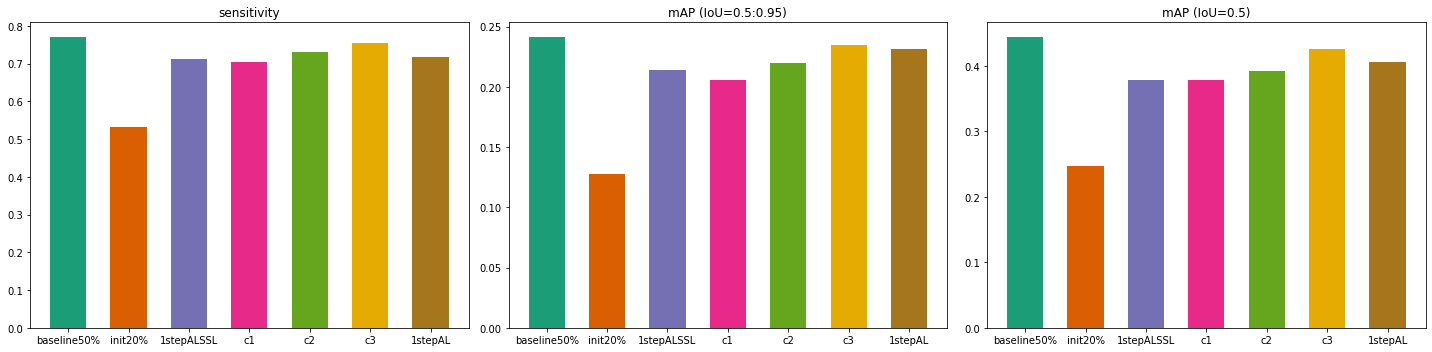

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(20,5))
ax = ax.flatten()
colors = ['#1b9e77', '#d95f02', '#7570b3', '#e7298a', '#66a61e', '#e6ab02', '#a6761d', '#3288bd', '#d53e4f', '#6a3d9a']
exp_names = ['baseline50%', 'init20%', '1stepALSSL', 'c1', 'c2', 'c3', '1stepAL']

for a, key in zip(ax, list(results_for_plotting.keys())):
    result = results_for_plotting[key]
    a.bar(range(0, len(result)), result, tick_label=exp_names, color=colors, width=0.6)
    a.set_title(str(key))
        
plt.tight_layout()